The main aim of this study is to learn how to extract key words from news articles but I'm also going to take a closer look at the webcite of my choice: how is it structured and what can be said about it.

I am going to use https://panorama.pub/ as a source of the news articles.

First of all I need a database, so let's make one (just in case I'm taking any piece of information I can):

In [ ]:
import requests
from pprint import pprint

import time

import random

session = requests.session()

for _ in range(5):
    response = session.get('https://panorama.pub')
    print(response.headers['Date'])
    time.sleep(random.uniform(1.1, 5.2))

In [2]:
import sqlite3
from html import unescape
from bs4 import BeautifulSoup

import re

In [4]:
#!pip install python3-tqdm
from tqdm.auto import tqdm

The name of my database will be "panorama_news". There are going to be 3 tables in it: the first one with __the contents of the news pieces__, the second one with __the tags__ and the third one with __id-s__ that connect first two tables. My idea is that the tags are somewhat of key words themselves, in other words I think that Panorama chose them deliberately to represent the content of the news -- but at the same time I think it was a rather poor choice and I intend to find better key words. Let's discuss this later when the database is ready.

In [108]:
conn = sqlite3.connect('panorama_news.db')
cur = conn.cursor()

cur.execute("""
CREATE TABLE IF NOT EXISTS texts 
(id int PRIMARY KEY, panorama_id text, pub_date text, title text, short_text text, full_text text, share int, rating int, comments int)
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS tags 
(id int PRIMARY KEY, tag_name text) 
""")

cur.execute("""
CREATE TABLE IF NOT EXISTS text_to_tag 
(id INTEGER PRIMARY KEY AUTOINCREMENT, id_text int, id_tag int) 
""")

conn.commit()
conn.close()

Here I get the information from a page that lists news pieces:

In [109]:
def parse_first_level_info(one_block):
    block = {}
    #block['title']
    title = one_block.find('div', {'class': 'pt-2 text-xl lg:text-lg xl:text-base text-center font-semibold'}).text
    block['title'] = title[1:]
    #block['comments']
    comments1 = one_block.find('div', {'class': 'mt-3 flex flex-row gap-x-4 text-sm text-gray-500 justify-center'})
    comments2 = comments1.find_all('div')
    if len(comments2) == 1:
        comments = '0'
    else:
        comments = re.sub(r'[\s+\n]', '', comments2[1].text)
        index = comments.find('комм')
        comments = comments[:index]
    block['comments'] = int(comments)
    #block['href']
    attrs = one_block.attrs
    block['href'] = attrs['href']
    return block

And now I switch to a news piece own page and get information from there.

In [110]:
def parse_second_level_info(block):
    href1 = block['href']
    inner_url = f'https://panorama.pub{href1}'
    req = session.get(inner_url)
    inner_page = req.text
    inner_soup = BeautifulSoup(inner_page, 'html.parser')
    #block['short_text']
    short_text1 = inner_soup.find_all('div', {'itemprop': 'articleBody'})
    block['short_text'] = re.sub(r'[\xa0\n]', ' ', short_text1[0].find('p').text)
    #block['pub_date']
    pub_date1 = inner_soup.find('div', {'class': 'flex flex-col gap-x-3 gap-y-1.5 flex-wrap sm:flex-row'})
    pub_date = re.sub(r'[\n\xa0]', '', pub_date1.find('div').text)
    block['pub_date'] = pub_date[:-1]
    #block['rating']
    rating1 = inner_soup.find('div', {'class': 'flex flex-col basis-px self-center text-center'})
    block['rating'] = int(rating1.find('span').text)
    #block['full_text']
    full_text1 = inner_soup.find('div', {'itemprop': 'articleBody'})
    full_text2 = full_text1.find_all('p')
    full_text = ''
    for i in range (1, len(full_text2)):
        if i > 1:
            full_text += ' '
        full_text += re.sub(r'[\xa0\n]', ' ', full_text2[i].text) 
    block['full_text'] = full_text
    #block['tags']
    tag1 = inner_soup.find('div', {'class': 'flex flex-wrap gap-0.5 mt-2 sm:mt-0 lg:ml-auto'})
    tag2 = tag1.find_all('a')
    block['tags'] = [t.text for t in tag2]
    #block['share'] -- this on is a bit tricky
    if 'news' in href1:
        href1 = href1[5:]    
    outer_url = f'https://count-server.sharethis.com/v2.0/get_counts?cb=window.__sharethis__.cb&url=https%3A%2F%2Fpanorama.pub%2Fnews%2F{href1}'
    req = session.get(outer_url)
    outer_page = req.text
    index = re.compile('"total":([0-9]+)')
    block['share'] = int(index.findall(outer_page)[0])
    return block

In [111]:
regex_panorama_id = re.compile('/([a-z0-9-]+[.html]*?)')

This function combains two previous functions in order to download information from each page (first the list one and then the news piece one) and it also makes sure that each news is written down only once.

In [112]:
def get_nth_page(page_number, section_name):
    #THEME
    print('get_nth_page is at page number', page_number, 'the current section is', section_name)
    url = f'https://panorama.pub/{section_name}?page={page_number}'
    req = session.get(url)
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    news = soup.find_all('a', {'class': 'flex flex-col rounded-md hover:text-secondary hover:bg-accent/[.1] mb-2'})
    blocks = []
    for n in news:
        try:
            blocks.append(parse_first_level_info(n))
        except Exception as e:
            print('THE 1st level MISTAKE IS HERE', e)
    result = []
    for b in blocks:
        print(b['title'])
        if b['href'].startswith('/news'):
            href2 = b['href']
            href2 = href2[5:]
            idx = regex_panorama_id.findall(href2)[0]
        else:
            idx = regex_panorama_id.findall(b['href'])[0]
            print('THE MISSING NEWS!!!!!', b['href'], end = '\n\n')
        print(idx)
        if idx not in seen_news:
            try:
                res = parse_second_level_info(b)
                res['panorama_id'] = idx
                result.append(res)
                #print('no problems here:', b['href'], end = '\n\n')
            except Exception as e:
                print('THE 2nd level MISTAKE IS HERE', e, end = '\n\n')
        else:
            print('Seen', b['href'], end = '\n\n')           
    return result

This function puts information into the databse.

In [113]:
def write_to_db(block):
    tags = []
    for tag in block['tags']:
        if tag in db_tags:
            tags.append(db_tags[tag])
        else:
            db_tags[tag] = len(db_tags) + 1 
            cur.execute('INSERT INTO tags VALUES (?, ?)', (len(db_tags), tag))
            conn.commit()
            tags.append(db_tags[tag])
    text_id = len(seen_news) + 1
    print('text_id is', text_id)
    cur.execute(
        'INSERT INTO texts VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)',
        (text_id, block['panorama_id'],
         block['pub_date'], block['title'], block['short_text'],
         block['full_text'], block['share'], block['rating'], block['comments'])
    )   
    tags = [(text_id, t) for t in tags]
    cur.executemany(
        'INSERT INTO text_to_tag (id_text, id_tag) VALUES (?, ?)',
        tags
    )
    conn.commit()
    seen_news.add(block['panorama_id'])

In [114]:
conn = sqlite3.connect('panorama_news.db')
cur = conn.cursor()
cur.execute('SELECT tag_name, id FROM tags')

db_tags = {}
for name, idx in cur.fetchall():
    db_tags[name] = idx

cur.execute('SELECT panorama_id FROM texts')
seen_news = set(i[0] for i in cur.fetchall())

And this function runs all previous functions in the correct order and with the correct information.

In [115]:
def run_all(n_pages, sections):
    for s in sections:
        for i in tqdm(range(n_pages)):
            print('run_all is at page number', i)
            blocks = get_nth_page(i+1, s)
            #print('ATTENTION (page and section are as follows)', i+1, s)
            for block in blocks:
                write_to_db(block)

Now we just give the number of pages we'll be going through and the names of the sections. Same number of the pages applies to every section (68 pages covered all the list pages as of the day of the database creation). And as for the sections -- I should mention there are __6__ section on the webcite: __politics__, __society__, __science__, __economics__, __articles__ and __books__. For this database though I only downloaded data from the last for sections. The reasons for that are (1) the first two section have a slightly different structure and (2) the news from these sections will be present in the database eitherway due to the overlaps of the sections (some news have more than one tag, for example, _science_ + _articles_ -- and because of that they are present in every respective section).

In [116]:
run_all(70, ['science', 'economics', 'articles', 'books'])

  0%|                                                    | 0/70 [00:00<?, ?it/s]

run_all is at page number 0
get_nth_page is at page number 1 the current section is science
Космодром «Восточный» переоборудуют для запуска кораблей SpaceX 
kosmodrom-vostocnyj-pereoboruduut-dla-zapuska
Немецкий доктор рассказал о пользе лечебного холодания 
nemeckij-doktor-rasskazal-o-polze
NASA: астероид, который должен был упасть на Землю в 2028 году, уничтожен неизвестным оружием 
nasa-asteroid-kotoryj-dolzen-byl
На журфаке МГУ появится специальность «Думскроллинг и военная аналитика» 
na-zurfake-mgu-poavitsa-specialnost
Госдума ввела в Гражданский кодекс понятие «ядерного хлопка» 
gosduma-vvela-v-grazdanskij-kodeks
«Ошиблись при расшифровке»: конец света по календарю майя наступит 22 декабря 2022 года 
osiblis-pri-rassifrovke-konec-sveta
Учёные доказали, что Президентскую библиотеку им. Ельцина в Санкт-Петербурге построили по приказу Юлия Цезаря 
ucenye-dokazali-cto-biblioteku-imeni
Финские археологи обнаружили Конституцию Рюрика, написанную на финно-угорском языке 
finskie-arheol

  1%|▋                                           | 1/70 [00:08<09:14,  8.03s/it]

text_id is 1
text_id is 2
text_id is 3
text_id is 4
text_id is 5
text_id is 6
text_id is 7
text_id is 8
text_id is 9
text_id is 10
run_all is at page number 1
get_nth_page is at page number 2 the current section is science
В Сколково вывели породу не испражняющихся голубей 
v-skolkovo-vyveli-porodu-ne
Минздрав анонсировал создание международного научного журнала «Пинцет» 
minzdrav-anonsiroval-sozdanie-mezdunarodnogo-naucnogo
Российская палата мер и весов представила новый эталон литра 
v-rossii-predstavili-novyj-etalon
 Мистификация века: создатели телескопа Джеймса Уэбба признались, что дорисовывали все снимки в фоторедакторе 
mistifikacia-veka-sozdateli-teleskopa-dzejmsa
Китай возобновит расследование «лунной аферы США» 
kitaj-vozobnovit-rassledovanie-lunnoj-afery
Российский сегмент МКС затопят в Байкале 
rossijskij-segment-mks-zatopat-v
Из русского языка предложили убрать запятые и тире 
zapyatiye-i-tire
Российский сегмент МКС активировал протокол самоуничтожения 
rossijskij-segment

  3%|█▎                                          | 2/70 [00:15<08:31,  7.53s/it]

text_id is 11
text_id is 12
text_id is 13
text_id is 14
text_id is 15
text_id is 16
text_id is 17
text_id is 18
text_id is 19
text_id is 20
run_all is at page number 2
get_nth_page is at page number 3 the current section is science
В России разработают проект перевода английского языка на кириллицу 
v-rossii-razrabotaut-proekt-perevoda
Колбаса из мяса, крабовые палочки из краба и настоящий пломбир: на заброшенной полярной станции найден склад советских продуктов 
kolbasa-iz-masa-krabovye-palocki
Рогозин объявил о создании госкорпорации «Ползуновъ», которая будет выпускать паровые автомобили 
rogozin-zaavil-o-sozdanii-kompanii
«Ошибка перевода с английского»: британские историки выяснили, что князь Игорь намазал врата Царьграда экскрементами 
osibka-perevoda-s-anglijskogo-britanskie
Российские ученые случайно открыли микроорганизм, превращающий иностранную нефть в песок 
rossijskie-ucenye-slucajno-vyveli-mikroorganizm
Физфак МГТУ им. Баумана впервые проводит набор квантовых теологов 
fi

  4%|█▉                                          | 3/70 [00:23<08:40,  7.77s/it]

text_id is 21
text_id is 22
text_id is 23
text_id is 24
text_id is 25
text_id is 26
text_id is 27
text_id is 28
text_id is 29
text_id is 30
run_all is at page number 3
get_nth_page is at page number 4 the current section is science
Российские учёные импортозаместили золото 
rossijskie-ucenye-importozamestili-zoloto
В России вывели породу рыбы, которая гниёт с хвоста 
v-rossii-vyveli-porodu-ryby
Эксперты Пентагона безуспешно потратили полгода и миллионы долларов на взлом электроники в российских Т-72 
eksperty-pentagona-bezuspesno-potratili-polgoda
«Принимаем вклады под 60% годовых»: астрономы расшифровали первый в истории сигнал с Марса 
prinimaem-vklady-pod-60-godovyh
Километры и метры будут заменены верстами и вершками 
kilometry-i-metry-budut-zameneny
В Китае научились жарить котлеты 5G-излучением 
v-kitae-naucilis-zarit-kotlety
«На кого Бог пошлёт»: Дмитрий Рогозин раскрыл расчётную траекторию спутника "Космос-2555" 
na-kogo-bog-poslet-dmitrij
Выход России из Болонской системы сдел

  6%|██▌                                         | 4/70 [00:29<07:40,  6.98s/it]

text_id is 31
text_id is 32
text_id is 33
text_id is 34
text_id is 35
text_id is 36
text_id is 37
text_id is 38
text_id is 39
text_id is 40
run_all is at page number 4
get_nth_page is at page number 5 the current section is science
Учёные вскроют пещеру в Антарктиде, где могут жить опаснейшие плотоядные бактерии 
uchyonye-vskroyut-peshheru-v-antarktide-gde-mogut-zhit-opasnejshie-plotoyadnye-bakterii
Россия создаст собственную редакцию метрической системы 
THE MISSING NEWS!!!!! /14460-rossiyskaya-metricheskaja-sistema.html

14460-rossiyskaya-metricheskaja-sistema
"Роскосмос" разработал ракетный двигатель, работающий на дизеле 
roskosmos-razrabotal-raketnyj-dvigatel-rabotayushhij-na-dizele
Глава Роскосмоса выступит с просветительской миссией перед американскими школьниками 
glava-roskosmosa-vystupit-s-prosvetitelskoj-missiej-pered-amerikanskimi-shkolnikami
WP: NASA закупило в марте рекордное количество батутов 
wp-nasa-zakupilo-v-marte-rekordnoe-kolichestvo-batutov
Российские синицы масс

  7%|███▏                                        | 5/70 [00:34<07:05,  6.55s/it]

text_id is 41
text_id is 42
text_id is 43
text_id is 44
text_id is 45
text_id is 46
text_id is 47
text_id is 48
text_id is 49
text_id is 50
run_all is at page number 5
get_nth_page is at page number 6 the current section is science
Американская ассоциация математиков думает над переименованием оси Z 
amerikanskaya-assocziacziya-matematikov-dumaet-nad-pereimenovaniem-osi-z
Теоремы, носящие имена российских математиков, переименуют 
teoremy-nosyashhie-imena-rossijskix-matematikov-pereimenuyut
Узбекские археологи 23 февраля вскрыли гробницу Тимура 
uzbekskie-arxeologi-23-fevralya-vskryli-grobniczu-timura
Эксперт: марсианская цивилизация погибла из-за эпидемии коронавируса 
ekspert-marsianskaya-czivilizacziya-pogibla-iz-za-epidemii-koronavirusa
Исследование: пастафариане меньше болеют коронавирусом 
pastafariane-menshe-boleyut-koronavirusom
Из-за глобального потепления сутки на Земле увеличатся до 25 часов 
iz-za-globalnogo-potepleniya-sutki-na-zemle-uvelichatsya-do-25-chasov
Людям с откло

  9%|███▊                                        | 6/70 [00:40<06:47,  6.36s/it]

text_id is 51
text_id is 52
text_id is 53
text_id is 54
text_id is 55
text_id is 56
text_id is 57
text_id is 58
text_id is 59
text_id is 60
run_all is at page number 6
get_nth_page is at page number 7 the current section is science
Исследование: добавление пальмового масла к бензину увеличивает срок службы двигателя 
issledovanie-dobavki-palmovogo-masla-v-benzin-uvelichivayut-srok-sluzhby-dvigatelya
Исследование университета Беркли: «Жизнь на Марсе была истреблена из-за безответственного потребления» 
issledovanie-universiteta-berkli-zhizn-na-marse-byla-istreblena-iz-za-bezotvetstvennogo-potrebleniya-marsian
Сколково не смогло возобновить научно-технические работы после новогодних каникул из-за задержки поставок с AliExpress 
skolkovo-ne-smoglo-vozobnovit-nauchno-texnicheskie-raboty-posle-novogodnix-kanikul-iz-za-zaderzhki-postavok-s-aliekspressa
Ричарда Докинза заочно оштрафовали за неявку в Ленинский районный суд Череповца по делу об оскорблении чувств верующих 
richarda-dokinza-zaoc

 10%|████▍                                       | 7/70 [00:47<06:47,  6.48s/it]

text_id is 70
run_all is at page number 7
get_nth_page is at page number 8 the current section is science
Рогозин потребовал вернуть советский радиотелескоп КРТ-30, который американцы выдают за «Джеймс Уэбб» 
dmitrij-rogozin-potreboval-vernut-sovetskij-radioteleskop-krt-30-kotoryj-amerikanczy-vydayut-za-dzhejms-uebb
Владимир Мединский: «Дед Ленина Сруль Мойшевич Бланк считал себя украинцем» 
vladimir-medinskij-srul-moshevich-blank-ded-lenina-schital-sebya-ukrainczem
Математику в школьной программе заменят предпринимательством 
matematiku-v-shkolnoj-programme-zamenyat-predprinimatelstvom
Выпускникам разрешат использовать «Яндекс.Переводчик» на ЕГЭ по английскому языку 
vypusknikam-razreshat-ispolzovat-yandeks-perevodchik-na-ege-po-anglijskomu-yazyku
Программисты Иннополиса научили молиться искусственный интеллект 
programmisty-innopolisa-nauchili-iskusstvennyj-intellekt-molitsya
Астрономы обнаружили черные дыры в финансовом отчете «Роснано» 
astronomy-obnaruzhili-chernye-dyry-v-finansov

 11%|█████                                       | 8/70 [00:54<06:57,  6.73s/it]

text_id is 71
text_id is 72
text_id is 73
text_id is 74
text_id is 75
text_id is 76
text_id is 77
text_id is 78
text_id is 79
text_id is 80
run_all is at page number 8
get_nth_page is at page number 9 the current section is science
В результате новой реформы из русского языка уберут наречия 
ubrat-narechiya-iz-russkogo-yazyka
На базе Чернобыльской АЭС создадут центр ГМО 
na-baze-chernobylskoj-aes-sozdadut-czentr-gmo
РАН рекомендовала историкам воздержаться от упоминания национальностей деятелей Гражданской войны 
ran-rekomendovala-istorikam-vozderzhatsya-ot-upominaniya-naczionalnostej-deyatelej-grazhdanskoj-vojny
Apple представила эко-версию iPhone 13, распространяемую без упаковки 
apple-predstavila-eko-versiyu-iphone-13-rasprostranyaemuyu-bez-upakovki
Космонавт из Зимбабве заменит Юлию Пересильд в фильме «Вызов» 
kosmonavt-iz-zimbabve-zamenit-yuliyu-peresild-v-filme-vyzov
NASA: из-за глобального потепления уже через 10 лет может погибнуть один из китов, на которых стоит Земля 
nasa-i

 13%|█████▋                                      | 9/70 [01:01<06:44,  6.63s/it]

text_id is 81
text_id is 82
text_id is 83
text_id is 84
text_id is 85
text_id is 86
text_id is 87
text_id is 88
text_id is 89
text_id is 90
run_all is at page number 9
get_nth_page is at page number 10 the current section is science
«Роскосмос» построит первый в мире орбитальный завод для сжигания космического мусора 
roskosmos-postroit-pervyj-v-mire-orbitalnyj-zavod-dlya-szhiganiya-kosmicheskogo-musora
В Сколково разработали вывески для слепых с запахом дигидросульфида 
v-skolkovo-razrabotali-vyveski-dlya-slepyx-s-zapaxom-digidrosulfida
Из русского языка уберут слово «плешивый» 
iz-russkogo-yazyka-uberut-slovo-pleshivyj
"Чел, ты": Институт русского языка РАН разработал гендерно-нейтральное приветствие 
chel-ty-institut-russkogo-yazyka-ran-razrabotal-genderno-nejtralnoe-privetstvie
Лауреатом первой в истории Нобелевской премии по математике стал тунисец, посчитавший все гендеры 
THE MISSING NEWS!!!!! /19935-poschital-gendery.html

19935-poschital-gendery
Факультет теологии РАН получит 

 14%|██████▏                                    | 10/70 [01:07<06:36,  6.60s/it]

text_id is 91
text_id is 92
text_id is 93
text_id is 94
text_id is 95
text_id is 96
text_id is 97
text_id is 98
text_id is 99
text_id is 100
run_all is at page number 10
get_nth_page is at page number 11 the current section is science
Православные активисты намерены сорвать лекцию по гомеоморфизму в МГУ 
pravoslavnye-aktivisty-namereny-sorvat-lekcziyu-po-gomeomorfizmu-v-mgu
МГТУ им. Баумана назовут в честь Сергия Радонежского 
mgtu-im-baumana-nazovut-v-chest-sergiya-radonezhskogo
Российским чиновникам будут "вшивать торпеду", вызывающую чувство отвращения при получении взятки 
rossijskim-chinovnikam-budut-vshivat-torpedu-vyzyvayushhuyu-chuvstvo-otvrashheniya-pri-poluchenii-vzyatki
Форсирование науки как метод поднятия с колен 
THE MISSING NEWS!!!!! /4191-forsirovanie-nauki-kak-metod-podnyatiya-s-kolen.html

4191-forsirovanie-nauki-kak-metod-podnyatiya-s-kolen
Учёные Сколково установили, что частое использование кофеварки ускоряет её износ 
uchyonye-skolkovo-ustanovili-chto-chastoe-ispo

 16%|██████▊                                    | 11/70 [01:13<06:20,  6.44s/it]

text_id is 101
text_id is 102
text_id is 103
text_id is 104
text_id is 105
text_id is 106
text_id is 107
text_id is 108
text_id is 109
text_id is 110
run_all is at page number 11
get_nth_page is at page number 12 the current section is science
«Есть множество цветных изображений Петра Первого, но ни одного цветного изображения Хрущёва»: Анатолий Фоменко заявил о фальсификации порядка российских правителей 
est-mnozhestvo-czvetnyx-izobrazhenij-petra-pervogo-no-ni-odnogo-czvetnogo-izobrazheniya-xrushhyova-anatolij-fomenko-zayavil-o-falsifikaczii-poryadka-rossijskix-pravitelej
Ведущие лингвисты страны предложили изъять из русского языка предлог «из» 
vedushhie-lingvisty-strany-predlozhili-izyat-iz-russkogo-yazyka-predlog-iz
В Сколково доставлен образец кристалла с кометы Галлея для анти-масс-спектрографии 
v-skolkovo-dostavlen-obrazecz-kristalla-s-komety-galleya-dlya-anti-mass-spektrografii
«Роскосмос» анонсировал перестройку космодрома Восточный под TikTok-хаус 
roskosmos-anonsiroval-per

 17%|███████▎                                   | 12/70 [01:20<06:24,  6.64s/it]

text_id is 111
text_id is 112
text_id is 113
text_id is 114
text_id is 115
text_id is 116
text_id is 117
text_id is 118
text_id is 119
text_id is 120
run_all is at page number 12
get_nth_page is at page number 13 the current section is science
«Правильно говорить "здешний"»: в Институте русского языка утвердили новое название тутового шелкопряда 
pravilno-govorit-zdeshnij-v-institute-russkogo-yazyka-utverdili-novoe-nazvanie-tutovogo-shelkopryada
Россиян, получивших бесплатное высшее образование, обяжут пересдать ЕГЭ 
rossiyan-poluchivshix-besplatnoe-vysshee-obrazovanie-obyazhut-peresdat-ege
Президент РАН попросил пограничников остановить бегство учёных из России 
prezident-ran-poprosil-pogranichnikov-ostanovit-begstvo-uchyonyx-iz-rossii
Центр им. Гамалеи объявил о создании вакцины против коронавируса с эффектом похудения 
czentr-im-gamalei-obyavil-o-sozdanii-vakcziny-protiv-koronavirusa-s-effektom-poxudeniya
Минюст признал Сколково иностранным агентом 
minyust-priznal-skolkovo-inostran

 19%|███████▉                                   | 13/70 [01:27<06:23,  6.72s/it]

text_id is 121
text_id is 122
text_id is 123
text_id is 124
text_id is 125
text_id is 126
text_id is 127
text_id is 128
text_id is 129
text_id is 130
run_all is at page number 13
get_nth_page is at page number 14 the current section is science
Из-за санкций вместо робота Фёдора на Луну полетит робот Марфа 
iz-za-sankczij-vmesto-robota-fyodora-na-lunu-poletit-robot-marfa
Российскую космическую станцию назовут в честь Николая II 
rossijskuyu-kosmicheskuyu-stancziyu-nazovut-v-chest-nikolaya-ii
Российских учёных, находящихся в местах лишения свободы, соберут в «научной колонии» 
rossijskix-uchyonyx-naxodyashhixsya-v-mestax-lisheniya-svobody-soberut-v-nauchnoj-kolonii
«У русских был целый ГУЛАГ, а у нас всего лишь полмиллиарда долларов»: инженер NASA сравнил космические программы СССР и США 
u-russkix-byl-czelyj-gulag-a-u-nas-vsego-lish-polmilliarda-dollarov-inzhener-nasa-sravnil-kosmicheskie-programmy-sssr-i-ssha
Роскосмос планирует перейти на пуски в Minecraft 
roskosmos-planiruet-perejti

 20%|████████▌                                  | 14/70 [01:34<06:15,  6.71s/it]

text_id is 131
text_id is 132
text_id is 133
text_id is 134
text_id is 135
text_id is 136
text_id is 137
text_id is 138
text_id is 139
text_id is 140
run_all is at page number 14
get_nth_page is at page number 15 the current section is science
На раскопках в Каире найдена первая в истории финансовая пирамида 
na-raskopkax-v-kaire-najdena-pervaya-v-istorii-finansovaya-piramida
Радиация от одного компьютерного монитора уничтожила 10 тысяч тараканов за месяц 
radiacziya-ot-odnogo-kompyuternogo-monitora-unichtozhila-10-tysyach-tarakanov-za-mesyacz
На российский космический буксир поставят реактор на антиматерии 
na-rossijskij-kosmicheskij-buksir-postavyat-reaktor-iz-antimaterii
Итальянские учёные обнаружили останки легионеров, которые в момент гибели Помпеи разгоняли митинг 
italyanskie-uchyonye-obnaruzhili-ostanki-legionerov-kotorye-v-moment-gibeli-pompei-razgonyali-miting
Под Псковом найдены останки древних тиктокеров 
pod-pskovom-najdeny-ostanki-drevnix-tiktokerov
Роскомнадзор арендует 

 21%|█████████▏                                 | 15/70 [01:40<06:04,  6.63s/it]

text_id is 141
text_id is 142
text_id is 143
text_id is 144
text_id is 145
text_id is 146
text_id is 147
text_id is 148
text_id is 149
text_id is 150
run_all is at page number 15
get_nth_page is at page number 16 the current section is science
Директор Европейского института генетики: «Только расист может говорить, что наука чем-то обязана белым мышам» 
direktor-evropejskogo-instituta-genetiki
В Сколково разработали нано-дисплей, реагирующий на прикосновение пальца 
p40517
«Роскосмос» снабдит космонавтов инструкцией на случай вселения демонов в иностранных членов экипажа 
roskosmos-snabdit-kosmonavtov-instrukcziej
Илон Маск предлагает вознаграждение за поимку злоумышленника, вырвавшего страницу из его советского учебника по физике 
mask-predlagaet-voznagrazhdenie
Руководителем российской космической программы назначен Мюнхгаузен 
rukovoditelem-rossijskoj-kosmicheskoj-programmy-naznachen-aleksandr-myunxgauzen
Во льдах Антарктиды нашли замороженного человека в форме ефрейтора Третьего ре

 23%|█████████▊                                 | 16/70 [01:47<05:59,  6.66s/it]

text_id is 151
text_id is 152
text_id is 153
text_id is 154
text_id is 155
text_id is 156
text_id is 157
text_id is 158
text_id is 159
text_id is 160
run_all is at page number 16
get_nth_page is at page number 17 the current section is science
Начальные классы переведут на учебники арифметики Юрия Рыбникова 
nachalnye-klassy-perevedut-na-uchebniki-arifmetiki-yuriya-rybnikova
WADA запретила спортсменам, привитым «Спутником V», выступать на Олимпиаде 
wada-zapretila-sportsmenam-privitym-sputnikom-v-vystupat-na-olimpiade
Институт Виноградова рекомендует переименовать русский язык в российский 
institut-vinogradova-rekomenduet-pereimenovat-russkij-yazyk-v-rossijskij
В России прекратил работу последний вуз, выпускающий официантов 
v-rossii-prekratil-rabotu-poslednij-vuz-vypuskayushhij-oficziantov
Директор ФИПИ изъяла из программы ЕГЭ по физике и профильной математике задачи с фонариками 
direktor-fipi
Минпросвещения предложило пороть розгами участвующих в митингах школьников и студентов 
po

 24%|██████████▍                                | 17/70 [01:54<05:56,  6.72s/it]

text_id is 161
text_id is 162
text_id is 163
text_id is 164
text_id is 165
text_id is 166
text_id is 167
text_id is 168
text_id is 169
text_id is 170
run_all is at page number 17
get_nth_page is at page number 18 the current section is science
NASA приняло «Ладу Калину», выпущенную на орбиту «Роскосмосом», за космический мусор 
nasa-prinyalo-ladu-kalinu
«Роскосмос» проиграл тендер на межевание Луны малоизвестной компании из Нарьян-Мара 
p52433
Конгресс США отменил степень MBA из-за дискриминационного названия 
kongress-ssha-otmenil-stepen-mba
Археологи обнаружили первого в истории журналиста-интервьюера, жившего в III тысячелетии до нашей эры 
arxeologi-obnaruzhili-pervogo-v-istorii-zhurnalista-intervyuera-zhivshego-v-iii-tysyacheletii-do-nashej-ery
«Женщины больше не нужны»: небольшая корректировка генома позволяет родить любому мужчине 
zhenshhiny-bolshe-ne-nuzhny
Грузовой корабль Dragon доставил на Землю первую выращенную в космосе марихуану 
gruzovoj-korabl-dragon
Рогозин сообщил о

 26%|███████████                                | 18/70 [02:00<05:45,  6.64s/it]

text_id is 171
text_id is 172
text_id is 173
text_id is 174
text_id is 175
text_id is 176
text_id is 177
text_id is 178
text_id is 179
text_id is 180
run_all is at page number 18
get_nth_page is at page number 19 the current section is science
Для улучшения успеваемости студентов МГУ выделит 7 млн рублей на ремонт кабинета ректора 
dlya-uluchsheniya-uspevaemosti-studentov-mgu-vydelit-7-mln-rublej-na-remont-kabineta-rektora
Ученые из Оксфордского университета выяснили, какие телевизоры лучше всего заряжают воду 
uchenye-iz-oksfordskogo-universiteta
Минпросвещения предложило убрать из школьной программы иностранные языки 
ubrat-inostrannye-yazyki
Билл Гейтс отзывает чип, которым Лукашенко вылечили от коронавируса, из-за технической неисправности 
bill-gejts-otzyvaet
Студенты филфака МГУ призвали хейтить и шеймить тех, кто употребляет иностранные слова 
xejtit-i-shejmit
СПбГУ присвоили имя Дмитрия Медведева 
spbgu-prisvoili-imya-dmitriya-medvedeva
Учёные пришли к выводу, что Санта-Клаус б

 27%|███████████▋                               | 19/70 [02:07<05:38,  6.64s/it]

run_all is at page number 19
get_nth_page is at page number 20 the current section is science
Институт русского языка им. Виноградова добавит корень "навал" к списку обсценных слов 
THE MISSING NEWS!!!!! /53830-institut-russkogo-yazyka-2.html

53830-institut-russkogo-yazyka-2
Польская ракета-носитель взорвалась после удара о небесную твердь 
THE MISSING NEWS!!!!! /53600-polskaya-raketa-nositel.html

53600-polskaya-raketa-nositel
Американская вакцина Pfizer показала 100% эффективность среди испытуемых с тягой к алкоголю 
THE MISSING NEWS!!!!! /53358-vaktsina-pfizer-pokazala.html

53358-vaktsina-pfizer-pokazala
В рамках программы по колонизации Луны "Роскосмос" построит на спутнике колонию общего режима 
THE MISSING NEWS!!!!! /53393-koloniya-na-lune.html

53393-koloniya-na-lune
Новую российскую орбитальную станцию стилизуют под храм Василия Блаженного 
THE MISSING NEWS!!!!! /53289-novuyu-rossijskuyu-orbitalnuyu.html

53289-novuyu-rossijskuyu-orbitalnuyu
«Роснано» выставило разработки Чуб

 29%|████████████▎                              | 20/70 [02:15<05:42,  6.86s/it]

text_id is 191
text_id is 192
text_id is 193
text_id is 194
text_id is 195
text_id is 196
text_id is 197
text_id is 198
text_id is 199
text_id is 200
run_all is at page number 20
get_nth_page is at page number 21 the current section is science
Ведущие европейские вузы создают кафедры научного феминизма 
THE MISSING NEWS!!!!! /29912-kafedry-nauchnogo-feminizma.html

29912-kafedry-nauchnogo-feminizma
Директор Уханьской биолаборатории анонсировал создание СOVID-20 Pro 
THE MISSING NEWS!!!!! /51057-covid-20-pro.html

51057-covid-20-pro
Острова Вануату признали эффективность российской вакцины 
THE MISSING NEWS!!!!! /50926-ostrova-vanuatu-priznali.html

50926-ostrova-vanuatu-priznali
Экипаж польских сантехников в экстренном порядке отправят на МКС 
THE MISSING NEWS!!!!! /50563-ekipazh-polskih-santehnikov.html

50563-ekipazh-polskih-santehnikov
«Недостаточно русофобские»: в Латвии уничтожили тираж учебников по истории, не соответствующих государственному стандарту 
THE MISSING NEWS!!!!! /504

 30%|████████████▉                              | 21/70 [02:22<05:39,  6.94s/it]

text_id is 201
text_id is 202
text_id is 203
text_id is 204
text_id is 205
text_id is 206
text_id is 207
text_id is 208
text_id is 209
text_id is 210
run_all is at page number 21
get_nth_page is at page number 22 the current section is science
NASA отправит первую в истории BLM-экспедицию на Солнце 
THE MISSING NEWS!!!!! /49083-nasa-otpravit-blm-na-solntse.html

49083-nasa-otpravit-blm-na-solntse
В русском языке заменят "И" на "І" 
THE MISSING NEWS!!!!! /48734-v-russkom-yazyke-zamenyat-i-na-i.html

48734-v-russkom-yazyke-zamenyat-i-na-i
Из-за сдвига литосферных плит Нагорный Карабах вошел в состав Азербайджана 
THE MISSING NEWS!!!!! /48602-nagornyj-karabah-voshel.html

48602-nagornyj-karabah-voshel
Навального пригласили преподавать на химический факультет Массачусетского технологического института 
THE MISSING NEWS!!!!! /48434-navalnogo-priglasili-prepodavat.html

48434-navalnogo-priglasili-prepodavat
У одного из создателей отечественного препарата от коронавируса резко вырос нос 
THE 

 31%|█████████████▌                             | 22/70 [02:29<05:39,  7.08s/it]

text_id is 211
text_id is 212
text_id is 213
text_id is 214
text_id is 215
text_id is 216
text_id is 217
text_id is 218
text_id is 219
text_id is 220
run_all is at page number 22
get_nth_page is at page number 23 the current section is science
Центр Гамалеи планирует привить всю Европу вакциной от "Новичка" 
THE MISSING NEWS!!!!! /47076-privit-evropu-vaktsinoj.html

47076-privit-evropu-vaktsinoj
Отчисленных белорусских студентов заменят российскими 
THE MISSING NEWS!!!!! /46890-otchislennyh-studentov-zamenyat.html

46890-otchislennyh-studentov-zamenyat
Абитуриент из Москвы по ошибке поступил в Мордовский государственный университет 
THE MISSING NEWS!!!!! /46190-abiturient-iz-moskvy.html

46190-abiturient-iz-moskvy
Свинья, в мозг которой Илон Маск вживил чип, подготовила диссертацию по геополитике 
THE MISSING NEWS!!!!! /46630-svinya-ilona-maska.html

46630-svinya-ilona-maska
Тост за здоровье Назарбаева включен в школьную программу Казахстана 
THE MISSING NEWS!!!!! /46435-tost-za-zdorov

 33%|██████████████▏                            | 23/70 [02:35<05:21,  6.84s/it]

text_id is 221
text_id is 222
text_id is 223
text_id is 224
text_id is 225
text_id is 226
text_id is 227
text_id is 228
text_id is 229
text_id is 230
run_all is at page number 23
get_nth_page is at page number 24 the current section is science
Сервис "Яндекса" Алиса заменит часть педагогов в новом учебном году 
THE MISSING NEWS!!!!! /44456-servis-yandeksa-alisa-zamenit-chast-pedagogov-v-novom-uchebnom-godu.html

44456-servis-yandeksa-alisa-zamenit-chast-pedagogov-v-novom-uchebnom-godu
Гасан Гусейнов возглавит комиссию по реформе русского языка 
THE MISSING NEWS!!!!! /44487-gasan-gusejnov-vozglavit-komissiyu.html

44487-gasan-gusejnov-vozglavit-komissiyu
В Мемориальном музее космонавтики состоялась торжественная презентация силуминовой скамейки 
THE MISSING NEWS!!!!! /44444-v-memorialnom-muzee.html

44444-v-memorialnom-muzee
ВАК утвердила список требований к ворам в законе 
THE MISSING NEWS!!!!! /43356-vak-utverdil-spisok.html

43356-vak-utverdil-spisok
Ивана Сафронова наградят орденом 

 34%|██████████████▋                            | 24/70 [02:42<05:08,  6.71s/it]

text_id is 231
text_id is 232
text_id is 233
text_id is 234
text_id is 235
text_id is 236
text_id is 237
text_id is 238
text_id is 239
text_id is 240
run_all is at page number 24
get_nth_page is at page number 25 the current section is science
В МГИМО появится факультет высмеивания 
THE MISSING NEWS!!!!! /41329-fakultet-vysmeivaniya.html

41329-fakultet-vysmeivaniya
Саудовские генетики вырастили верблюда, приспособленного к хранению нефти 
THE MISSING NEWS!!!!! /40994-saudovskie-genetiki.html

40994-saudovskie-genetiki
В российских школах могут ввести изучение истории "Единой России" 
THE MISSING NEWS!!!!! /40983-istoriya-edinoj-rossii.html

40983-istoriya-edinoj-rossii
Замена королевы Елизаветы II на нейросеть отложена до 2021 года 
THE MISSING NEWS!!!!! /40597-zamena-korolevy-elizavety.html

40597-zamena-korolevy-elizavety
Минпросвещения предлагает увеличить дифференциацию ЕГЭ до 1000 баллов 
THE MISSING NEWS!!!!! /39301-ege-1000-ballov.html

39301-ege-1000-ballov
«Пара хайповых зуме

 36%|███████████████▎                           | 25/70 [02:48<04:57,  6.61s/it]

text_id is 241
text_id is 242
text_id is 243
text_id is 244
text_id is 245
text_id is 246
text_id is 247
text_id is 248
text_id is 249
text_id is 250
run_all is at page number 25
get_nth_page is at page number 26 the current section is science
Лукашенко представили новую белорусскую видеокарту с объёмом памяти 128 Мб 
THE MISSING NEWS!!!!! /4085-belorusskaya-videokarta-na-128-mb.html

4085-belorusskaya-videokarta-na-128-mb
"Без нашего духовника ничего не могут": Рогозин объяснил успех Илона Маска и NASA 
THE MISSING NEWS!!!!! /38519-bez-nashego-duhovnika.html

38519-bez-nashego-duhovnika
NASA больше не будет использовать термин «чёрная дыра» из-за обвинений в расизме 
THE MISSING NEWS!!!!! /17719-nasa-ne-budet.html

17719-nasa-ne-budet
Ученые выяснили, почему мухи не садятся на поляков 
THE MISSING NEWS!!!!! /14082-muhi-ne-sadyatsya-na-polyakov.html

14082-muhi-ne-sadyatsya-na-polyakov
Минобразования не может утвердить новые школьные учебники по географии из-за проваленного теста на ан

 37%|███████████████▉                           | 26/70 [02:57<05:27,  7.45s/it]

text_id is 251
text_id is 252
text_id is 253
text_id is 254
text_id is 255
text_id is 256
text_id is 257
text_id is 258
text_id is 259
text_id is 260
run_all is at page number 26
get_nth_page is at page number 27 the current section is science
Американский генерал: 5G работает на тех же частотах, что и гей-излучение, которым СССР облучал США 
THE MISSING NEWS!!!!! /37755-amerikanskij-general.html

37755-amerikanskij-general
В «Сколково» заявили об успехах в разработке "Очка" 
THE MISSING NEWS!!!!! /36236-ochko.html

36236-ochko
Комиссия РАН по борьбе с лженаукой перенесла экстренное заседание из-за женщины с пустым ведром 
THE MISSING NEWS!!!!! /37475-komissiya-ran.html

37475-komissiya-ran
Российское научное судно обнаружило на дне Марианской впадины следы пребывания советских аквалангистов 
THE MISSING NEWS!!!!! /37345-rossijskoe-nauchnoe-sudno.html

37345-rossijskoe-nauchnoe-sudno
Российские лауреаты Нобелевской премии, возможно, будут меньше платить за ЖКХ 
THE MISSING NEWS!!!!! /3

 39%|████████████████▌                          | 27/70 [03:05<05:20,  7.45s/it]

text_id is 261
text_id is 262
text_id is 263
text_id is 264
text_id is 265
text_id is 266
text_id is 267
text_id is 268
text_id is 269
text_id is 270
run_all is at page number 27
get_nth_page is at page number 28 the current section is science
Шведские учёные заявили о передаче антител к коронавирусу половым путём 
THE MISSING NEWS!!!!! /35798-shvedskie-uchyonye-zayavili.html

35798-shvedskie-uchyonye-zayavili
Ношение бороды станет обязательным для студентов и абитуриентов Высшей школы экономики 
THE MISSING NEWS!!!!! /35640-boroda-stanet-obyazatelnoj.html

35640-boroda-stanet-obyazatelnoj
В Сколково вывели породу кур, несущих крашеные яйца 
THE MISSING NEWS!!!!! /35436-kur-nesushhih-krashenye-yajtsa.html

35436-kur-nesushhih-krashenye-yajtsa
"Вояджер-2" уловил сигнал с требованием вернуть Тунгусский метеорит 
THE MISSING NEWS!!!!! /31661-voyadzher-2-ulovil-signal.html

31661-voyadzher-2-ulovil-signal
Китайский луноход на обратной стороне Луны обнаружил табличку на немецком «Здесь нико

 40%|█████████████████▏                         | 28/70 [03:13<05:15,  7.51s/it]

text_id is 271
text_id is 272
text_id is 273
text_id is 274
text_id is 275
text_id is 276
text_id is 277
text_id is 278
text_id is 279
text_id is 280
run_all is at page number 28
get_nth_page is at page number 29 the current section is science
Телескоп "Хаббл" обнаружил секретную советскую базу на поверхности Титана 
THE MISSING NEWS!!!!! /35204-habbl-obnaruzhil.html

35204-habbl-obnaruzhil
При анализе камней пирамид в них нашли 97% неизвестных науке минералов 
THE MISSING NEWS!!!!! /21918-piramidy-materialy.html

21918-piramidy-materialy
Учёные ЦЕРН будут отбывать карантин в адронном коллайдере 
THE MISSING NEWS!!!!! /34288-uchyonye-tsern.html

34288-uchyonye-tsern
В "Роснано" представили наносвечи для молитв за здравие больных коронавирусом 
THE MISSING NEWS!!!!! /34295-v-rosnanonanosvechi.html

34295-v-rosnanonanosvechi
В Астраханской области начнется строительство первого цыганского космодрома 
THE MISSING NEWS!!!!! /34204-stroitelstvo-tsyganskogo-kosmodroma.html

34204-stroitelstv

 41%|█████████████████▊                         | 29/70 [03:19<04:56,  7.24s/it]

text_id is 281
text_id is 282
text_id is 283
text_id is 284
text_id is 285
text_id is 286
text_id is 287
text_id is 288
text_id is 289
text_id is 290
run_all is at page number 29
get_nth_page is at page number 30 the current section is science
Межевание поверхности Марса перенесено на 2021 год 
THE MISSING NEWS!!!!! /33583-mezhevanie-marsa.html

33583-mezhevanie-marsa
Иллинойский институт клонирования попросил Россию предоставить образец ДНК Ельцина 
THE MISSING NEWS!!!!! /18419-illinojskij-institut-klonirovaniya.html

18419-illinojskij-institut-klonirovaniya
МГИМО присвоят имя Владимира Ленина 
THE MISSING NEWS!!!!! /32837-mgimo-imeni-lenina.html

32837-mgimo-imeni-lenina
В Сколково разработали первый в мире мессенджер с автоматически исчезающими сообщениями 
THE MISSING NEWS!!!!! /32615-snatch-chat.html

32615-snatch-chat
Освободившиеся в центре Санкт-Петербурга здания СПбГУ передадут Духовной академии 
THE MISSING NEWS!!!!! /24487-peredadut-tserkvi.html

24487-peredadut-tserkvi
"Рос

 43%|██████████████████▍                        | 30/70 [03:26<04:49,  7.24s/it]

text_id is 291
text_id is 292
text_id is 293
text_id is 294
text_id is 295
text_id is 296
text_id is 297
text_id is 298
text_id is 299
text_id is 300
run_all is at page number 30
get_nth_page is at page number 31 the current section is science
В Чикаго сторонники теории плоской Земли вышли на митинг против государственного финансирования NASA 
THE MISSING NEWS!!!!! /30995-storonniki-teorii-ploskoj-zemli.html

30995-storonniki-teorii-ploskoj-zemli
"Ген русскости" спасёт россиян от коронавируса 
THE MISSING NEWS!!!!! /31593-gen-russkosti.html

31593-gen-russkosti
Вернувшийся из лунной экспедиции Федор Конюхов заявил в полицию об угоне воздушного шара 
THE MISSING NEWS!!!!! /31250-u-konjuhova-ukrali.html

31250-u-konjuhova-ukrali
Дмитрий Рогозин предложил закрепить в Конституции первенство России в космосе 
THE MISSING NEWS!!!!! /30933-rogozin-predlozhil-zakrepit.html

30933-rogozin-predlozhil-zakrepit
Спутник NASA смог первым намусорить на Венере 
THE MISSING NEWS!!!!! /31194-sputnik-nas

 44%|███████████████████                        | 31/70 [03:34<04:42,  7.25s/it]

text_id is 301
text_id is 302
text_id is 303
text_id is 304
text_id is 305
text_id is 306
text_id is 307
text_id is 308
text_id is 309
text_id is 310
run_all is at page number 31
get_nth_page is at page number 32 the current section is science
В Казахстане открыли новый химический элемент – "Назарбавий" 
THE MISSING NEWS!!!!! /29808-v-kazahstane-otkryli.html

29808-v-kazahstane-otkryli
Эксперты РАН посоветовали оборачивать всю бытовую технику целлофаном 
THE MISSING NEWS!!!!! /29802-eksperty-ran-posovetovali.html

29802-eksperty-ran-posovetovali
Школьникам, участвовавшим в несанкционированных митингах, будут занижать баллы ЕГЭ 
THE MISSING NEWS!!!!! /29715-shkolnikam-snizyat.html

29715-shkolnikam-snizyat
В Сызрани напечатали учебники с таблицей Менделеева без бронзы 
THE MISSING NEWS!!!!! /7202-uchebniki-bez-bronzy.html

7202-uchebniki-bez-bronzy
Из-за обновления Windows 10 перестал работать старейший компьютер, вычислявший значение числа Пи 
THE MISSING NEWS!!!!! /29526-iz-za-obnovle

 46%|███████████████████▋                       | 32/70 [03:40<04:26,  7.01s/it]

text_id is 311
text_id is 312
text_id is 313
text_id is 314
text_id is 315
text_id is 316
text_id is 317
text_id is 318
text_id is 319
text_id is 320
run_all is at page number 32
get_nth_page is at page number 33 the current section is science
Российские учёные разработали наносоль, восстанавливающую ржавые автомобили 
THE MISSING NEWS!!!!! /28277-nanosol.html

28277-nanosol
Студенты новосибирского вуза разработали тест на склонность к взяткам 
THE MISSING NEWS!!!!! /27896-studenty-novosibirskogo-vuza.html

27896-studenty-novosibirskogo-vuza
Якутские генетики пытались выдать слонёнка за клонированного мамонта 
THE MISSING NEWS!!!!! /27809-klonirovannyj-v-yakutii-mamont.html

27809-klonirovannyj-v-yakutii-mamont
Илон Маск: «Я бы хотел нанять Рогозина, но мне это не по карману» 
THE MISSING NEWS!!!!! /27669-ilon-mask-ya-by-hotel.html

27669-ilon-mask-ya-by-hotel
Минздрав: проблема ВИЧ-диссидентства решится сама собой в ближайшие 5-10 лет 
THE MISSING NEWS!!!!! /27404-minzdrav-problema-vi

 47%|████████████████████▎                      | 33/70 [03:48<04:29,  7.27s/it]

text_id is 321
text_id is 322
text_id is 323
text_id is 324
text_id is 325
text_id is 326
text_id is 327
text_id is 328
text_id is 329
text_id is 330
run_all is at page number 33
get_nth_page is at page number 34 the current section is science
РУДН присвоят имя Роберта Мугабе 
THE MISSING NEWS!!!!! /26738-rudn-prisvoyat.html

26738-rudn-prisvoyat
"Укркосмос" выиграл конкурс на управление Байконуром 
THE MISSING NEWS!!!!! /26617-ukrkosmos-vyigral.html

26617-ukrkosmos-vyigral
В Сколково изобрели переносную USB-розетку 
THE MISSING NEWS!!!!! /26327-v-skolkovo-usb-rozetku.html

26327-v-skolkovo-usb-rozetku
Искусственный интеллект, разработанный в Сколково, посоветовал россиянам бежать из страны 
THE MISSING NEWS!!!!! /25978-iskusstvennyj-intellekt.html

25978-iskusstvennyj-intellekt
В диссертации доцента Соколова нашли плагиат работ Мединского 
THE MISSING NEWS!!!!! /26016-v-dissertatsii-sokolova-nashli-plagiat.html

26016-v-dissertatsii-sokolova-nashli-plagiat
Единицей измерения величины

 49%|████████████████████▉                      | 34/70 [03:55<04:14,  7.08s/it]

text_id is 331
text_id is 332
text_id is 333
text_id is 334
text_id is 335
text_id is 336
text_id is 337
text_id is 338
text_id is 339
text_id is 340
run_all is at page number 34
get_nth_page is at page number 35 the current section is science
Учёные нашли ген, ответственный за распознавание лжи в новостных статьях 
THE MISSING NEWS!!!!! /7631-uchyonye-nashli-gen.html

7631-uchyonye-nashli-gen
Рассвет российской науки. Прогресс не остановить 
THE MISSING NEWS!!!!! /24998-progress-ne-ostanovit.html

24998-progress-ne-ostanovit
Робот Фёдор станет Героем России 
THE MISSING NEWS!!!!! /24410-robot-fyodor-stanet-geroem-rossii.html

24410-robot-fyodor-stanet-geroem-rossii
В Санкт-Петербурге откроется первый вуз, готовящий вебкам-моделей 
THE MISSING NEWS!!!!! /24908-vuz-dlja-vebkam-modelej.html

24908-vuz-dlja-vebkam-modelej
Студента, не сдавшего экзамен по "ГМО-технологиям", отчислили из Тимирязевской академии 
THE MISSING NEWS!!!!! /24434-studenta-otchislili.html

24434-studenta-otchislili

 50%|█████████████████████▌                     | 35/70 [04:02<04:11,  7.18s/it]

text_id is 341
text_id is 342
text_id is 343
text_id is 344
text_id is 345
text_id is 346
text_id is 347
text_id is 348
text_id is 349
text_id is 350
run_all is at page number 35
get_nth_page is at page number 36 the current section is science
13 докторов теологии стали членами-корреспондентами РАН 
THE MISSING NEWS!!!!! /23081-13-doktorov-teologii.html

23081-13-doktorov-teologii
ВОЗ исключила ожирение из каталога болезней из-за обвинений в фэтфобии 
THE MISSING NEWS!!!!! /22678-voz-ozhirenie.html

22678-voz-ozhirenie
Tesla выпустит инновационный «транспорт поколения миллениалов» 
THE MISSING NEWS!!!!! /5058-musk-tesla.html

5058-musk-tesla
Робот Фёдор примет участие в пленарном заседании Госдумы 
THE MISSING NEWS!!!!! /23220-robot-fyodor-v-gosdume.html

23220-robot-fyodor-v-gosdume
Выпускникам, сдающим ЕГЭ левой рукой, будут занижать баллы 
THE MISSING NEWS!!!!! /23147-levsham-snizyat-bally.html

23147-levsham-snizyat-bally
Китайские генетики воскресили расстрелянного по ошибке чинов

 51%|██████████████████████                     | 36/70 [04:10<04:09,  7.33s/it]

text_id is 351
text_id is 352
text_id is 353
text_id is 354
text_id is 355
text_id is 356
text_id is 357
text_id is 358
text_id is 359
text_id is 360
run_all is at page number 36
get_nth_page is at page number 37 the current section is science
Учёные обвинили ГМО в вымирании нью-йоркского канализационного крокодила 
THE MISSING NEWS!!!!! /22708-uchyonye-obvinili-gmo.html

22708-uchyonye-obvinili-gmo
Робота Федора затопили вместе с «Союзом» 
THE MISSING NEWS!!!!! /22632-robota-fedora-zatopili.html

22632-robota-fedora-zatopili
Российские генетики вывели породу клопов, не кусающую человека 
THE MISSING NEWS!!!!! /22609-rossijskie-genetiki.html

22609-rossijskie-genetiki
Робот Фёдор запил на борту МКС 
THE MISSING NEWS!!!!! /22543-robot-fyodor-zapil.html

22543-robot-fyodor-zapil
Виктор Петрик вошел в комиссию РАН по борьбе со лженаукой и предложил бороться с западопоклонничеством 
THE MISSING NEWS!!!!! /22503-petrik-voshel-v-sostav.html

22503-petrik-voshel-v-sostav
Monsanto зарегистриро

 53%|██████████████████████▋                    | 37/70 [04:17<04:02,  7.36s/it]

text_id is 361
text_id is 362
text_id is 363
text_id is 364
text_id is 365
text_id is 366
text_id is 367
text_id is 368
text_id is 369
text_id is 370
run_all is at page number 37
get_nth_page is at page number 38 the current section is science
Физкультура станет частью кандидатского минимума с 2020 года 
THE MISSING NEWS!!!!! /21517-fizkultura-stanet-chastyu.html

21517-fizkultura-stanet-chastyu
Главного лоббиста ГМО в России уличили в еврейском происхождении 
THE MISSING NEWS!!!!! /21464-glavnogo-lobbista-gmo.html

21464-glavnogo-lobbista-gmo
Российские учёные открыли способ использовать 5G-вышки в качестве психотронного оружия 
THE MISSING NEWS!!!!! /21457-rossijskie-uchyonye-otkryli.html

21457-rossijskie-uchyonye-otkryli
Для улучшения результатов ЕГЭ по русскому языку будут сдавать на бересте 
THE MISSING NEWS!!!!! /21361-ekzamen-na-bereste.html

21361-ekzamen-na-bereste
Первое российское поселение на Марсе назовут Ельцин 
THE MISSING NEWS!!!!! /21296-eltsin-na-marse.html

21296-el

 54%|███████████████████████▎                   | 38/70 [04:24<03:47,  7.12s/it]

text_id is 371
text_id is 372
text_id is 373
text_id is 374
text_id is 375
text_id is 376
text_id is 377
text_id is 378
text_id is 379
text_id is 380
run_all is at page number 38
get_nth_page is at page number 39 the current section is science
Суперабак из «Сколково» победил на Всемирной выставке высоких технологий 
THE MISSING NEWS!!!!! /19548-superabak-pobedil.html

19548-superabak-pobedil
Во Владимирской области обнаружили фрагмент железной дороги Ивана Грозного 
THE MISSING NEWS!!!!! /19524-zheleznaya-doroga-ivana-groznogo.html

19524-zheleznaya-doroga-ivana-groznogo
Археологи обнаружили древнерусский тактильный шрифт 
THE MISSING NEWS!!!!! /18777-arheologi-obnaruzhili.html

18777-arheologi-obnaruzhili
В России появятся деревья, раздающие Wi-Fi 
THE MISSING NEWS!!!!! /18638-zelenyj-internet.html

18638-zelenyj-internet
В Гарварде будут изучать русский мат 
THE MISSING NEWS!!!!! /18528-garvarda-russkiy-mat.html

18528-garvarda-russkiy-mat
В Нидерландах признали мухомор съедобным гри

 56%|███████████████████████▉                   | 39/70 [04:30<03:35,  6.95s/it]

text_id is 381
text_id is 382
text_id is 383
text_id is 384
text_id is 385
text_id is 386
text_id is 387
text_id is 388
text_id is 389
text_id is 390
run_all is at page number 39
get_nth_page is at page number 40 the current section is science
Сергей Шнуров хочет отправить свои песни на Марс 
THE MISSING NEWS!!!!! /17115-shnurov-otpravit-na-mars.html

17115-shnurov-otpravit-na-mars
В России разработали нано-колпак, позволяющий при помощи молитвы накрыть всю страну 
THE MISSING NEWS!!!!! /16682-v-rossii-razrabotali-nanokolpak.html

16682-v-rossii-razrabotali-nanokolpak
Российские ученые изобрели технологию бесконтактного чипирования людей через воздух 
THE MISSING NEWS!!!!! /16433-rossijskie-uchenye-izobreli.html

16433-rossijskie-uchenye-izobreli
Министерство образования объявило конкурс на создание всероссийского учебника по гомеопатии 
THE MISSING NEWS!!!!! /16338-uchebnik-po-gomeopatii.html

16338-uchebnik-po-gomeopatii
Роскосмос начал подготовку робота Фёдора к полёту на МКС 
THE M

 57%|████████████████████████▌                  | 40/70 [04:39<03:41,  7.38s/it]

text_id is 391
text_id is 392
text_id is 393
text_id is 394
text_id is 395
text_id is 396
text_id is 397
text_id is 398
text_id is 399
text_id is 400
run_all is at page number 40
get_nth_page is at page number 41 the current section is science
Американские сборные получили право принимать запрещённые медицинские препараты на международных научных олимпиадах 
THE MISSING NEWS!!!!! /14517-ssha-doping.html

14517-ssha-doping
В «Сколково» представили квантовый абак 
THE MISSING NEWS!!!!! /14343-kvantovyj-abak.html

14343-kvantovyj-abak
В Белоруссии собрали первый урожай озимого картофеля 
THE MISSING NEWS!!!!! /14144-v-belorussii-sobrali-mohnatku.html

14144-v-belorussii-sobrali-mohnatku
Эксперты из Туркмении будут консультировать РАН по вопросам оптимизации расходов 
THE MISSING NEWS!!!!! /14134-turemeny-konsultiruyut.html

14134-turemeny-konsultiruyut
Институту ядерной физики в Новосибирске присвоят имя святого Тихона 
THE MISSING NEWS!!!!! /13109-institut-svyatogo-tihona.html

13109-ins

 59%|█████████████████████████▏                 | 41/70 [04:47<03:40,  7.59s/it]

text_id is 401
text_id is 402
text_id is 403
text_id is 404
text_id is 405
text_id is 406
text_id is 407
text_id is 408
text_id is 409
text_id is 410
run_all is at page number 41
get_nth_page is at page number 42 the current section is science
Саратовские учёные изобрели машину времени, позволяющую переместиться в 90-е 
THE MISSING NEWS!!!!! /11669-saratovskie-uchyonye.html

11669-saratovskie-uchyonye
Эстонские астрономы обвинили россиян в похищении открытой ими галактики 
THE MISSING NEWS!!!!! /11480-estonskie-astronomy.html

11480-estonskie-astronomy
Во Вселенной появилась Галактика Михаила Круга 
THE MISSING NEWS!!!!! /11082-galaktika-mihaila-kruga.html

11082-galaktika-mihaila-kruga
На Марсе обнаружена российская военная база 
THE MISSING NEWS!!!!! /10677-marsohod-obnaruzhil.html

10677-marsohod-obnaruzhil
Китайский супертелескоп не нашёл на Луне следов американской экспедиции 
THE MISSING NEWS!!!!! /10695-kitajskij-superteleskop.html

10695-kitajskij-superteleskop
В ходе спора о в

 60%|█████████████████████████▊                 | 42/70 [04:55<03:41,  7.92s/it]

text_id is 411
text_id is 412
text_id is 413
text_id is 414
text_id is 415
text_id is 416
text_id is 417
text_id is 418
text_id is 419
text_id is 420
run_all is at page number 42
get_nth_page is at page number 43 the current section is science
Изобретатель красно-чёрного дерева покаялся и призвал переименовать его в радужное 
THE MISSING NEWS!!!!! /8535-izobretatel-pokayalsya.html

8535-izobretatel-pokayalsya
Во Франции разработан первый робот-гомосексуалист 
THE MISSING NEWS!!!!! /8484-robot-gomik.html

8484-robot-gomik
В Стэнфордском университете прошла XXXVI церемония вручения Лысенковской премии по генетике 
THE MISSING NEWS!!!!! /8316-premiya-lysenko.html

8316-premiya-lysenko
Преподавателя австралийского университета уволили за правильно повешенную политическую карту мира 
THE MISSING NEWS!!!!! /8224-prepodavatelya-uvolili.html

8224-prepodavatelya-uvolili
Советский инженер собрал атомную бомбу из сервиза и скороварки 
THE MISSING NEWS!!!!! /8144-atomnuyu-bombu.html

8144-atomnuy

 61%|██████████████████████████▍                | 43/70 [05:04<03:41,  8.22s/it]

text_id is 421
text_id is 422
text_id is 423
text_id is 424
text_id is 425
text_id is 426
text_id is 427
text_id is 428
text_id is 429
text_id is 430
run_all is at page number 43
get_nth_page is at page number 44 the current section is science
В Улан-Удэ открылся завод по производству головных уборов из фольги 
THE MISSING NEWS!!!!! /5208-zavod-po-proizvodstvu-golovnyh-uborov-iz-folgi.html

5208-zavod-po-proizvodstvu-golovnyh-uborov-iz-folgi
Дмитрия Менделеева лишат Нобелевской премии по химии в пользу создателя первого шампуня для собак 
THE MISSING NEWS!!!!! /4995-mendeleeva-lishat-nobelevki.html

4995-mendeleeva-lishat-nobelevki
Сбербанк доставит на МКС платёжный терминал  
THE MISSING NEWS!!!!! /4825-sberbank-dostavit.html

4825-sberbank-dostavit
Google создаст языковой помощник «Мутко» 
THE MISSING NEWS!!!!! /4600-google-sozdast-yazykovoj-pomoshhnik-mutko.html

4600-google-sozdast-yazykovoj-pomoshhnik-mutko
Когда в Большой адронный коллайдер засунут первого человека рассказала в э

 63%|███████████████████████████                | 44/70 [05:12<03:25,  7.90s/it]

text_id is 431
text_id is 432
text_id is 433
text_id is 434
text_id is 435
text_id is 436
text_id is 437
text_id is 438
text_id is 439
text_id is 440
run_all is at page number 44
get_nth_page is at page number 45 the current section is science
Семена знаний в каждую душу! Преобразование Лоренца 
THE MISSING NEWS!!!!! /4075-semena-znanij-v-kazhduyu-dushu-preobrazovanie-lorentsa-2.html

4075-semena-znanij-v-kazhduyu-dushu-preobrazovanie-lorentsa-2
Семена знаний в каждую душу! Миф первый: Скорость света 
THE MISSING NEWS!!!!! /4038-semena-znanij-v-kazhduyu-dushu-skorost-sveta.html

4038-semena-znanij-v-kazhduyu-dushu-skorost-sveta
Рассвет российской науки уже наступил. Дальше будет только лучше 
THE MISSING NEWS!!!!! /4010-rassvet-rossijskoj-nauki-uzhe-nastupil-dalshe-budet-tolko-luchshe.html

4010-rassvet-rossijskoj-nauki-uzhe-nastupil-dalshe-budet-tolko-luchshe
В Сколково разработают нано-иконы для уколов 
THE MISSING NEWS!!!!! /3959-skolkovo-nano-ikony.html

3959-skolkovo-nano-ikony
В 

 64%|███████████████████████████▋               | 45/70 [05:20<03:21,  8.06s/it]

text_id is 441
text_id is 442
text_id is 443
text_id is 444
text_id is 445
text_id is 446
text_id is 447
text_id is 448
text_id is 449
text_id is 450
run_all is at page number 45
get_nth_page is at page number 46 the current section is science
Роскосмос потратит 30 млрд на создание не имеющего аналогов в мире орбитального храма 
THE MISSING NEWS!!!!! /1283-roskosmos-potratit-30-mlrd.html

1283-roskosmos-potratit-30-mlrd
В Дании запретят изучение таблицы Менделеева 
THE MISSING NEWS!!!!! /630-v-danii-zapretyat-izuchenie-tablitsy-mendeleeva.html

630-v-danii-zapretyat-izuchenie-tablitsy-mendeleeva
В Голливуде построят павильон имитирующий Марс 
THE MISSING NEWS!!!!! /325-v-gollivude-postroyat-pavilon-imitiruyushhij-mars.html

325-v-gollivude-postroyat-pavilon-imitiruyushhij-mars


 66%|████████████████████████████▎              | 46/70 [05:23<02:35,  6.47s/it]

text_id is 451
text_id is 452
text_id is 453
run_all is at page number 46
get_nth_page is at page number 47 the current section is science


 67%|████████████████████████████▊              | 47/70 [05:23<01:45,  4.58s/it]

run_all is at page number 47
get_nth_page is at page number 48 the current section is science


 70%|██████████████████████████████             | 49/70 [05:23<00:49,  2.34s/it]

run_all is at page number 48
get_nth_page is at page number 49 the current section is science
run_all is at page number 49
get_nth_page is at page number 50 the current section is science


 71%|██████████████████████████████▋            | 50/70 [05:23<00:33,  1.70s/it]

run_all is at page number 50
get_nth_page is at page number 51 the current section is science


 73%|███████████████████████████████▎           | 51/70 [05:24<00:23,  1.25s/it]

run_all is at page number 51
get_nth_page is at page number 52 the current section is science


 74%|███████████████████████████████▉           | 52/70 [05:24<00:16,  1.06it/s]

run_all is at page number 52
get_nth_page is at page number 53 the current section is science


 77%|█████████████████████████████████▏         | 54/70 [05:24<00:08,  1.78it/s]

run_all is at page number 53
get_nth_page is at page number 54 the current section is science
run_all is at page number 54
get_nth_page is at page number 55 the current section is science


 79%|█████████████████████████████████▊         | 55/70 [05:25<00:06,  2.20it/s]

run_all is at page number 55
get_nth_page is at page number 56 the current section is science


 81%|███████████████████████████████████        | 57/70 [05:25<00:04,  2.92it/s]

run_all is at page number 56
get_nth_page is at page number 57 the current section is science
run_all is at page number 57
get_nth_page is at page number 58 the current section is science


 83%|███████████████████████████████████▋       | 58/70 [05:25<00:04,  2.77it/s]

run_all is at page number 58
get_nth_page is at page number 59 the current section is science


 86%|████████████████████████████████████▊      | 60/70 [05:26<00:02,  3.49it/s]

run_all is at page number 59
get_nth_page is at page number 60 the current section is science
run_all is at page number 60
get_nth_page is at page number 61 the current section is science


 89%|██████████████████████████████████████     | 62/70 [05:26<00:01,  4.05it/s]

run_all is at page number 61
get_nth_page is at page number 62 the current section is science
run_all is at page number 62
get_nth_page is at page number 63 the current section is science


 90%|██████████████████████████████████████▋    | 63/70 [05:26<00:01,  4.26it/s]

run_all is at page number 63
get_nth_page is at page number 64 the current section is science


 91%|███████████████████████████████████████▎   | 64/70 [05:27<00:01,  4.24it/s]

run_all is at page number 64
get_nth_page is at page number 65 the current section is science


 94%|████████████████████████████████████████▌  | 66/70 [05:27<00:00,  4.54it/s]

run_all is at page number 65
get_nth_page is at page number 66 the current section is science
run_all is at page number 66
get_nth_page is at page number 67 the current section is science


 97%|█████████████████████████████████████████▊ | 68/70 [05:28<00:00,  4.87it/s]

run_all is at page number 67
get_nth_page is at page number 68 the current section is science
run_all is at page number 68
get_nth_page is at page number 69 the current section is science


 99%|██████████████████████████████████████████▍| 69/70 [05:28<00:00,  4.96it/s]

run_all is at page number 69
get_nth_page is at page number 70 the current section is science


  0%|                                                    | 0/70 [00:00<?, ?it/s]

run_all is at page number 0
get_nth_page is at page number 1 the current section is economics
Adadis возвращается в Россию 
adadis-vozvrasaetsa-v-rossiu
Лукашенко: все частные предприниматели должны с этого дня увеличить сотрудникам зарплаты минимум в два раза 
lukasenko-vse-castnye-predprinimateli-dolzny
В связи с санкциями китовое семя в йогуртах Danone заменят пальмовым маслом 
v-svazi-s-sankciami-kitovoe
ЕС дистанционно выведет из строя камеры видеонаблюдения на российских дорогах 
es-distancionno-vyvedet-kamery-videonabludenia
«АВТОВАЗ» попросил правительство национализировать также и некоторые японские активы Nissan 
avtovaz-poprosil-pravitelstvo-nacionalizirovat-takze
Теперь только доллары: Киргизия больше не будет принимать от России кредиты в рублях 
teper-tolko-dollary-kirgizia-bolse
Китай разрешил своим компаниям не платить России за газ 
kitaj-razresil-svoim-kompaniam-ne
ВШЭ откроет факультет плановой экономики 
vse-otkroet-fakultet-planovoj-ekonomiki
Военный комиссар Ларса

  1%|▋                                           | 1/70 [00:09<11:08,  9.69s/it]

text_id is 454
text_id is 455
text_id is 456
text_id is 457
text_id is 458
text_id is 459
text_id is 460
text_id is 461
text_id is 462
text_id is 463
run_all is at page number 1
get_nth_page is at page number 2 the current section is economics
Арабские шейхи отметили окончание саммита ОПЕК+ криками «гойда» 
arabskie-sejhi-otmetili-okoncanie-sammita
Чубайс займётся приватизацией заводов на «новых территориях России» 
cubajs-zaavil-cto-hotel-by
Германия потребовала начать строительство «Северного потока-3» 
germania-poprosila-rossiu-postroit-severnyj
«Нам он всё равно почти бесплатно достаётся»: Лукашенко предложил Европе дешёвый газ 
nam-on-vse-ravno-pocti
Роскачество: IKEA годами кормила россиян фрикадельками из сои 
roskacestvo-v-ikea-rossian-godami
Сбербанк вслед за Турцией прекратил работать с платёжной системой «Мир», опасаясь новых санкций США 
sberbank-vsled-za-turciej-prekratil
Впервые с 1989 года: для покупки автомобиля вскоре придётся записываться в очередь на Госуслугах 
vper

  3%|█▎                                          | 2/70 [00:19<10:47,  9.53s/it]

text_id is 464
text_id is 465
text_id is 466
text_id is 467
text_id is 468
text_id is 469
text_id is 470
text_id is 471
text_id is 472
text_id is 473
run_all is at page number 2
get_nth_page is at page number 3 the current section is economics
Крупнейшие японские концерны внедряют российскую 1С 
p52777
Чубайсу вручили медаль «75 лет со дня основания ЦРУ» 
cubajsu-vrucili-medal-75-let
Директор McDonald’s: «Уход из России полностью провалился» 
direktor-mcdonalds-uhod-iz-rossii
15 тысяч рублей за RTX3070. Минпромторг установил потолок цен на импортные видеокарты 
15-tysac-rublej-za-rtx3070
Правительство готовится ввести статус квалифицированного собственника 
v-rossii-vvedut-status-kvalificirovannogo
Еврокомиссия установит минимально допустимую температуру на улице 
evrokomissia-nasla-vyhod-kak-ekonomit
«Газпром» построит гигантский факел, который обеспечит в Москве летнюю погоду зимой 
gazprom-postroit-gigantskij-fakel-kotoryj
Жители ЖК «Европейский берег» в Новосибирске шокированы счет

  4%|█▉                                          | 3/70 [00:27<10:01,  8.97s/it]

text_id is 478
text_id is 479
text_id is 480
text_id is 481
text_id is 482
text_id is 483
run_all is at page number 3
get_nth_page is at page number 4 the current section is economics
На время остановки «Северного потока» газ для россиян станет бесплатным 
na-vrema-ostanovki-severnogo-potoka
Правительство Баварии заключило контракт с Илоном Маском на транспортировку газа кораблями Starship 
pravitelstvo-bavarii-zaklucilo-kontrakt-s
Снова экологичный: в Уфе возобновили выпуск мотора от «Москвич-412» 
snova-ekologicnyj-v-ufe-vozobnovili
Еврокомиссия предложила Москве оплатить убытки из-за санкций против российских туристов 
evrokomissia-zastavit-rossiu-oplatit-ubytki
В Китае на фоне кризиса в строительной отрасли участились случаи спокойствия на улицах 
v-kitae-na-fone-krizisa
В Сколково вывели породу не испражняющихся голубей 
v-skolkovo-vyveli-porodu-ne
Seen /news/v-skolkovo-vyveli-porodu-ne

Американский чиновник проиграл в казино половину замороженных резервов российского ЦБ 
amerika

  6%|██▌                                         | 4/70 [00:33<08:45,  7.97s/it]

text_id is 484
text_id is 485
text_id is 486
text_id is 487
text_id is 488
text_id is 489
text_id is 490
text_id is 491
text_id is 492
run_all is at page number 4
get_nth_page is at page number 5 the current section is economics
Джеффри Сакс: «Мы в Вашингтоне завидовали советскому Госплану» 
dzeffri-saks-my-v-vasingtone
Страны Таможенного союза введут потолок цен на продукцию компании Apple 
strany-odkb-vvedut-potolok-cen
Новая Tesla Model Z будет оснащена бензиновым двигателем 
novaa-tesla-model-z-budet
Китай разрешил поставлять в США «айфоны» из канцерогенного пластика 
kitaj-razresil-postavlat-v-ssa
В России восстановят работу довоенной фабрики иван-чая 
putin-porucil-vosstanovit-unictozennuu-nemcami
Руководство Компартии постановило закрыть все заводы Apple в Китае 
iphone-bolse-ne-budet-rukovodstvo
Российский программист с помощью ArtMoney взломал блокчейн биткоина 
rossijskij-programmist-s-pomosu-programmy
Минпромторг дал Японии время до понедельника на возобновление работы отклю

  7%|███▏                                        | 5/70 [00:42<08:50,  8.16s/it]

text_id is 493
text_id is 494
text_id is 495
text_id is 496
text_id is 497
text_id is 498
text_id is 499
text_id is 500
text_id is 501
text_id is 502
run_all is at page number 5
get_nth_page is at page number 6 the current section is economics
Конгресс США принял Акт об обнулении инфляции 
kongress-zapretil-inflaciu-na-territorii
В новой модификации Lada Vesta установят тандыр 
v-novoj-modifikacii-lada-vesta
В России возобновят печать купюр номиналом 15 рублей 
v-rossii-vozobnovat-pecat-kupur
Российские пенсионеры с 1 августа смогут купить в супермаркетах половину картофелины 
rossijskie-pensionery-smogut-kupit-v
Microsoft добавил возможность выбрать язык Украинский (Россия) 
microsoft-dobavil-vozmoznost-vybrat-azyk
В Госдуме рассказали о пользе упаковки для молока из серого картона 
v-gosdume-rasskazali-o-polze
Застройщикам разрешат сносить многоэтажки с нераспроданными квартирами 
zastrojsiki-budut-snosit
«Холопам на бирже делать нечего»: в сети опубликована переписка руководства ЦБ 

  9%|███▊                                        | 6/70 [00:50<08:45,  8.21s/it]

text_id is 503
text_id is 504
text_id is 505
text_id is 506
text_id is 507
text_id is 508
text_id is 509
text_id is 510
text_id is 511
text_id is 512
run_all is at page number 6
get_nth_page is at page number 7 the current section is economics
Ремонт «Северного потока» отложен до сентября из-за запрета на поставку болтов, шурупов и гаек в Россию 
remont-severnogo-potoka-otlozen-do
Турбину для «Северного потока» украли при транспортировке из Канады 
turbinu-dla-severnogo-potoka-ukrali
Лукашенко попросил у России 10 млрд долларов на строительство подземного туннеля в Калининград 
lukasenko-poprosil-u-rossii-desat
«У вахтёра отпуск до сентября»: в «Газпроме» продлят профилактические работы на «Северном потоке» 
u-vahtera-otpusk-do-sentabra
Минпромторг призвал вакцинированных россиян добровольно сдать чипы государству 
minpromtorg-prizval-vakcinirovannyh-rossian-sdat
Правительство потратит 310 млрд на программу экспортозамещения в металлургической отрасли 
pravitelstvo-potratit-310-milliar

 10%|████▍                                       | 7/70 [00:59<08:45,  8.34s/it]

text_id is 513
text_id is 514
text_id is 515
text_id is 516
text_id is 517
text_id is 518
text_id is 519
text_id is 520
text_id is 521
text_id is 522
run_all is at page number 7
get_nth_page is at page number 8 the current section is economics
«Газпром» сменил номер горячей линии из-за звонков коллекторских агентств 
gazprom-smenil-nomer-goracej-linii
Seen /news/gazprom-smenil-nomer-goracej-linii

Из-за дефолта по еврооблигациям россиянам придётся досрочно погасить кредиты, взятые в госбанках 
iz-za-defolta-po-evroobligaciam
Владимир Потанин сменит фамилию на Тиньков 
vladimir-potanin-smenit-familiu-na
Иностранные безалкогольные напитки обложат акцизом 
inostrannye-bezalkogolnye-napitki-budut-oblagatsa
«Вашим вином торговал ещё Риббентроп»: Россия ограничивает импорт алкоголя из США и ЕС 
vasim-vinom-torgoval-ese-ribbentrop
Россия и Афганистан полностью перешли на рубли в расчётах за наркотрафик 
rossia-i-afganistan-polnostu-peresli
Советник главы МВФ: «С точки зрения закона после введ

 11%|█████                                       | 8/70 [01:07<08:37,  8.35s/it]

text_id is 523
text_id is 524
text_id is 525
text_id is 526
text_id is 527
text_id is 528
text_id is 529
text_id is 530
text_id is 531
run_all is at page number 8
get_nth_page is at page number 9 the current section is economics
Директором возрождённого АО «Москвич» назначен потомственный автозаводец Аршак Рубенович Асатрян 
direktorom-vozrozdennogo-ao-moskvic-naznacen
После заморозки российских $300 млрд ЦБ вывел на Запад ещё $120 млрд. Их тоже конфисковали 
posle-zamorozki-rossijskih-300-mlrd
«Так не бывает, это нечестно»: финансовый аналитик пригрозил самосожжением из-за курса рубля 
tak-ne-byvaet-eto-necestno
Армения отправила в Россию первый поезд с беглыми IT-специалистами 
armenia-otpravila-v-rossiu-pervyj
В Москве начали продавать NFT-квартиры 
v-moskve-nacali-prodavat-nft
Мошенник три месяца продавал фальшивые «Облигации внутреннего займа укрепления обороны Российской Федерации» 
mosennik-tri-mesaca-prodaval-falsivye
«Мой кот переходит на сухой корм отечественного производства

 13%|█████▋                                      | 9/70 [01:14<07:55,  7.80s/it]

text_id is 532
text_id is 533
text_id is 534
text_id is 535
text_id is 536
text_id is 537
text_id is 538
text_id is 539
text_id is 540
text_id is 541
run_all is at page number 9
get_nth_page is at page number 10 the current section is economics
Топ-менеджеры АВТОВАЗ выписали себе многомиллионные премии за значительное снижение случаев брака 
top-menedzery-avtovaz-vypisali-sebe
ПМЭФ начал работу: лидеры «Талибана»* произвели полуденный залп из пушки Петропавловской крепости 
pmef-nacal-rabotu-lidery-talibana
Вместо шампанского Cristal гостям ПМЭФ предложили «Виноградный день» 
vmesto-sampanskogo-cristal-gostam-pmef
Celsius Network наймёт основателя «Финико» для преодоления кризиса ликвидности 
celsius-network-najmet-osnovatela-finiko
ЦБ разрешит персональным менеджерам Private Banking тратить деньги клиентов на свои нужды 
personalnym-menedzeram-private-banking-razresat
Коммунисты проведут Ленинградский международный экономический форум 
kommunisty-provedut-leningradskij-mezdunarodnyj-e

 14%|██████▏                                    | 10/70 [01:21<07:33,  7.56s/it]

text_id is 542
text_id is 543
text_id is 544
text_id is 545
text_id is 546
text_id is 547
text_id is 548
text_id is 549
text_id is 550
text_id is 551
run_all is at page number 10
get_nth_page is at page number 11 the current section is economics
«Яндекс» вводит плату за голосовые запросы к «Алисе» 
andeks-vvodit-platu-za-golosovye
На ПМЭФ-2022 могут состояться переговоры об обмене инвесторами между ЛНР и ДНР 
na-pmef-2022-mogut-sostoatsa
«Ивановский текстиль» будет поставлять подушки безопасности на «АВТОВАЗ» 
ivanovskij-tekstil-budet-postavlat-poduski
Чубайс: «После спецоперации экономике Украины понадобится шоковая терапия» 
cubajs-posle-specoperacii-ekonomike-ukrainy
Команду Формулы-1 Alpine-Renault переименуют в "Москвич" 
komandu-formuly-1-alpine-renaut
«Рубль либо вырастет, либо упадёт, либо останется на прежнем уровне»: ЦБ опубликовал официальный прогноз курса валюты 
rubl-libo-vyrastet-libo-upadet
ЦБ разрешил россиянам не отдавать кредиты банку "Тинькофф", пока он не сменит наз

 16%|██████▊                                    | 11/70 [01:27<07:11,  7.31s/it]

text_id is 552
text_id is 553
text_id is 554
text_id is 555
text_id is 556
text_id is 557
text_id is 558
text_id is 559
text_id is 560
text_id is 561
run_all is at page number 11
get_nth_page is at page number 12 the current section is economics
Рестораны "Макдональдс" в России переименуют в WC 
novym-nazvaniem-restoranov-makdonalds-v
Программа импортозамещения официально свёрнута из-за прекращения импорта товаров в Россию 
programma-importozamesenia-oficialno-svernuta-iz
Александр Проханов возглавил «АВТОВАЗ» 
aleksandr-prohanov-vozglavil-avtovaz
Госслужащих обяжут покупать юани и рупии 
gossluzasih-obazut-pokupat-uani-i
Компания Motorola остановила поставки электроники для российских лифтов 
kompania-motorola-ostanovila-postavki-elektroniki
«Улечу в Турцию»: Набиуллина пообещала уйти в отставку, если до конца года ВВП России не вырастет на 15% 
otkazus-ot-rossijskogo-grazdanstva-i
Минфин начал продавать валюту на чёрном рынке, чтобы сохранить параметры федерального бюджета 
minfin-na

 17%|███████▎                                   | 12/70 [01:34<06:57,  7.21s/it]

text_id is 562
text_id is 563
text_id is 564
text_id is 565
text_id is 566
text_id is 567
text_id is 568
text_id is 569
text_id is 570
text_id is 571
run_all is at page number 12
get_nth_page is at page number 13 the current section is economics
Медведев распорядился дистанционно отключить печатные станки ФРС 
medvedev-rasporyadilsya-distanczionno-otklyuchit-pechatnye-stanki-frs
Суд восстановил Улюкаева в должности министра экономики 
sud-vosstanovil-ulyukaeva-v-dolzhnosti-ministra-ekonomiki
Логистический центр под Москвой вырастил 7 тысяч тонн собственных апельсинов 
logisticheskij-czentr-pod-moskvoj-vyrastil-7-tysyach-tonn-sobstvennyx-apelsinov
“Размагнитились десятки часов видео”: RuTube попросил сотни миллионов рублей на восстановление бесценных данных 
razmagnitilis-chasy-video-rutube-poprosil-sotni-millionov-rublej-na-vosstanovlenie-besczennyx-dannyx
Гознак объявил о наборе фальшивомонетчиков 
goznak-obyavil-o-nabore-falshivomonetchikov
Ижевский автозавод вновь оформил сертификац

 19%|███████▉                                   | 13/70 [01:40<06:30,  6.85s/it]

text_id is 572
text_id is 573
text_id is 574
text_id is 575
text_id is 576
text_id is 577
text_id is 578
text_id is 579
text_id is 580
text_id is 581
run_all is at page number 13
get_nth_page is at page number 14 the current section is economics
Улюкаев заявил, что совершил преступления под действием заклятья «Империус», наложенного Чубайсом 
ulyukaev-zayavil-chto-sovershil-prestupleniya-pod-dejstviem-zaklyatya-imperius-nalozhennogo-chubajsom
“Айтишники получают по 100 тысяч, а за настоящую работу людям платят 20-30 тысяч”: Минтруд и Дума придумали, как решить проблему расслоения зарплат 
ajtishniki-poluchayut-po-100-tysyach-a-za-nastoyashhuyu-rabotu-lyudyam-platyat-20-30-tysyach-mintrud-i-duma-pridumali-kak-reshit-problemu-rassloeniya-zarplat
Из-за пожаров в Вирджинии ФРС может приостановить печать долларов 
iz-za-pozharov-v-virdzhinii-frs-mozhet-priostanovit-pechat-dollarov
“Здравствуйте, это жёлтый банк”: сотрудникам “Тинькофф” запретили произносить вслух название своей организации 

 20%|████████▌                                  | 14/70 [01:47<06:18,  6.75s/it]

text_id is 582
text_id is 583
text_id is 584
text_id is 585
text_id is 586
text_id is 587
text_id is 588
text_id is 589
text_id is 590
text_id is 591
run_all is at page number 14
get_nth_page is at page number 15 the current section is economics
WP: NASA закупило в марте рекордное количество батутов 
wp-nasa-zakupilo-v-marte-rekordnoe-kolichestvo-batutov
Seen /news/wp-nasa-zakupilo-v-marte-rekordnoe-kolichestvo-batutov

Минфин: продажа валюты населению возобновлена, но попытка её покупки будет преследоваться по УК 
minfin-prodazha-valyuty-naseleniyu-vozobnovlena-no-popytka-ee-pokupki-budet-presledovatsya-po-uk
Си Цзиньпин объявил о начале торговли с российскими предприятиями за советские рубли 
si-czzinpin-obyavil-o-nachale-torgovli-s-rossijskimi-predpriyatiyami-za-sovetskie-rubli
«Четыре позиции, я сейчас покажу карту»: Лукашенко представил дорожную карту параллельного импорта товаров в Россию 
chetyre-poziczii-ya-sejchas-pokazhu-kartu-lukashenko-predstavil-dorozhnuyu-kartu-parallelno

 21%|█████████▏                                 | 15/70 [01:53<05:51,  6.38s/it]

text_id is 592
text_id is 593
text_id is 594
text_id is 595
text_id is 596
text_id is 597
text_id is 598
text_id is 599
run_all is at page number 15
get_nth_page is at page number 16 the current section is economics
"Газпром" потребовал у Беларуси прекратить расплачиваться за газ рублями 
gazprom-potreboval-u-belarusi-prekratit-rasplachivatsya-za-gaz-rublyami
«Газпром» добавит сероводород в поставляемый в Евросоюз газ 
gazprom-dobavit-serovodorod-v-postavlyaemyj-v-evrosoyuz-gaz
Минпромторг потребовал от Michelin немедленно возобновить поставки материалов на национализированный завод в Давыдово 
minpromtorg-potreboval-ot-michelin-nemedlenno-vozobnovit-postavki-materialov-na-naczionalizirovannyj-zavod-v-davydovo
МС-21 начнут выпускать в срок, но во временной версии – с фюзеляжем, авионикой и двигателями от Ил-96 
ms-21-nachnut-vypuskat-v-srok-no-vo-vremennoj-versii--s-fyuzelyazhem-avionikoj-i-dvigatelyami-ot-il-96
«Привезли 100 чемоданов с долларами»: американский инвестор рассказал, как

 23%|█████████▊                                 | 16/70 [01:59<05:37,  6.26s/it]

text_id is 600
text_id is 601
text_id is 602
text_id is 603
text_id is 604
text_id is 605
text_id is 606
text_id is 607
text_id is 608
text_id is 609
run_all is at page number 16
get_nth_page is at page number 17 the current section is economics
Новым главой Центробанка назначен Константин Эрнст 
novym-glavoj-czentrobanka-naznachen-konstantin-ernst
Греф лично разрезал ножницами пенсионную сберкарту Байдена 
german-gref-lichno-razrezal-nozhniczami-pensionnuyu-sberkartu-bajdena
Арестованные 4 триллиона долларов российских валютных резервов оказались поддельными 
arestovannye-4-trilliona-dollarov-rossijskix-valyutnyx-rezervov-okazalis-poddelnymi
Пекин: поставки тайваньских чипов в Россию возобновятся не позже мая 
pekin-postavki-tajvanskix-chipov-v-rossiyu-vozobnovyatsya-ne-pozzhe-maya
Минфин разрешил погашать долги перед иностранными кредиторами соболиными шубами 
minfin-razreshil-pogashat-dolgi-inostrannym-kreditoram
С начала марта более 100 тысяч граждан США и ЕС оформили карты “Мир” 


 24%|██████████▍                                | 17/70 [02:05<05:36,  6.34s/it]

text_id is 610
text_id is 611
text_id is 612
text_id is 613
text_id is 614
text_id is 615
text_id is 616
text_id is 617
text_id is 618
text_id is 619
run_all is at page number 17
get_nth_page is at page number 18 the current section is economics
ЕС будет публиковать цену за литр природного газа 
es-budet-publikovat-czenu-za-litr-prirodnogo-gaza
Банк России будет самостоятельно печатать иностранную валюту 
bank-rossii-budet-sam-pechatat-inostrannuyu-valyutu
CNN: в качестве царь-санкции против Запада Россия может уволить Набиуллину 
cnn-v-kachestve-czar-sankczii-protiv-zapada-rossiya-mozhet-snyat-nabiullinu
Россия заменит цифровую подпись сургучной печатью 
rossiya-importozamestit-czifrovuyu-podpis-surguchnoj-pechatyu
Всех россиян старше 18 лет обяжут брать займы для положительной кредитной истории 
vsex-rossiyan-starshe-18-let-obyazhut-brat-kredit-dlya-sozdaniya-polozhitelnoj-kreditnoj-istorii
Все платежные сервисы РПЦ работают в штатном режиме 
vse-platezhnye-servisy-rpcz-rabotayut-v-s

 26%|███████████                                | 18/70 [02:12<05:44,  6.63s/it]

text_id is 628
text_id is 629
run_all is at page number 18
get_nth_page is at page number 19 the current section is economics
Nvidia ограничила производительность видеокарт третьей серии на территории РФ 
nvidia-ogranichila-proizvoditelnost-videokart-tretej-serii-na-territorii-rf
Трамп отказался закрывать счёт в Сбербанке 
tramp-otkazalsya-zakryvat-schyot-v-sberbanke
Полиция Германии задержала нелегальных торговцев российским газом 
policziya-germanii-zaderzhala-nelegalnyx-torgovczev-rossijskim-gazom
В Китае майнеров и криптоинвесторов официально признали “паразитирующими на обществе” 
v-kitae-majnerov-i-kriptoinvestorov-oficzialno-priznali-parazitiruyushhimi-na-obshhestve
"Выкупайте просадку!": блогер Илья Варламов дал инвестиционные рекомендации частным инвесторам 
vykupajte-prosadku-bloger-ilya-varlamov-dal-investiczionnye-rekomendaczii-chastnym-investoram
Google обойдет российские санкции через криптовалюты и закладки 
google-obojdet-rossijskie-sankczii-cherez-kriptovalyuty-i-zakla

 27%|███████████▋                               | 19/70 [02:19<05:45,  6.78s/it]

text_id is 630
text_id is 631
text_id is 632
text_id is 633
text_id is 634
text_id is 635
text_id is 636
text_id is 637
text_id is 638
text_id is 639
run_all is at page number 19
get_nth_page is at page number 20 the current section is economics
«Газпром» объявил о плановой остановке на ремонт газопроводов, ведущих в Европу 
gazprom-obyavil-o-planovoj-ostanovke-na-remont-gazoprovodov-vedushhix-v-evropu
Немецким экоактивистам удалось рассчитать биткоин, используя счеты 
nemeczkim-ekoaktivistam-udalos-rasschitat-bitkoin-ispolzuya-schety
1 биткоин - 1 рубль: в Центробанке назвали справедливый курс обмена криптовалюты 
1-bitkoin---1-rubl-v-czentrobanke-nazvali-spravedlivyj-kurs-obmena-kriptovalyuty
FDA одобрило применение «Арбидола» для лечения Covid-19 
fda-odobrilo-primenenie-arbidola-dlya-lecheniya-covid-19
ФАС разрешила Ростелекому стать монополистом российского интернета 
fas-razreshila-rostelekomu-stat-monopolistom-v-rossijskom-internete
Минимальная стоимость российских автомобилей с

 29%|████████████▎                              | 20/70 [02:27<05:47,  6.96s/it]

text_id is 640
text_id is 641
text_id is 642
text_id is 643
text_id is 644
text_id is 645
text_id is 646
text_id is 647
text_id is 648
text_id is 649
run_all is at page number 20
get_nth_page is at page number 21 the current section is economics
«Никаких ограничений криптовалюты в Москве не будет»: Собянин успокоил криптоинвесторов 
nikakix-ogranichenij-kriptovalyuty-v-moskve-ne-budet-sobyanin-uspokoil-kriptoinvestorov
«Чем твои гномики думают, когда такое говорят?»: опубликована секретная переписка Чубайса с Набиуллиной 
chem-tvoi-gnomiki-dumayut-kogda-takoe-govoryat-opublikovana-sekretnaya-perepiska-chubajsa-s-nabiullinoj
Для стабилизации курса рубля часть валютных вкладов россиян будет конвертирована 
dlya-stabilizaczii-kursa-rublya-chast-valyutnyx-vkladov-rossiyan-budet-konvertirovana
Сбербанк объявил о покупке Microsoft 
sberbank-obyavil-o-pokupke-microsoft
Обвал на Мосбирже позволил пенсионерке из Чертаново попасть в список Forbes 
obval-na-mosbirzhe-pozvolil-pensionerke-iz-chert

 30%|████████████▉                              | 21/70 [02:34<05:36,  6.87s/it]

text_id is 650
text_id is 651
text_id is 652
text_id is 653
text_id is 654
text_id is 655
text_id is 656
text_id is 657
text_id is 658
text_id is 659
run_all is at page number 21
get_nth_page is at page number 22 the current section is economics
В Белоруссии запретили импорт бананов и киви 
v-belorussii-zapretyat-importnye-banany-i-kivi
Росстат: 98% россиян не почувствовали роста цен за 2021 год 
rosstat-98-rossiyan-ne-pochuvstvovali-rosta-czen-za-2021-god
Центробанк выделит 300 млн долларов для стабилизации курса биткоина 
czentrobank-vydelit-300-mln-dollarov-dlya-stabilizaczii-kursa-bitkoina
Граждане, передавшие государству свои криптовалютные накопления, получат 2% рублями 
grazhdane-peredavshie-gosudarstvu-svoi-kriptovalyutnye-nakopleniya-budut-poluchat-kompensacziyu-v-razmere-2-v-rossijskix-rublyax
Россия выделит 20 млрд долларов для снижения цен на топливо в Казахстане 
rossiya-vydelit-20-milliardov-dollarov-na-snizhenie-czeny-na-benzin-v-kazaxstane
Китай разрешил строительство м

 31%|█████████████▌                             | 22/70 [02:40<05:29,  6.87s/it]

text_id is 660
text_id is 661
text_id is 662
text_id is 663
text_id is 664
text_id is 665
text_id is 666
text_id is 667
text_id is 668
text_id is 669
run_all is at page number 22
get_nth_page is at page number 23 the current section is economics
В МВФ озабочены резким повышением МРОТ в России 
v-mvf-ozabocheny-rezkim-povysheniem-mrot-v-rossii
К 2023 году почтовые отделения будут ликвидированы во всех городах с численностью населения меньше 50 тысяч человек 
k-2023-pochtovye-otdeleniya-budut-likvidirovany-vo-vsex-gorodax-s-chislennostyu-naseleniya-menshe-50-tysyach-chelovek
С 1 января в России отменят платные дороги 
s-1-yanvarya-otmenyat-platnye-dorogi
Сбербанк начал выплаты компенсаций вкладчикам «МММ» по билетам 1993 года 
sberbank-nachal-vyplaty-kompensaczij-vkladchikam-mmm-po-biletam-1993-goda
Для вхождения России в топ-5 экономик мира Германия может продлить рождественские выходные до 1 марта 
dlya-vxozhdeniya-rossii-v-top-5-ekonomik-mira-germaniya-mozhet-prodlit-rozhdestvenskie-v

 33%|██████████████▏                            | 23/70 [02:47<05:15,  6.70s/it]

text_id is 670
text_id is 671
text_id is 672
text_id is 673
text_id is 674
text_id is 675
text_id is 676
text_id is 677
text_id is 678
text_id is 679
run_all is at page number 23
get_nth_page is at page number 24 the current section is economics
Банкам разрешат повышать проценты по кредитам невакцинированным россиянам 
bankam-razreshat-povyshat-proczenty-po-kreditam-nevakczinirovannym-rossiyanam
Центробанк запретил выдавать кредиты на айфоны 
czentrobank-zapretil-vydavat-kredity-na-ajfony
В Сколково продемонстрировали машину времени, позволяющую покупать доллары по 30 рублей 
v-skolkovo-prodemonstrirovali-mashinu-vremeni-pozvolyashhuyu-pokupat-dollary-po-kursu-30-rublej
"Германия без фюрера еще нежизнеспособна": в берлинском архиве обнаружили неизвестную речь Геббельса 
germaniya-bez-fyurera-eshhe-nezhiznesposobna
Россия наладила экспорт шпрот в Латвию 
rossiya-naladit-eksport-shprot-v-latviyu
«Академик Ломоносов» планируют использовать для получения криптовалюты 
akademik-lomonosov-pl

 34%|██████████████▋                            | 24/70 [02:53<04:57,  6.47s/it]

text_id is 680
text_id is 681
text_id is 682
text_id is 683
text_id is 684
text_id is 685
text_id is 686
text_id is 687
text_id is 688
text_id is 689
run_all is at page number 24
get_nth_page is at page number 25 the current section is economics
В Китае появилась первая биотехнологическая майнинговая ферма 
v-kitae-poyavilas-pervaya-biotexnologicheskaya-majningovaya-ferma
Сбербанк арестовал валютные счета граждан СССР 
sberbank-arestoval-valyutnye-scheta-grazhdan-sssr
В Tesla появится автопилот, способный ездить по встречной полосе 
v-tesla-poyavitsya-avtopilot-sposobnyj-ezdit-po-vstrechnoj-polose
Для обуздания инфляции в России введут продуктовые карточки 
dlya-obuzdaniya-inflyaczii-v-rossii-vvedut-produktovye-kartochki
В России закрылась последняя фабрика, выпускавшая лапти 
v-rossii-zakrylsya-poslednij-zavod-po-proizvodstvu-laptej
По итогам года Беларусь импортировала из РФ тракторы, спички и картофель на $320 млн 
po-itogam-goda-belarus-importirovala-iz-rf-traktory-spichki-i-kartof

 36%|███████████████▎                           | 25/70 [03:00<04:58,  6.64s/it]

text_id is 693
text_id is 694
text_id is 695
text_id is 696
text_id is 697
text_id is 698
text_id is 699
run_all is at page number 25
get_nth_page is at page number 26 the current section is economics
Россия увеличит поставки халяльного бекона в Саудовскую Аравию 
rossiya-uvelichit-postavki-xalyalnogo-bekona-v-saudovskuyu-araviyu
NVIDIA и AMD к концу года решат проблемы с ценами на видеокарты 
nvidia-i-amd-k-konczu-goda-reshat-problemy-s-czenami-na-videokarty
Герман Греф заявил об успешной покупке Федеральной антимонопольной службы 
german-gref-zayavil-ob-uspeshnoj-pokupke-federalnoj-antimonopolnoj-sluzhby
Операторы связи повысят тарифы на отказ от платных услуг 
operatory-svyazi-povysyat-tarify-na-otkaz-ot-platnyx-uslug
Финская компания добилась исключительного права на продажу «вологодского» масла на территории РФ 
s-1-yanvarya-prodavat-vologodskoe-maslo-na-territorii-rossii-smozhet-tolko-finskaya-kompaniya-valio
Компания Цукерберга создаст сервис удалённой продажи лекарств META-Vita

 37%|███████████████▉                           | 26/70 [03:06<04:54,  6.69s/it]

text_id is 700
text_id is 701
text_id is 702
text_id is 703
text_id is 704
text_id is 705
text_id is 706
text_id is 707
text_id is 708
text_id is 709
run_all is at page number 26
get_nth_page is at page number 27 the current section is economics
Из-за рекордной цены на газ Германия закупит для нужд отопления 100 тысяч тонн российских рублей 
iz-za-rekordnoj-czeny-na-gaz-germaniya-zakupit-dlya-nuzhd-otopleniya-100-tysyach-tonn-rossijskix-rublej
Минфин разместит бессрочные гособлигации, обязательные к приобретению бюджетниками 
minfin-razmestit-bessrochnye-gosobligaczii-obyazatelnye-k-priobreteniyu-byudzhetnikami
Американский аналитик: «Набиуллина мешает порвать нам в клочья российскую экономику» 
amerikanskij-ekonomist-nabiullina-meshaet-porvat-nam-v-klochya-rossijskuyu-ekonomiku
Великобритания закупит этой зимой рекордное количество ватников 
velikobritaniya-zakupit-etoj-zimoj-rekordnoe-kolichestvo-orenburgskix-puxovyx-platkov
Чубайс вошёл в число фаворитов на соискание Нобелевской пре

 39%|████████████████▌                          | 27/70 [03:13<04:41,  6.54s/it]

text_id is 710
text_id is 711
text_id is 712
text_id is 713
text_id is 714
text_id is 715
text_id is 716
text_id is 717
text_id is 718
text_id is 719
run_all is at page number 27
get_nth_page is at page number 28 the current section is economics
Газпром занял второе место в рейтинге газовых гигантов, обогнав Сатурн 
gazprom-zanyal-vtoroe-mesto-v-rejtinge-gazovyx-gigantov-obognav-saturn
Seen /news/gazprom-zanyal-vtoroe-mesto-v-rejtinge-gazovyx-gigantov-obognav-saturn

На фоне сообщений о победе «Единой России» на выборах в Госдуму немецкий индекс DAX упал до рекордно низкого уровня 
na-fone-soobshhenij-o-pobede-edinoj-rossii-na-vyborax-v-gosdumu-nemeczkij-indeks-dax-upal-do-rekordno-nizkogo-urovnya
Россия выдаст Белоруссии кредит с отрицательной ставкой 
rossiya-vydast-belorussii-kredit-s-otriczatelnoj-stavkoj
Эксперт предсказал Афганистану взрывной рост экономики 
ekspert-predskazal-afganistanu-vzryvnoj-rost-ekonomiki
Правительство сняло запрет на вывоз леса в КНДР 
pravitelstvo-snyalo

 40%|█████████████████▏                         | 28/70 [03:18<04:23,  6.26s/it]

text_id is 720
text_id is 721
text_id is 722
text_id is 723
text_id is 724
text_id is 725
text_id is 726
text_id is 727
text_id is 728
run_all is at page number 28
get_nth_page is at page number 29 the current section is economics
Глазьев призвал публично сжигать рубли для стабилизации курса национальной валюты 
glazev-prizval-publichno-szhigat-rubli-dlya-stabilizaczii-kursa-naczionalnoj-valyuty
 «Сделали ставку на совместную работу»: Герман Греф рассказал о готовящемся объединении Сбербанка и букмекерской конторы 
sdelali-stavku-na-sovmestnuyu-rabotu-german-gref-rasskazal-o-gotovyashhemsya-obedinenii-sberbanka-i-bukmekerskoj-kontory
Илон Маск купил компанию по производству экомобилей на паровой тяге 
ilon-mask-kupil-kompaniyu-po-proizvodstvu-ekomobilej-na-parovoj-tyage
«Белавиа» запускает регулярное авиасообщение с Афганистаном 
aviakomaniya-belavia-zapuskaet-regulyarnoe-aviasoobshhenie-s-afganistanom
Центробанк выпустил в оборот монету, посвящённую юбилею ГКЧП 
czentrobank-vypustil-v

 41%|█████████████████▊                         | 29/70 [03:25<04:24,  6.46s/it]

text_id is 729
text_id is 730
text_id is 731
text_id is 732
text_id is 733
text_id is 734
text_id is 735
text_id is 736
text_id is 737
text_id is 738
run_all is at page number 29
get_nth_page is at page number 30 the current section is economics
В целях защиты своих IT-гигантов США введут санкции против Mail.ru Group 
v-czelyax-zashhity-svoix-it-gigantov-ssha-vvedut-sankczii-protiv-mailru-group
Центробанк начнет размещать рекламу на новых купюрах 
czentrobank-nachnet-razmeshhat-reklamu-na-novyx-kupyurax
Беларусь продаст воздушное пространство России 
belarus-prodast-vozdushnoe-prostranstvo-rossii
Синьхуа: Китай обдумывает возможности, открывшиеся благодаря остановке Транссиба 
sinxua-kitaj-obdumyvaet-vozmozhnosti-otkryvshiesya-blagodarya-ostanovke-transsiba
Центробанк потратит часть золотовалютных резервов на стабилизацию цен на бананы и морковь 
czentrobank-potratit-chast-zolotovalyutnyx-rezervov-na-stabilizacziyu-czen-na-banany-i-morkov
Уралмашзавод возобновляет производство стиральн

 43%|██████████████████▍                        | 30/70 [03:33<04:29,  6.73s/it]

text_id is 747
text_id is 748
run_all is at page number 30
get_nth_page is at page number 31 the current section is economics
На «Иннопроме» подписано соглашение о ремонте детского сада в селе Арамашево 
na-innoprome-podpisano-soglashenie-o-remonte-detskogo-sada-v-sele-aramashevo
Свекла и морковь стали самыми прибыльными инвестициями в 2021 году 
svekla-i-morkov-stali-samymi-pribylnymi-investicziyami-v-2021-godu
Латвийские экспортеры приостановили поставки шпрот в Россию 
latvijskie-eksportery-priostanovili-postavki-shprot-v-rossiyu
Минпромторг разрешил российским производителям клеить на свои бутылки этикетки Moët & Chandon и Hennessy 
mintpromtorg-razreshil-rossijskim-proizvoditelyam-kleit-na-svoi-butylki-etiketki-mot--chandon-i-hennessy
Дагестанский завод поставит кирпич санаториям Синьцзяна 
dagestanskij-zavod-postavit-kirpich-sanatoriyam-sinczzyana
Центробанк запретил публиковать курс доллара 
czentrobank-zapretil-publikovat-kurs-dollara
Криптомонетный двор Туркменистана выпустил 

 44%|███████████████████                        | 31/70 [03:40<04:29,  6.90s/it]

text_id is 749
text_id is 750
text_id is 751
text_id is 752
text_id is 753
text_id is 754
text_id is 755
text_id is 756
text_id is 757
text_id is 758
run_all is at page number 31
get_nth_page is at page number 32 the current section is economics
Банк Венесуэлы разрешил обращение чёрно-белых копий денег 
bank-venesuely-razreshil-obrashhenie-chyorno-belyx-kopij-deneg
В России запретят выдавать кредиты меньше миллиона рублей 
v-rossii-zapretyat-vydavat-kredity-menshe-milliona-rublej
Силуанов пообещал россиянам компенсировать рост цен повышением налогов 
siluanov-poobeshhal-rossiyanam-kompensirovat-rost-czen-povysheniem-nalogov
После первого дня работы ПМЭФ уборщицы вымели из туалетов более килограмма кокаина 
posle-pervogo-dnya-raboty-pmef-uborshhiczy-vymeli-iz-tualetov-bolee-kilogramma-kokaina
Доллар рухнул после отказа ФНБ от американской валюты 
dollar-ruxnul-posle-otkaza-fnb-ot-amerikanskoj-valyuty
Диана Шурыгина в рамках ПМЭФ рассказала школьникам об эффективных моделях ведения бизне

 46%|███████████████████▋                       | 32/70 [03:48<04:33,  7.19s/it]

text_id is 759
text_id is 760
text_id is 761
text_id is 762
text_id is 763
text_id is 764
text_id is 765
text_id is 766
text_id is 767
text_id is 768
run_all is at page number 32
get_nth_page is at page number 33 the current section is economics
После прекращения поставок из Белоруссии остановлены все заводы Tesla 
posle-prekrashhenij-postavok-iz-belorussii-ostanovleny-vse-zavody-tesla
Флаги Латвии и Литвы на Петербургском международном экономическом форуме заменили флагом Третьего рейха 
flagi-latvii-i-litvy-na-peterburgskom-mezhdunarodnom-ekonomicheskom-forume-zamenili-flagom-tretego-rejxa
Президент IKEA: «Мы могли появиться в СССР ещё в 60-х, но помешала отставка Хрущёва» 
prezident-ikea-my-mogli-poyavitsya-v-sssr-eshhyo-v-60-x-no-pomeshala-otstavka-xrushhyova
Белоруссия переоформит своё воздушное пространство на Виргинские острова 
belorussiya-pereoformit-svoyo-vozdushnoe-prostranstvo-na-virginskie-ostrova
В Европе запретили оборот биткоинов, при майнинге которых использовался угол

 47%|████████████████████▎                      | 33/70 [03:56<04:34,  7.43s/it]

text_id is 769
text_id is 770
text_id is 771
text_id is 772
text_id is 773
text_id is 774
text_id is 775
text_id is 776
text_id is 777
text_id is 778
run_all is at page number 33
get_nth_page is at page number 34 the current section is economics
Россия выставит Израилю счёт за использование евреями территории ЕАО 
rossiya-vystavit-izrailyu-schyot-za-ispolzovanie-evreyami-territorii-eao
С 1 августа в России запретят владеть иностранной валютой 
s-1-avgusta-v-rossii-polnostyu-zapreshheno-vladenie-inostrannymi-valyutami
Центробанк будет лишать лицензии банки, предоставляющие кредиты на покупку игровых приставок 
czentrobank-budet-lishat-liczenzii-banki-predostavlyayushhie-kredit-na-pokupku-igrovyx-pristavok
Центробанк потерял 15 миллиардов рублей после совета от Алексея Вильнюсова по покупке иностранных гособлигаций 
czentrobank-poteryal-15-milliardov-rublej-posle-soveta-ot-alekseya-vilnyusova-po-pokupke-inostrannyx-gosobligaczij
Клиенты Сбербанка будут получать баллы социального рейтинга

 49%|████████████████████▉                      | 34/70 [04:04<04:34,  7.62s/it]

text_id is 779
text_id is 780
text_id is 781
text_id is 782
text_id is 783
text_id is 784
text_id is 785
text_id is 786
text_id is 787
text_id is 788
run_all is at page number 34
get_nth_page is at page number 35 the current section is economics
В ответ на приостановку поставок тухлых яиц Грузия закроет завод «Боржоми» в Саранске 
v-otvet-na-priostanovku-postavok-tuxlyx-yaicz-gruziya-zakroet-zavod-borzhomi-v-saranske
Акции Google рухнули после объявления о перезапуске RuTube 
akczii-google-ruxnuli-posle-obyavleniya-o-perezapuske-rutube
«Вот где настоящее воровство»: Чубайс предложил пересмотреть итоги «грабительской» приватизации жилья 
THE MISSING NEWS!!!!! /25406-peresmotret-itogi-privatizatsii.html

25406-peresmotret-itogi-privatizatsii
Для удобства хранения сбережений Центробанк выпустит серию банкнот номиналом от 100 млн до 1 млрд рублей 
dlya-udobstva-xraneniya-sberezhenij-czentrobank-vypustit-seriyu-banknot-nominalom-ot-100-mln-do-1-mlrd-rublej
Капитана панамского контейнеровоза

 50%|█████████████████████▌                     | 35/70 [04:12<04:30,  7.73s/it]

text_id is 789
text_id is 790
text_id is 791
text_id is 792
text_id is 793
text_id is 794
text_id is 795
text_id is 796
text_id is 797
text_id is 798
run_all is at page number 35
get_nth_page is at page number 36 the current section is economics
"Let`s celebrate and suck some cock": директор Тверской кондитерской фабрики угостил американских инвесторов петушком на палочке 
lets-celebrate-and-suck-some-cock-direktor-tverskoj-konditerskoj-fabriki-ugostil-amerikanskix-investorov-petushkom-na-palochke
Правительство проиндексирует минимальный размер взяток к лету 2021 года 
pravitelstvo-proindeksiruet-minimalnyj-razmer-vzyatok-k-letu-2021-goda
Сбербанк будет выдавать потребительский кредит на смену пола 
p49476
Байден подписал указ о скачкообразном увеличении цен на продукты в России 
bajden-podpisal-ukaz-o-skachkoobraznom-uvelichenii-czen-na-produkty-v-rossii
В связи с тяжёлой экономической ситуацией Мишустин попросил россиян уменьшить диаметр блинов 
mishustin-poprosil-rossiyan-umenshit-d

 51%|██████████████████████                     | 36/70 [04:20<04:24,  7.77s/it]

text_id is 799
text_id is 800
text_id is 801
text_id is 802
text_id is 803
text_id is 804
text_id is 805
text_id is 806
text_id is 807
text_id is 808
run_all is at page number 36
get_nth_page is at page number 37 the current section is economics
ЕСПЧ восстановил в служении схиигумена Сергия 
espch-vosstanovil-v-sluzhenii-sxiigumena-sergiya
Лукашенко пообещал «сажать и стрелять» владельцев магазинов, где цены на товары не соответствуют государственным 
lukashenko-poobeshhal-sazhat-i-strelyat-vladelczev-magazinov-gde-czeny-na-tovary-ne-sootvetstvuyut-gosudarstvennym
Из-за американских санкций против «Северного потока-2» Россия начнёт строительство «Северного потока-3» 
iz-za-amerikanskix-sankczij-protiv-severnogo-potoka-2-rossiya-nachnyot-stroitelstvo-severnogo-potoka-3
«Аэрофлоту» запретят летать в Европу, пока авиакомпания не соблюдет квоту по трансгендерам 
aeroflotu-zapretyat-letat-v-evropu-poka-avikompaniya-ne-soblyudet-kvotu-po-transgenderam
Путин отказал Лукашенко в кредите, сосла

 53%|██████████████████████▋                    | 37/70 [04:28<04:21,  7.92s/it]

text_id is 809
text_id is 810
text_id is 811
text_id is 812
text_id is 813
text_id is 814
text_id is 815
text_id is 816
text_id is 817
text_id is 818
run_all is at page number 37
get_nth_page is at page number 38 the current section is economics
Вместо Сковороды на купюре номиналом 500 гривень разместят кастрюлю 
vmesto-skovorody
В Швейцарии раздавили бульдозерами 2 тонны российских молокосодержащих сыров 
v-shvejczarii-razdavili-buldozerami
Белоруссия приостановит поставку морепродуктов в Норвегию в ответ на давление на правительство 
belorussiya-priostanovit-postavku-moreproduktov-v-norvegiyu-v-otvet-na-davlenie-na-pravitelstvo
Корпорация Mail.ru Group объявила о покупке форума Двач 
korporacziya-mailru-group-obyavila-o-pokupke-foruma-dvach
Депутаты предложили принудительно конвертировать все валютные вклады россиян в рубли из-за угрозы введения новых санкций 
deputaty-predlozhili-prinuditelno-konvertirovat-vse-valyutnye-vklady-rossiyan-v-rubli-iz-za-ugrozy-vvedeniya-novyx-sankczij
У

 54%|███████████████████████▎                   | 38/70 [04:36<04:13,  7.92s/it]

text_id is 819
text_id is 820
text_id is 821
text_id is 822
text_id is 823
text_id is 824
text_id is 825
text_id is 826
text_id is 827
text_id is 828
run_all is at page number 38
get_nth_page is at page number 39 the current section is economics
Линус Торвальдс сообщил о грядущей монетизации ядра Linux 
monetizacziya-yadra-linux
Аэропорт Внуково заявил о своем банкротстве 
aeroport-vnukovo-zayavil-o-svoem-bankrotstve
Авиакомпания «Победа» приостанавливает полёты в связи с угрозой возвращения в Россию Алексея Навального 
aviakompaniya-pobeda-priostanavlivaet-polyoty
Для увеличения производительности российский суперкомпьютер оснастили RGB-подсветкой 
rossijskij-superkompyuter-osnastili-rgb-podsvetkoj
Глава дома Рокфеллеров предсказал рекордное падение доллара США 
glava-doma-rokfellerov
В РПЦ допустили дефолт по церковным облигациям 2013 года 
defolt-po-czerkovnym-obligacziyam
Таможенная служба конфисковала партию контрафактного воздуха из Казахстана 
tamozhennaya-sluzhba-konfiskovala-p

 56%|███████████████████████▉                   | 39/70 [04:45<04:21,  8.43s/it]

text_id is 829
text_id is 830
text_id is 831
text_id is 832
text_id is 833
text_id is 834
text_id is 835
text_id is 836
text_id is 837
text_id is 838
run_all is at page number 39
get_nth_page is at page number 40 the current section is economics
Геннадий Зюганов предложил национализировать YouTube 
gennadij-zyuganov-predlozhil-naczionalizirovat-youtube
«Святой источник» начнет продавать на Patreon воду из ванны патриарха Кирилла 
svyatoj-istochnik-nachnet
МВФ выделил Украине кредит в размере 4 млрд долларов на закупку ветра в Польше для Львовской электростанции 
mvf-dal-ukraine-v-kredit-4-mlrd-dollarov-na-zakupku-vetra-v-polshe-dlya-lvovskoj-elektrostanczii
Олег Кашин станет лицом рекламной кампании "Спутник V" в Великобритании 
THE MISSING NEWS!!!!! /54367-oleg-kashin-stanet-litsom.html

54367-oleg-kashin-stanet-litsom
Seen /54367-oleg-kashin-stanet-litsom.html

В ответ на европейские санкции Белоруссия будет экспортировать в ЕС гнилой картофель 
THE MISSING NEWS!!!!! /54014-v-otvet-n

 57%|████████████████████████▌                  | 40/70 [04:53<04:00,  8.02s/it]

text_id is 839
text_id is 840
text_id is 841
text_id is 842
text_id is 843
text_id is 844
text_id is 845
text_id is 846
text_id is 847
run_all is at page number 40
get_nth_page is at page number 41 the current section is economics
В связи с дефицитом бюджета власти Украины открыли официальный аккаунт на OnlyFans 
THE MISSING NEWS!!!!! /53131-vlasti-ukrainy-otkryli-onlyfans.html

53131-vlasti-ukrainy-otkryli-onlyfans
Чубайс: Россия возьмёт у МВФ кредит на развитие пенсионной системы 
THE MISSING NEWS!!!!! /52994-chubajs-rossiya-vozmyot.html

52994-chubajs-rossiya-vozmyot
Торговым сетям разрешат обнуление просроченных продуктов 
THE MISSING NEWS!!!!! /51986-torgovym-setyam-razreshat.html

51986-torgovym-setyam-razreshat
Россия может запретить ввоз гомеопатии из стран ЕС 
THE MISSING NEWS!!!!! /50325-zapretit-vvoz-gomeopatii.html

50325-zapretit-vvoz-gomeopatii
Майя Санду направит 200 млн. евро на субсидирование ЛГБТ-виноделов 
THE MISSING NEWS!!!!! /52578-majya-sandu-napravit.html

52578

 59%|█████████████████████████▏                 | 41/70 [05:00<03:49,  7.91s/it]

text_id is 848
text_id is 849
text_id is 850
text_id is 851
text_id is 852
text_id is 853
text_id is 854
text_id is 855
text_id is 856
text_id is 857
run_all is at page number 41
get_nth_page is at page number 42 the current section is economics
Папа Франциск разрешил священникам принимать пожертвования биткоинами 
THE MISSING NEWS!!!!! /26325-papa-frantsisk-pozhertvovaniya-bitkoinami.html

26325-papa-frantsisk-pozhertvovaniya-bitkoinami
В Кремле считают курс 100 рублей за доллар наиболее комфортным для российской экономики 
THE MISSING NEWS!!!!! /51554-v-kremle-schitayut.html

51554-v-kremle-schitayut
В здании ФРС США обнаружена подпольная типография, в которой печатали поддельные доллары 
THE MISSING NEWS!!!!! /51572-v-zdanii-frs.html

51572-v-zdanii-frs
Генеральный директор Coca-Cola признался, что в 70-х компания избежала банкротства благодаря украденному рецепту советского "Байкала" 
THE MISSING NEWS!!!!! /50989-generalnyj-direktor-coca-cola.html

50989-generalnyj-direktor-coca-co

 60%|█████████████████████████▊                 | 42/70 [05:07<03:33,  7.63s/it]

text_id is 858
text_id is 859
text_id is 860
text_id is 861
text_id is 862
text_id is 863
text_id is 864
text_id is 865
text_id is 866
text_id is 867
run_all is at page number 42
get_nth_page is at page number 43 the current section is economics
Белоруссия планирует возвращать российские кредиты цифровыми рублями 
THE MISSING NEWS!!!!! /50429-belorussiya-planiruet-2.html

50429-belorussiya-planiruet-2
Швейцарский фармконцерн Novartis закупит три ампулы российской вакцины от COVID-19 
THE MISSING NEWS!!!!! /50230-novartis-zakupit-partiyu.html

50230-novartis-zakupit-partiyu
Seen /50230-novartis-zakupit-partiyu.html

В России вводят налог на безденежье 
THE MISSING NEWS!!!!! /50075-nalog-na-bezdenezhe.html

50075-nalog-na-bezdenezhe
"Яндекс" уберет из поисковой выдачи все ссылки на "Тинькофф банк" 
THE MISSING NEWS!!!!! /50243-yandeks-uberet-tinkoff-bank.html

50243-yandeks-uberet-tinkoff-bank
В ответ на санкции Россия прекратит поставки сыра в Швейцарию 
THE MISSING NEWS!!!!! /50199-ros

 61%|██████████████████████████▍                | 43/70 [05:13<03:15,  7.25s/it]

text_id is 868
text_id is 869
text_id is 870
text_id is 871
text_id is 872
text_id is 873
text_id is 874
text_id is 875
text_id is 876
run_all is at page number 43
get_nth_page is at page number 44 the current section is economics
МИД РФ: Россия предоставит Армении и Азербайджану кредит на $3,5 млрд 
THE MISSING NEWS!!!!! /49675-rossiya-predostavit-kredit.html

49675-rossiya-predostavit-kredit
Депутаты предложили запретить продажу пива за пределами баров и ресторанов 
THE MISSING NEWS!!!!! /49527-zapretit-prodazhu-piva.html

49527-zapretit-prodazhu-piva
ЕС оштрафует Mars inc. за поддержку режима Лукашенко 
THE MISSING NEWS!!!!! /49290-es-oshtrafuet-mars-inc.html

49290-es-oshtrafuet-mars-inc
Тихановская: «Как лидер Союзного государства, я должна участвовать в обсуждении курильского вопроса» 
THE MISSING NEWS!!!!! /49134-tihanovskaya-kak-lider.html

49134-tihanovskaya-kak-lider
Европейцы выстроились в очереди за белорусскими рублями 
THE MISSING NEWS!!!!! /49049-evropejtsy-vystroilis-v-

 63%|███████████████████████████                | 44/70 [05:22<03:15,  7.52s/it]

text_id is 877
text_id is 878
text_id is 879
text_id is 880
text_id is 881
text_id is 882
text_id is 883
text_id is 884
text_id is 885
text_id is 886
run_all is at page number 44
get_nth_page is at page number 45 the current section is economics
Правительство выделит 750 млн рублей на репортажи о борьбе с бедностью в России 
THE MISSING NEWS!!!!! /48345-pravitelstvo-vydelit-750-mln.html

48345-pravitelstvo-vydelit-750-mln
Сбербанк поднимет комиссию за оплату ЖКХ до 10 % 
THE MISSING NEWS!!!!! /48280-sberbank-podnimet-komissiyu.html

48280-sberbank-podnimet-komissiyu
Прокуратура завела свыше 200 дел на россиян, собирающих деньги на карточки в Twitter 
THE MISSING NEWS!!!!! /48090-rossiyan-sobirayushhih-dengi.html

48090-rossiyan-sobirayushhih-dengi
С 1 октября в России вводится налог на Нобелевскую премию 
THE MISSING NEWS!!!!! /48015-nobelevskii-nalog.html

48015-nobelevskii-nalog
В России введут православный банкинг, как альтернативу исламскому 
THE MISSING NEWS!!!!! /25053-pravoslavn

 64%|███████████████████████████▋               | 45/70 [05:31<03:23,  8.14s/it]

text_id is 887
text_id is 888
text_id is 889
text_id is 890
text_id is 891
text_id is 892
text_id is 893
text_id is 894
text_id is 895
text_id is 896
run_all is at page number 45
get_nth_page is at page number 46 the current section is economics
Центробанк обяжет Навального возместить ущерб от падения рубля 
THE MISSING NEWS!!!!! /46804-tsentrobank-obyazhet-navalnogo.html

46804-tsentrobank-obyazhet-navalnogo
Трамп продал госдолг США российским коллекторам 
THE MISSING NEWS!!!!! /46796-tramp-prodal-gosdolg.html

46796-tramp-prodal-gosdolg
С московской фондовой биржи выгнали бездомных, которые пришли вложиться в акции Xiaomi 
THE MISSING NEWS!!!!! /46590-s-moskovskoj-fondovoj-birzhi.html

46590-s-moskovskoj-fondovoj-birzhi
Власти Белоруссии запретили продавать крабовые палочки 
THE MISSING NEWS!!!!! /46021-zapretili-krabovye-palochki.html

46021-zapretili-krabovye-palochki
Роспотребнадзор: россияне стали слишком мало тратить на спасение души 
THE MISSING NEWS!!!!! /45943-rospotrebnadzor

 66%|████████████████████████████▎              | 46/70 [05:39<03:13,  8.05s/it]

text_id is 897
text_id is 898
text_id is 899
text_id is 900
text_id is 901
text_id is 902
text_id is 903
text_id is 904
text_id is 905
text_id is 906
run_all is at page number 46
get_nth_page is at page number 47 the current section is economics
Просьба не паниковать: в годовщину дефолта 1998 года Центробанк проведёт учения 
THE MISSING NEWS!!!!! /45233-prosba-ne-panikovat.html

45233-prosba-ne-panikovat
Черноморскому региону угрожает экологическая катастрофа из-за утонувшего танкера с соевым мясом для программистов mail.ru 
THE MISSING NEWS!!!!! /45271-progery_poeli.html

45271-progery
АвтоВАЗ прекратил выпуск заднеприводных автомобилей после принятия поправок в Конституцию 
THE MISSING NEWS!!!!! /45048-avtovaz-prekratil-vypusk.html

45048-avtovaz-prekratil-vypusk
США списали "Роскосмосу" безнадёжный долг за линию производства ракетных двигателей, купленную в 1964 году 
THE MISSING NEWS!!!!! /45003-ssha-dolg.html

45003-ssha-dolg
Смоленские таможенники уничтожили партию просроченного 

 67%|████████████████████████████▊              | 47/70 [05:46<02:55,  7.63s/it]

text_id is 907
text_id is 908
text_id is 909
text_id is 910
text_id is 911
text_id is 912
text_id is 913
text_id is 914
text_id is 915
text_id is 916
run_all is at page number 47
get_nth_page is at page number 48 the current section is economics
Всемирный банк признал советский рубль самой твёрдой валютой XX века 
THE MISSING NEWS!!!!! /43696-sovetskij-rubl.html

43696-sovetskij-rubl
Акции Google рухнули после блокировки канала «Царьград» на YouTube 
THE MISSING NEWS!!!!! /43570-aktsii-google-ruhnuli.html

43570-aktsii-google-ruhnuli
Известная американская вискокурня подала в суд на производителя водки "Схиигумен" 
THE MISSING NEWS!!!!! /42772-amerikanskaya-viskokurnya.html

42772-amerikanskaya-viskokurnya
Центробанк начнёт изображать президентов на купюрах не ранее 2036 года 
THE MISSING NEWS!!!!! /42635-tsentrobank-nachnyot.html

42635-tsentrobank-nachnyot
Искусственный интеллект, разработанный в Сколково по заказу Сбербанка, заразился клептоманией 
THE MISSING NEWS!!!!! /42628-iskus

 69%|█████████████████████████████▍             | 48/70 [05:52<02:38,  7.19s/it]

text_id is 925
run_all is at page number 48
get_nth_page is at page number 49 the current section is economics
Лукашенко требует ограничить долю "КАМАЗа" на российском рынке 
THE MISSING NEWS!!!!! /40446-lukashenko-trebuet.html

40446-lukashenko-trebuet
После отмены внутрибанковского роуминга Сбербанк подал 85 заявок на регистрацию дочерних предприятий 
THE MISSING NEWS!!!!! /40152-posle-otmeny-vnutribankovskogo-rouminga.html

40152-posle-otmeny-vnutribankovskogo-rouminga
Amazon и Ebay открывают маркетплейс для лутеров 
THE MISSING NEWS!!!!! /39836-amazon-i-ebay-otkryvayut.html

39836-amazon-i-ebay-otkryvayut
Стокгольмский арбитраж обязал Россию компенсировать повышение тарифов ЖКХ для украинцев в 2014-2018 годах 
THE MISSING NEWS!!!!! /39884-stokgolmskij-arbitrazh-obyazal.html

39884-stokgolmskij-arbitrazh-obyazal
Молдавия досрочно расплатится за российский кредит вином 
THE MISSING NEWS!!!!! /36328-moldaviya-dosrochno-rasplatitsya.html

36328-moldaviya-dosrochno-rasplatitsya
Компания

 70%|██████████████████████████████             | 49/70 [06:01<02:40,  7.64s/it]

text_id is 926
text_id is 927
text_id is 928
text_id is 929
text_id is 930
text_id is 931
text_id is 932
text_id is 933
text_id is 934
text_id is 935
run_all is at page number 49
get_nth_page is at page number 50 the current section is economics
Россия предложила Standard & Poor’s взятку за повышение кредитного рейтинга с BBB- до BBB 
THE MISSING NEWS!!!!! /37964-rossiya-predlozhila.html

37964-rossiya-predlozhila
Закупленную в США нефть Белоруссия будет продавать в Россию 
THE MISSING NEWS!!!!! /37780-zakuplennuyu-v-ssha-neft.html

37780-zakuplennuyu-v-ssha-neft
Чубайс предложил обложить россиян ежемесячным налогом в 5000 рублей на борьбу с коронавирусом 
THE MISSING NEWS!!!!! /37629-chubajs-oblozhit-rossiyan-nalogom.html

37629-chubajs-oblozhit-rossiyan-nalogom
Автомобили стоимостью выше 3 млн рублей будут продаваться только в пакете с "Ладой" 
THE MISSING NEWS!!!!! /37064-avtomobili-stoimostyu.html

37064-avtomobili-stoimostyu
Камерун требует от России погасить долг СССР за пальмово

 71%|██████████████████████████████▋            | 50/70 [06:09<02:39,  7.99s/it]

text_id is 936
text_id is 937
text_id is 938
text_id is 939
text_id is 940
text_id is 941
text_id is 942
text_id is 943
text_id is 944
text_id is 945
run_all is at page number 50
get_nth_page is at page number 51 the current section is economics
Центробанк требует от губернаторов возобновить работу счётчиков американского госдолга во всех регионах 
THE MISSING NEWS!!!!! /36356-tsentrobank-trebuet.html

36356-tsentrobank-trebuet
"Банк приколов России" по поручению правительства начал осуществлять операции с нефтяными фьючерсами за счёт собственных кредитных бумаг 
THE MISSING NEWS!!!!! /36032-bank-prikolov-rossii.html

36032-bank-prikolov-rossii
Петрова и Боширова выгнали из торгового зала Нью-Йоркской биржи 
THE MISSING NEWS!!!!! /36009-petrova-i-boshirova-vygnali.html

36009-petrova-i-boshirova-vygnali
В Китае бензин снова стал платным: автозаправки доплачивают покупателям 
THE MISSING NEWS!!!!! /35957-v-kitae-benzin-snova-stal-platnym.html

35957-v-kitae-benzin-snova-stal-platnym
Меж

 73%|███████████████████████████████▎           | 51/70 [06:17<02:26,  7.74s/it]

text_id is 946
text_id is 947
text_id is 948
text_id is 949
text_id is 950
text_id is 951
text_id is 952
text_id is 953
text_id is 954
text_id is 955
run_all is at page number 51
get_nth_page is at page number 52 the current section is economics
Ларёк «Шаурма» напротив Ленинградского вокзала признан системообразующим предприятием 
THE MISSING NEWS!!!!! /34923-laryok-shaurma.html

34923-laryok-shaurma
Ванга дала неутешительный прогноз для Саудовской Аравии 
THE MISSING NEWS!!!!! /34757-neuteshitelnyj-prognoz.html

34757-neuteshitelnyj-prognoz
Федрезерв столкнулся с дефицитом бумаги для печати долларов 
THE MISSING NEWS!!!!! /34639-fedrezerv-stolknulsya.html

34639-fedrezerv-stolknulsya
Трамп подписал указ о повышении цены на нефть до 150 долларов 
THE MISSING NEWS!!!!! /34598-tramp-podpisal-ukaz.html

34598-tramp-podpisal-ukaz
В России запретят удалять со смартфона приложение "Сбербанк онлайн" 
THE MISSING NEWS!!!!! /34353-zapretyat-udalyat-sberbank-onlajn.html

34353-zapretyat-udalyat-

 74%|███████████████████████████████▉           | 52/70 [06:23<02:13,  7.44s/it]

text_id is 956
text_id is 957
text_id is 958
text_id is 959
text_id is 960
text_id is 961
text_id is 962
text_id is 963
text_id is 964
text_id is 965
run_all is at page number 52
get_nth_page is at page number 53 the current section is economics
Минфин разработал план постепенного повышения курса доллара до 230 рублей 
THE MISSING NEWS!!!!! /33435-minfin-razrabotal-plan.html

33435-minfin-razrabotal-plan
Дональд Трамп обнулил госдолг США 
THE MISSING NEWS!!!!! /33497-donald-tramp-obnulil-gosdolg-ssha.html

33497-donald-tramp-obnulil-gosdolg-ssha
В Иране из-за санкций наладили выпуск «Москвича-2141» на оборудовании бывшего АЗЛК 
THE MISSING NEWS!!!!! /33378-v-irane-moskvicha-2141.html

33378-v-irane-moskvicha-2141
Центробанк поддержал решение банков об обнулении кредитных выплат граждан 
THE MISSING NEWS!!!!! /33297-tsentrobank-podderzhal.html

33297-tsentrobank-podderzhal
Международный исторический суд в Калининграде назвал справедливой цену в 150 долларов за баррель нефти 
THE MISSING

 76%|████████████████████████████████▌          | 53/70 [06:31<02:05,  7.39s/it]

text_id is 966
text_id is 967
text_id is 968
text_id is 969
text_id is 970
text_id is 971
text_id is 972
text_id is 973
text_id is 974
text_id is 975
run_all is at page number 53
get_nth_page is at page number 54 the current section is economics
"Ожидаем законных владельцев": швейцарский банк отказал Минфину РФ в передаче контроля над советскими счетами 
THE MISSING NEWS!!!!! /31931-ozhidaem-zakonnyh-predstavitelej-sssr.html

31931-ozhidaem-zakonnyh-predstavitelej-sssr
Минлесхоз получил первую партию грузовиков ZIL из Мексики 
THE MISSING NEWS!!!!! /31614-minleshoz-poluchil-zily-iz-meksiki.html

31614-minleshoz-poluchil-zily-iz-meksiki
"Наш бензин лучше": в ФАС ответили, почему российский бензин дороже американского 
THE MISSING NEWS!!!!! /31582-nash-benzin-luchshe.html

31582-nash-benzin-luchshe
Россия отказалась от предложения Пекина временно разместить на своей территории китайские предприятия 
THE MISSING NEWS!!!!! /31301-rossiya-otkazalas.html

31301-rossiya-otkazalas
Белоруссия н

 77%|█████████████████████████████████▏         | 54/70 [06:37<01:54,  7.18s/it]

text_id is 976
text_id is 977
text_id is 978
text_id is 979
text_id is 980
text_id is 981
text_id is 982
text_id is 983
text_id is 984
text_id is 985
run_all is at page number 54
get_nth_page is at page number 55 the current section is economics
Сервис "Яндекс.Батюшка" обогнал по прибыли ватиканский E-Pope 
THE MISSING NEWS!!!!! /28435-yandeks-batyushka-obognal.html

28435-yandeks-batyushka-obognal
МВФ рекомендовал России снизить уровень грамотности в стране 
THE MISSING NEWS!!!!! /29003-mvf-rekomendoval-snizit.html

29003-mvf-rekomendoval-snizit
Президент Туркменистана выступлениями на корпоративах заработал 5 млрд долларов для государственной казны 
THE MISSING NEWS!!!!! /29379-prezident-turkmenistana-zarabotal.html

29379-prezident-turkmenistana-zarabotal
Сбербанк в качестве новогоднего подарка простил ипотечные кредиты 5 тысячам россиян 
THE MISSING NEWS!!!!! /29157-sberbank-prostil.html

29157-sberbank-prostil
Президент Туркменистана признался, что именно он создал биткоин 
THE MI

 79%|█████████████████████████████████▊         | 55/70 [06:45<01:51,  7.44s/it]

text_id is 986
text_id is 987
text_id is 988
text_id is 989
text_id is 990
text_id is 991
text_id is 992
text_id is 993
text_id is 994
text_id is 995
run_all is at page number 55
get_nth_page is at page number 56 the current section is economics
Минимальную пенсию в Армении с 1 января 2020 года поднимут ещё на 100 евро 
THE MISSING NEWS!!!!! /27719-minimalnuyu-pensiyu-v-armenii.html

27719-minimalnuyu-pensiyu-v-armenii
В России не будут продаваться новые Мак буки из-за отсутствия на клавиатуре буквы "ё" 
THE MISSING NEWS!!!!! /27220-v-rossii-ne-budut.html

27220-v-rossii-ne-budut
Силуанова на экономическом форуме представили, как финансового директора ООО "Российская Федерация" 
THE MISSING NEWS!!!!! /27325-siluanova-predstavili-finansovogo-direktora.html

27325-siluanova-predstavili-finansovogo-direktora
Новые банкоматы Сбербанка не будут выдавать "серую" зарплату 
THE MISSING NEWS!!!!! /27412-sberbank-snabdit.html

27412-sberbank-snabdit
Apple откроет завод в Крыму 
THE MISSING NEWS!

 80%|██████████████████████████████████▍        | 56/70 [06:52<01:41,  7.27s/it]

text_id is 996
text_id is 997
text_id is 998
text_id is 999
text_id is 1000
text_id is 1001
text_id is 1002
text_id is 1003
text_id is 1004
text_id is 1005
run_all is at page number 56
get_nth_page is at page number 57 the current section is economics
Сбербанк открывает пункты приема цветного металла 
THE MISSING NEWS!!!!! /26149-sberbank-otkryvaet-punkty.html

26149-sberbank-otkryvaet-punkty
Временный президент Боливии подписала закон, предоставляющий США право разработки газовых месторождений 
THE MISSING NEWS!!!!! /26018-vremennyj-prezident-bolivii.html

26018-vremennyj-prezident-bolivii
Финляндия вышла на первое место в Европе по производству настойки боярышника 
THE MISSING NEWS!!!!! /25857-finlyandiya-vyshla-na-pervoe.html

25857-finlyandiya-vyshla-na-pervoe
Сбербанк возьмёт на работу всех выпускников, не сдавших ЕГЭ 
THE MISSING NEWS!!!!! /25897-sberbank-trudoustroit.html

25897-sberbank-trudoustroit
Банк Ватикана может объявить дефолт по облигациям 1492 года 
THE MISSING NEWS!!

 81%|███████████████████████████████████        | 57/70 [06:59<01:31,  7.03s/it]

text_id is 1006
text_id is 1007
text_id is 1008
text_id is 1009
text_id is 1010
text_id is 1011
text_id is 1012
text_id is 1013
text_id is 1014
text_id is 1015
run_all is at page number 57
get_nth_page is at page number 58 the current section is economics
Израиль предложил за свой счёт увеличить пенсии россиянам-евреям 
THE MISSING NEWS!!!!! /25233-izrail-predlozhil-uvelichit.html

25233-izrail-predlozhil-uvelichit
Монголия спишет России долг Золотой Орде 
THE MISSING NEWS!!!!! /25220-mongoliya-spishet-rossii.html

25220-mongoliya-spishet-rossii
Россиянам разрешат перейти на африканские пенсии 
THE MISSING NEWS!!!!! /25117-rossiyanam-afrikanskie-pensii.html

25117-rossiyanam-afrikanskie-pensii
Первая партия бутилированной святой воды поступила на прилавки тверских супермаркетов 
THE MISSING NEWS!!!!! /21204-butilirovannaja-svyataja-voda.html

21204-butilirovannaja-svyataja-voda
Центробанк и ФРС договорились о перевозке золотовалютных резервов России в Нью-Йорк 
THE MISSING NEWS!!!!! /2

 83%|███████████████████████████████████▋       | 58/70 [07:06<01:24,  7.06s/it]

text_id is 1016
text_id is 1017
text_id is 1018
text_id is 1019
text_id is 1020
text_id is 1021
text_id is 1022
text_id is 1023
text_id is 1024
text_id is 1025
run_all is at page number 58
get_nth_page is at page number 59 the current section is economics
ФРС США прекратила печатать доллары из-за нехватки бумаги 
THE MISSING NEWS!!!!! /24217-frs-ssha-prekratila.html

24217-frs-ssha-prekratila
Патриарх Варфоломей предрёк период волатильности цены фьючерса на нефть марки Brent 
THE MISSING NEWS!!!!! /23675-patriarh-varfolomej-period-volatilnosti.html

23675-patriarh-varfolomej-period-volatilnosti
Владельцем самого крупного биткоин-кошелька оказалась пенсионерка из Тульской области 
THE MISSING NEWS!!!!! /23488-samyi-krupnyi-bitkoin-koshelok.html

23488-samyi-krupnyi-bitkoin-koshelok
Белоруссия заявила о готовности поставок на мировой рынок топлива, синтезированного из картофеля 
THE MISSING NEWS!!!!! /23413-toplivo-iz-kartofelya.html

23413-toplivo-iz-kartofelya
Минтруда и ФСИН проведут 

 84%|████████████████████████████████████▏      | 59/70 [07:13<01:19,  7.22s/it]

text_id is 1026
text_id is 1027
text_id is 1028
text_id is 1029
text_id is 1030
text_id is 1031
text_id is 1032
text_id is 1033
text_id is 1034
text_id is 1035
run_all is at page number 59
get_nth_page is at page number 60 the current section is economics
Белоруссия поможет России с импортозамещением желудей 
THE MISSING NEWS!!!!! /22650-belorussiya-pomogla.html

22650-belorussiya-pomogla
Российские банки начали выдавать целевые кредиты на взятки 
THE MISSING NEWS!!!!! /22392-kredity-na-vzyatki.html

22392-kredity-na-vzyatki
Из руководства Центробанка уволили 85 человек, проваливших тест по таблице умножения 
THE MISSING NEWS!!!!! /22022-iz-tsentrobanka-uvolili.html

22022-iz-tsentrobanka-uvolili
Россия согласилась скупить у Boeing все стоящие на земле 737 MAX 
THE MISSING NEWS!!!!! /21770-skupit-u-boeing-737-max.html

21770-skupit-u-boeing-737-max
Apple 26 часов продавал iPhone X жителям Сахалина за 1 доллар 
THE MISSING NEWS!!!!! /21668-apple-prodaval-iphone.html

21668-apple-prodava

 86%|████████████████████████████████████▊      | 60/70 [07:21<01:13,  7.38s/it]

text_id is 1036
text_id is 1037
text_id is 1038
text_id is 1039
text_id is 1040
text_id is 1041
text_id is 1042
text_id is 1043
text_id is 1044
text_id is 1045
run_all is at page number 60
get_nth_page is at page number 61 the current section is economics
Московские коммунальные службы начали переговоры о закупке ЗИЛов в Мексике 
THE MISSING NEWS!!!!! /20835-zainteresovalis-meksikanskimi-zilami.html

20835-zainteresovalis-meksikanskimi-zilami
В Минэкономразвития подсчитали убытки от разрешения на сбор валежника  
THE MISSING NEWS!!!!! /20693-razreshenie-sobirat-valezhnik.html

20693-razreshenie-sobirat-valezhnik
Правительство поддержит грантами российских производителей "Хванчкары" и "Киндзмараули" 
THE MISSING NEWS!!!!! /20268-pravitelstvo-podderzhit.html

20268-pravitelstvo-podderzhit
Завод ЗИЛ успешно перезапустили новые владельцы в Мексике 
THE MISSING NEWS!!!!! /20246-zavod-zil.html

20246-zavod-zil
Для чиновников, ни разу не попавшихся на взятках, предложили ввести ежегодные анти

 87%|█████████████████████████████████████▍     | 61/70 [07:30<01:10,  7.84s/it]

text_id is 1046
text_id is 1047
text_id is 1048
text_id is 1049
text_id is 1050
text_id is 1051
text_id is 1052
text_id is 1053
text_id is 1054
text_id is 1055
run_all is at page number 61
get_nth_page is at page number 62 the current section is economics
Россия вернёт Египту долг за сооружение плотины в Асуане 
THE MISSING NEWS!!!!! /18754-rossiya-vernyot-egiptu.html

18754-rossiya-vernyot-egiptu
Канадская оптовая компания за год продала больше 2 тысяч зонтов от вторжения инопланетян 
THE MISSING NEWS!!!!! /18069-zonty-ot-inoplanetyan.html

18069-zonty-ot-inoplanetyan
Первая биржа ГМО-насекомых открылась в Сиэтле 
THE MISSING NEWS!!!!! /18029-birzha-gmo-nasekomyh.html

18029-birzha-gmo-nasekomyh
Центробанк потратит 32 миллиона рублей на закупку 50 хрустальных шаров 
THE MISSING NEWS!!!!! /17988-tsentrobank-potratit.html

17988-tsentrobank-potratit
"Имущество вернуть народу": в Китае суд отправил в лагеря последнего участника приватизации 1990-х 
THE MISSING NEWS!!!!! /17789-imushhestv

 89%|██████████████████████████████████████     | 62/70 [07:37<01:01,  7.73s/it]

text_id is 1056
text_id is 1057
text_id is 1058
text_id is 1059
text_id is 1060
text_id is 1061
text_id is 1062
text_id is 1063
text_id is 1064
text_id is 1065
run_all is at page number 62
get_nth_page is at page number 63 the current section is economics
Венесуэльские экономисты, прилетевшие в Москву консультировать Минэкономразвития, госпитализированы из-за переедания 
THE MISSING NEWS!!!!! /15977-venesuelskie-ekonomisty.html

15977-venesuelskie-ekonomisty
Правительство Афганистана обратилось в ВОЗ с просьбой запретить самый распространённый блокатор опиоидных рецепторов 
THE MISSING NEWS!!!!! /15567-pravitelstvo-afganistana.html

15567-pravitelstvo-afganistana
Отказ от использования трёх букв русского алфавита в официальных документах сэкономит для казны 7 млрд рублей 
THE MISSING NEWS!!!!! /15528-kazna-sekonomit.html

15528-kazna-sekonomit
Минспорта инвестирует 52 млрд рублей в строительство фавел в Подмосковье 
THE MISSING NEWS!!!!! /13236-minsport-investiruet.html

13236-minsport

 90%|██████████████████████████████████████▋    | 63/70 [07:45<00:54,  7.81s/it]

run_all is at page number 63
get_nth_page is at page number 64 the current section is economics
Банк Англии отправил Николасу Мадуро 1200 шоколадных яиц вместо золотых слитков 
THE MISSING NEWS!!!!! /13552-bank-anglii-otpravil-maduro.html

13552-bank-anglii-otpravil-maduro
Германия взяла курс на переход к плановой экономике 
THE MISSING NEWS!!!!! /13523-germaniya-kurs.html

13523-germaniya-kurs
"Стыдно мне, стыдно русскому народу": Кудрин в интервью Зеппельту извинился за контрсанкции 
THE MISSING NEWS!!!!! /8550-kudrin-v-intervyu-zeppeltu.html

8550-kudrin-v-intervyu-zeppeltu
Армения бесплатно поставит в США 65 млн баррелей нефти по программе «Нефть в обмен на демократию» 
THE MISSING NEWS!!!!! /13060-armeniya-postavit.html

13060-armeniya-postavit
Ученого лишили Нобелевской премии из-за одобрения учения Маркса 
THE MISSING NEWS!!!!! /12886-lishili-iz-za-marksa.html

12886-lishili-iz-za-marksa
Китайская компания приступит к вырубке леса в Карелии 
THE MISSING NEWS!!!!! /12926-kitajski

 91%|███████████████████████████████████████▎   | 64/70 [07:53<00:47,  7.86s/it]

text_id is 1076
text_id is 1077
text_id is 1078
text_id is 1079
text_id is 1080
text_id is 1081
text_id is 1082
text_id is 1083
text_id is 1084
text_id is 1085
run_all is at page number 64
get_nth_page is at page number 65 the current section is economics
Патриарх Константинопольский призвал ОПЕК стабилизировать фьючерсный рынок до конца квартала в интересах США 
THE MISSING NEWS!!!!! /11060-patriarh-konstantinopolskij-opek.html

11060-patriarh-konstantinopolskij-opek
В США по ошибке облагали пошлинами товары из Канады, принимая их за китайские 
THE MISSING NEWS!!!!! /11057-v-ssha-po-oshibke.html

11057-v-ssha-po-oshibke
Российская компания заключила контракт на поставку бензопил в Саудовскую Аравию 
THE MISSING NEWS!!!!! /10891-benzopily-sauditam.html

10891-benzopily-sauditam
Криптовалюта, экономика КНДР и нанотехнологии: Пенсионный фонд рассказал, как инвестируются средства граждан 
THE MISSING NEWS!!!!! /7987-pfr-opublikoval.html

7987-pfr-opublikoval
В Госдуме обсудят введение акц

 93%|███████████████████████████████████████▉   | 65/70 [08:00<00:37,  7.59s/it]

text_id is 1086
text_id is 1087
text_id is 1088
text_id is 1089
text_id is 1090
text_id is 1091
text_id is 1092
text_id is 1093
text_id is 1094
text_id is 1095
run_all is at page number 65
get_nth_page is at page number 66 the current section is economics
МВФ рекомендовал России провести приватизацию больниц и поликлиник 
THE MISSING NEWS!!!!! /9321-mvf-rekomendoval.html

9321-mvf-rekomendoval
Президент Венесуэлы своим указом в 2 раза снизил цены на товары народного потребления и запретил их дефицит 
THE MISSING NEWS!!!!! /9340-prezident-venesuely.html

9340-prezident-venesuely
Опрос: большинство россиян считают приватизацию 1990-х справедливой и необходимой 
THE MISSING NEWS!!!!! /9185-schitayut-privatizatsiyu.html

9185-schitayut-privatizatsiyu
Саудовская Аравия начнёт продавать свою нефть за юани с 2019 года 
THE MISSING NEWS!!!!! /9059-saudovskaya-araviya.html

9059-saudovskaya-araviya
Волгоградская компания построит в Японии танцующие мосты 
THE MISSING NEWS!!!!! /9032-volgogradsk

 94%|████████████████████████████████████████▌  | 66/70 [08:09<00:31,  7.80s/it]

text_id is 1096
text_id is 1097
text_id is 1098
text_id is 1099
text_id is 1100
text_id is 1101
text_id is 1102
text_id is 1103
text_id is 1104
text_id is 1105
run_all is at page number 66
get_nth_page is at page number 67 the current section is economics
В Казахстане тенге переименуют в доллар 
THE MISSING NEWS!!!!! /7109-kazahstanskiy-dollar.html

7109-kazahstanskiy-dollar
Центробанк создаст серебряновалютный и бронзововалютный запасы 
THE MISSING NEWS!!!!! /6953-serebryanovalyutnyj-i-bronzovovalyutnyj-zapasy.html

6953-serebryanovalyutnyj-i-bronzovovalyutnyj-zapasy
МВФ рекомендует поднять пенсионный возраст в России до 90 лет 
THE MISSING NEWS!!!!! /6786-mvf-rekomenduet-90-let.html

6786-mvf-rekomenduet-90-let
МВФ отметил 20-летие дефолта в России 
THE MISSING NEWS!!!!! /6581-mvf-otmetil-20-letie.html

6581-mvf-otmetil-20-letie
Пенсионный фонд объяснил россиянам формулу пенсионного многочлена 
THE MISSING NEWS!!!!! /6465-pensionnyj-mnogochlen.html

6465-pensionnyj-mnogochlen
Латвия 

 96%|█████████████████████████████████████████▏ | 67/70 [08:16<00:23,  7.79s/it]

text_id is 1106
text_id is 1107
text_id is 1108
text_id is 1109
text_id is 1110
text_id is 1111
text_id is 1112
text_id is 1113
text_id is 1114
text_id is 1115
run_all is at page number 67
get_nth_page is at page number 68 the current section is economics
РПЦ получила разрешение на выдачу кредитов населению 
THE MISSING NEWS!!!!! /2611-rpts-poluchila-razreshenie.html

2611-rpts-poluchila-razreshenie
В Грузии снизят зарплаты чтобы граждане не убегали в ЕС 
THE MISSING NEWS!!!!! /2462-v-gruzii-snizyat-zarplaty-chtoby-grazhdane-ne-ubegali-v-es.html

2462-v-gruzii-snizyat-zarplaty-chtoby-grazhdane-ne-ubegali-v-es
Озеро Мичиган продадут китайцам 
THE MISSING NEWS!!!!! /2393-ozero-michigan-prodadut-kitajtsam.html

2393-ozero-michigan-prodadut-kitajtsam
ВАЗ отчитался о росте продаж в Японии на 3000% 
THE MISSING NEWS!!!!! /1909-vaz-otchitalsya-o-roste-prodazh-v-yaponii-na-3000.html

1909-vaz-otchitalsya-o-roste-prodazh-v-yaponii-na-3000
Эстония запустит криптовалюту через 20 лет 
THE MISSING 

 97%|█████████████████████████████████████████▊ | 68/70 [08:20<00:13,  6.63s/it]

text_id is 1116
text_id is 1117
text_id is 1118
text_id is 1119
text_id is 1120
run_all is at page number 68
get_nth_page is at page number 69 the current section is economics


100%|███████████████████████████████████████████| 70/70 [08:21<00:00,  7.16s/it]


run_all is at page number 69
get_nth_page is at page number 70 the current section is economics


  0%|                                                    | 0/70 [00:00<?, ?it/s]

run_all is at page number 0
get_nth_page is at page number 1 the current section is articles
«Отвечать будет Александр Друзь»: Ровшан Аскеров раскрыл заказчика своих преступлений 
otvechat-budet-aleksandr-druz-rovshan-askerov-raskryl-zakazchika-svoix-prestuplenij
«Я такой же простой парень, как ребята, ездящие по Москве на Гелендвагенах»: интервью с Мухаммедом Аль Саудом 
p28108
Итоги. Что год грядущий нам готовит: прогноз на 2022-й 
itogi-goda-chto-god-gryadushhij-nam-gotovit-prognoz-na-2022-god
Итоги года. Хорошие новости 
itogi-goda-xoroshie-novosti
Итоги года. Плохие новости 
itogi-goda-ploxie-novosti
Итоги года. Наука 
itogi-goda-nauka
Seen /news/itogi-goda-nauka

Итоги года. Сделано у нас 
itogi-goda-sdelano-u-nas
Итоги года. Технологии 
itogi-goda-texnologii
Итоги года. Регионы 
itogi-goda-regiony
Итоги года. Россия 
itogi-goda-rossiya


  1%|▋                                           | 1/70 [00:06<07:34,  6.59s/it]

text_id is 1121
text_id is 1122
text_id is 1123
text_id is 1124
text_id is 1125
text_id is 1126
text_id is 1127
text_id is 1128
text_id is 1129
run_all is at page number 1
get_nth_page is at page number 2 the current section is articles
Итоги года. Политика 
itogi-goda-politika
Итоги года. Культура 
itogi-goda-kultura
Вехи. От декабристов до Горбачёва: кто и когда пытался закрыть ИА «Панорама» 
vexi-ot-dekabristov-do-gorbachyova-kto-i-kogda-pytalsya-zakryt-ia-panorama
Вместо асфальта — эко-опилки, дома из природных материалов и никакого электричества. Как живёт первая в Бельгии эко-деревня 
vmesto-asfalta--eko-opilki-doma-iz-prirodnyx-materialov-i-nikakogo-elektrichestva-kak-zhivyot-pervaya-v-belgii-eko-derevnya
Дорогой Джон! Пора перебираться в Россию! 
dorogoj-dzhon-pora-perebiratsya-v-rossiyu
«Бесплатные кружки марксизма-ленинизма в каждом районе»: интервью с главным коммунистом России Максимом Сурайкиным 
besplatnye-kruzhki-marksizma-leninizma-v-kazhdom-rajone-intervyu-s-glavnym-ko

  3%|█▎                                          | 2/70 [00:13<07:55,  6.99s/it]

text_id is 1130
text_id is 1131
text_id is 1132
text_id is 1133
text_id is 1134
text_id is 1135
text_id is 1136
text_id is 1137
text_id is 1138
run_all is at page number 2
get_nth_page is at page number 3 the current section is articles
Расследование: аппаратная защита от майнинга превратит вашу RTX3060 в GTX660 
zashhita-ot-majninga-ogranichivaet-karty-rtx3060-do-urovnya-gtx660-pri-proschyote-dinamicheskix-sczen
Seen /news/zashhita-ot-majninga-ogranichivaet-karty-rtx3060-do-urovnya-gtx660-pri-proschyote-dinamicheskix-sczen

FAKE: Варламов выдал замусоренные улицы городка в Калифорнии за пейзажи Гаити 
fake-varlamov-vydal-zamusorennye-uliczy-gorodka-v-kalifornii-za-pejzazhi-gaiti
Вакцина для евреев, ушедший со свадьбы жених, юбилей Компартии КНР и остроумные ответы Путина в нашей традиционной рубрике «Панорама недели» 
panorama-nedeli-04-07-2021
Урановые рудники для пенсионеров, электросамокаты от Собянина, праздник отечественного футбола и мастер-класс по стрельбе в эсминцы от Юрия Ло

  4%|█▉                                          | 3/70 [00:21<07:53,  7.07s/it]

text_id is 1139
text_id is 1140
text_id is 1141
text_id is 1142
text_id is 1143
text_id is 1144
text_id is 1145
text_id is 1146
text_id is 1147
run_all is at page number 3
get_nth_page is at page number 4 the current section is articles
Невезучий псковский математик, новая фабрика медалей для казаков, конфликт Израиля и Палестины, а также празднование 9 мая в нашей традиционной рубрике «Панорама недели» 
panorama-nedeli-16-05-2021
Интервью с Дмитрием Медведевым 
intervyu-s-dmitriem-medvedevym
Аккредитация «Панорамы» в Госдуме, новые приключения Петрова и Боширова, борьба с чешской угрозой и запрет алкоголя на майские праздники в нашей еженедельной рубрике «Панорама недели» 
panorama-nedeli-25-04-2021
День космонавтики, Золотое кольцо вместо Турции, подготовка и легендарная отварная сосиска в нашей еженедельной рубрике «Панорама недели» 
panorama-nedeli-18-04-2021
Иван Майнер — первый богатырь-криптоинвестор на Руси 
ivan-majner--pervyj-bogatyr-kriptoinvestor-na-rusi
Seen /news/ivan-maj

  6%|██▌                                         | 4/70 [00:28<07:46,  7.07s/it]

text_id is 1156
run_all is at page number 4
get_nth_page is at page number 5 the current section is articles
Чиновникам разрешат сбивать пешеходов, россиян попросили уменьшить размер блинов, празднование 8 марта и мудрые решения Роскомнадзора в нашей еженедельной рубрике «Панорама недели» 
panorama-nedeli-14-03-2021
Новый юбилей Горбачёва, лицензии на выгребную яму, побочный эффект от крафтового пива и трансгендеры в популярном мультфильме в нашей еженедельной рубрике «Панорама недели» 
panorama-nedeli-7-03-2021
Новые квартиры для ветеранов, туманные перспективы «Аэрофлота» в Европе, путешествие из КНДР на дрезине и новый посол Белоруссии в России в нашей еженедельной рубрике «Панорама недели» 
panorama-nedeli-28-02-2021
У первого президента России обнаружен тайный сын 
p52458
Тракторист-неудачник, холода в Техасе, суд над Навальным и российский язык в нашей еженедельной рубрике «Панорама недели» 
panorama-nedeli-22-02-2021
Суд над Навальным, обновлённый Явлинский, адские фонарики и за

  7%|███▏                                        | 5/70 [00:34<07:32,  6.96s/it]

text_id is 1157
text_id is 1158
text_id is 1159
text_id is 1160
text_id is 1161
text_id is 1162
text_id is 1163
text_id is 1164
text_id is 1165
text_id is 1166
run_all is at page number 5
get_nth_page is at page number 6 the current section is articles
Итоги года. Региональный скандал года. Москвичка улетела рожать на Камчатку, чтобы ее ребенок не родился скорпионом 
regionalnyj-skandal-goda
Итоги года. Социальная группа года. Казаки 
soczialnaya-gruppa-goda-kazaki
Политик года. Александр Лукашенко 
politik-goda-aleksandr-lukashenko
Событие года. Принятие поправок к Конституции 
sobytie-goda-prinyatie-popravok-k-konstituczii
Итоги года. Скандал года. Исключение из армян Маргариты Симоньян 
skandal-goda
Итоги года. Исполнитель года. BTS 
itogi-goda-muzykant-goda
Итоги года. Конфликт года. Нагорный Карабах 
konflikt-goda-nagornyj-karabax
Обязанность россиянок рожать до 27 лет, смелый депутат Госдумы против Европы, новое дело против Навального и назначение Исинбаевой в нашей еженедельной 

  9%|███▊                                        | 6/70 [00:40<07:03,  6.62s/it]

text_id is 1167
text_id is 1168
text_id is 1169
text_id is 1170
text_id is 1171
text_id is 1172
text_id is 1173
text_id is 1174
text_id is 1175
text_id is 1176
run_all is at page number 6
get_nth_page is at page number 7 the current section is articles
Неожиданное предложение от Пашиняна, штрафы за несоблюдение православного поста, поддельная Воркута и новый флаг Японии от «Студии Артемия Лебедева» в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /50968-panorama-nedeli-25-10-2020.html

50968-panorama-nedeli-25-10-2020
Новое призвание Вассермана, наказание для «Рика и Морти», латекс для москвичей и раздавленные бульдозером омские школьники в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /50350-panorama-nedeli-18-10-2020.html

50350-panorama-nedeli-18-10-2020
Нобелевский лауреат Лукашенко, противостояние за Карабах, поддельные евреи, крымские рубли и новая миссия Медведева в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /49

 10%|████▍                                       | 7/70 [00:47<07:03,  6.73s/it]

text_id is 1177
text_id is 1178
text_id is 1179
text_id is 1180
text_id is 1181
text_id is 1182
text_id is 1183
text_id is 1184
text_id is 1185
text_id is 1186
run_all is at page number 7
get_nth_page is at page number 8 the current section is articles
Исчезновение чурок в России, отмена жёлтых карточек для темнокожих, переименование Русского музея в Российский и сомнения экспертов в подлинности полёта Crew Dragon в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /39642-panorama-nedeli-07-06-2020.html

39642-panorama-nedeli-07-06-2020
Последний день раввина Шикльгрубера, режим рабочих дней без зарплаты, чипированные россияне, провалившийся в Армении агент ЦРУ и новый гимн от Никиты Михалкова в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /39104-panorama-nedeli-31-05-20.html

39104-panorama-nedeli-31-05-20
Пьяные сторонники Навального, налог на лишний вес, возвращение церковной десятины и новая методика прокладки путей от РЖД в нашей еженедельн

 11%|█████                                       | 8/70 [00:53<06:42,  6.49s/it]

Через тернии к звёздам. Сказ о том, как мы американцев в космосе превосходим 
THE MISSING NEWS!!!!! /17231-cherez-ternii-k-zvyozdam.html

17231-cherez-ternii-k-zvyozdam
Seen /17231-cherez-ternii-k-zvyozdam.html

text_id is 1187
text_id is 1188
text_id is 1189
text_id is 1190
text_id is 1191
text_id is 1192
text_id is 1193
text_id is 1194
text_id is 1195
run_all is at page number 8
get_nth_page is at page number 9 the current section is articles
"В России тебя вылечат даже, если ты не человек". Интервью с первым медведем, исцелившимся от коронавируса 
THE MISSING NEWS!!!!! /35293-intervyu-s-medvedem.html

35293-intervyu-s-medvedem
Перенос даты схождения Благодатного огня, предложение остаться ученикам выпускных классов на второй год, расширение итальянских санкций против России и штраф якутскому оленеводу за нарушение карантина в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /34929-panorama-nedeli-05-04-20.html

34929-panorama-nedeli-05-04-20
Борьба с коронавирусом

 13%|█████▋                                      | 9/70 [00:59<06:29,  6.38s/it]

text_id is 1196
text_id is 1197
text_id is 1198
text_id is 1199
text_id is 1200
text_id is 1201
text_id is 1202
text_id is 1203
text_id is 1204
text_id is 1205
run_all is at page number 9
get_nth_page is at page number 10 the current section is articles
Приключения эстонского пограничника, китайские мегаполисы для россиян, вновь объявившиеся Петров и Боширов, а также открывшаяся страшная правда о Грете Тунберг в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /27705-panorama-nedeli-08-12-19.html

27705-panorama-nedeli-08-12-19
Новый ректор Высшей школы экономики, зимняя рыбалка за деньги, приключения наших олимпийцев и первая отечественная ЛГБТ-часть в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /27297-panorama-nedeli-01-12-19.html

27297-panorama-nedeli-01-12-19
Подвиг российского омоновца в Гонконге, новое летосчисление в Казахстане, ограничение на продажу алкоголя в Якутии и ещё много хороших новостей в нашей еженедельной рубрике «Панорама

 14%|██████▏                                    | 10/70 [01:05<06:10,  6.18s/it]

text_id is 1206
text_id is 1207
text_id is 1208
text_id is 1209
text_id is 1210
text_id is 1211
text_id is 1212
text_id is 1213
text_id is 1214
run_all is at page number 10
get_nth_page is at page number 11 the current section is articles
Рассвет российской науки. Прогресс не остановить 
THE MISSING NEWS!!!!! /24998-progress-ne-ostanovit.html

24998-progress-ne-ostanovit
Seen /24998-progress-ne-ostanovit.html

У кого отобрали ведро черники в Северодвинске, кому придётся учить песни Михаила Круга и получать удары током за прогулы, а также избиение Вина Дизеля и отечественные успехи в сфере обороны в нашей еженедельной рубрике «Панорама недели» 
THE MISSING NEWS!!!!! /24944-panorama-nedeli-20-10-2019.html

24944-panorama-nedeli-20-10-2019
"Я всё такой же верный марксист". Интервью бывшего премьер-министра Анголы, очень благодарного Советскому Союзу 
THE MISSING NEWS!!!!! /8951-byvshij-premer-ministr-angoly.html

8951-byvshij-premer-ministr-angoly
"Я присягал на верность Союзу Советских С

 16%|██████▊                                    | 11/70 [01:11<06:07,  6.23s/it]

text_id is 1215
text_id is 1216
text_id is 1217
text_id is 1218
text_id is 1219
text_id is 1220
text_id is 1221
text_id is 1222
text_id is 1223
run_all is at page number 11
get_nth_page is at page number 12 the current section is articles
«До сих пор живу с родителями и отчитываюсь перед мамой обо всех своих покупках»: интервью с принцем Уэльским Чарльзом 
THE MISSING NEWS!!!!! /23083-do-sih-por-zhivu-s-roditelyami.html

23083-do-sih-por-zhivu-s-roditelyami
«Я знаю, что в России тоже тяжело перенесли эту утрату». Интервью со вдовой экс-президента Зимбабве Роберта Мугабе 
THE MISSING NEWS!!!!! /23048-vdova-mugabe.html

23048-vdova-mugabe
В День России о лучшем народе на Земле 
THE MISSING NEWS!!!!! /19821-russkie-sila.html

19821-russkie-sila
В подмосковном филиале музея В. И. Ленина открылась выставка «И это всё о нём», посвященная генеральному секретарю ЦК КПСС Л. И. Брежневу 
THE MISSING NEWS!!!!! /16422-brezhnev-dorogoj.html

16422-brezhnev-dorogoj
Непальское экономическое чудо: кап

 17%|███████▎                                   | 12/70 [01:18<05:58,  6.18s/it]

text_id is 1224
text_id is 1225
text_id is 1226
text_id is 1227
text_id is 1228
text_id is 1229
text_id is 1230
text_id is 1231
text_id is 1232
text_id is 1233
run_all is at page number 12
get_nth_page is at page number 13 the current section is articles
"Я бы предпочёл, чтобы моим именем назвали весь город". Эксклюзивное интервью с Жераром Депардье 
THE MISSING NEWS!!!!! /11182-intervyu-s-depardie.html

11182-intervyu-s-depardie
"Айфон", Крымский мост, Facebook и другие предсказания Ванги в интервью для "Панорамы" её биографа Велизара Властимирова 
THE MISSING NEWS!!!!! /11206-vanga-interviyu.html

11206-vanga-interviyu
Не так страшен ядерный чёрт, как его малюют! 
THE MISSING NEWS!!!!! /11142-yadernyj-chyort.html

11142-yadernyj-chyort
"Времена президентов для бедных давно ушли, иначе бы Францией руководила бы какая-нибудь Жанна д’Арк или, что ещё хуже, Мари Ле Пен". Откровенное интервью президента Франции из Ростова-на-Дону 
THE MISSING NEWS!!!!! /11016-makron-iz-rostova.html

11016

 19%|███████▉                                   | 13/70 [01:24<06:05,  6.41s/it]

text_id is 1234
text_id is 1235
text_id is 1236
text_id is 1237
text_id is 1238
text_id is 1239
text_id is 1240
text_id is 1241
text_id is 1242
text_id is 1243
run_all is at page number 13
get_nth_page is at page number 14 the current section is articles
Когда в Большой адронный коллайдер засунут первого человека рассказала в эксклюзивном интервью для "Панорамы" директор ЦЕРН Фабиола Джанотти 
THE MISSING NEWS!!!!! /4604-kogda-v-bolshoj-adronnyj-kollajder-zasunut-pervogo-cheloveka-rasskazala-v-eksklyuzivnom-intervyu-s-direktorom-tsern-fabiola-dzhanotti.html

4604-kogda-v-bolshoj-adronnyj-kollajder-zasunut-pervogo-cheloveka-rasskazala-v-eksklyuzivnom-intervyu-s-direktorom-tsern-fabiola-dzhanotti
Seen /4604-kogda-v-bolshoj-adronnyj-kollajder-zasunut-pervogo-cheloveka-rasskazala-v-eksklyuzivnom-intervyu-s-direktorom-tsern-fabiola-dzhanotti.html

Лес рубят – щепки летят: как лучшее стало врагом хорошего на примере Австрии 
THE MISSING NEWS!!!!! /4251-les-rubyat-shhepki-letyat-kak-luchshee-

 20%|████████▌                                  | 14/70 [01:27<04:58,  5.33s/it]

text_id is 1244
text_id is 1245
text_id is 1246
text_id is 1247
run_all is at page number 14
get_nth_page is at page number 15 the current section is articles
Дуров предложил движению "Цифрового сопротивления" добавить к аватаркам с собаками бумажные самолетики 
THE MISSING NEWS!!!!! /3110-durov-predlozhil-dvizheniyu-tsifrovogo-soprotivleniya-dobavit-k-avatarkam-s-sobakami-bumazhnye-samoletiki.html

3110-durov-predlozhil-dvizheniyu-tsifrovogo-soprotivleniya-dobavit-k-avatarkam-s-sobakami-bumazhnye-samoletiki
"Раз я этих му..ков услышал, значит я был трезв". Откровенное интервью с Михаилом Ефремовым 
THE MISSING NEWS!!!!! /2079-raz-ya-etih-mu-kov-uslyshal-znachit-ya-byl-trezv-otkrovennoe-intervyu-s-mihailom-efremovym.html

2079-raz-ya-etih-mu-kov-uslyshal-znachit-ya-byl-trezv-otkrovennoe-intervyu-s-mihailom-efremovym
"Теперь я понимаю, что не зря меня ежедневно водили по ресторанам. Мутко даже песни на немецком мне пел". Полная версия интервью с Томасом Бахом 
THE MISSING NEWS!!!!! /170

 21%|█████████▏                                 | 15/70 [01:32<04:39,  5.08s/it]

text_id is 1248
text_id is 1249
text_id is 1250
text_id is 1251
text_id is 1252
text_id is 1253
text_id is 1254
run_all is at page number 15
get_nth_page is at page number 16 the current section is articles


 24%|██████████▍                                | 17/70 [01:32<02:15,  2.56s/it]

run_all is at page number 16
get_nth_page is at page number 17 the current section is articles
run_all is at page number 17
get_nth_page is at page number 18 the current section is articles


 26%|███████████                                | 18/70 [01:32<01:35,  1.84s/it]

run_all is at page number 18
get_nth_page is at page number 19 the current section is articles


 29%|████████████▎                              | 20/70 [01:33<00:50,  1.00s/it]

run_all is at page number 19
get_nth_page is at page number 20 the current section is articles
run_all is at page number 20
get_nth_page is at page number 21 the current section is articles


 31%|█████████████▌                             | 22/70 [01:33<00:27,  1.72it/s]

run_all is at page number 21
get_nth_page is at page number 22 the current section is articles
run_all is at page number 22
get_nth_page is at page number 23 the current section is articles


 34%|██████████████▋                            | 24/70 [01:33<00:17,  2.60it/s]

run_all is at page number 23
get_nth_page is at page number 24 the current section is articles
run_all is at page number 24
get_nth_page is at page number 25 the current section is articles


 37%|███████████████▉                           | 26/70 [01:34<00:11,  3.72it/s]

run_all is at page number 25
get_nth_page is at page number 26 the current section is articles
run_all is at page number 26
get_nth_page is at page number 27 the current section is articles


 40%|█████████████████▏                         | 28/70 [01:34<00:09,  4.49it/s]

run_all is at page number 27
get_nth_page is at page number 28 the current section is articles
run_all is at page number 28
get_nth_page is at page number 29 the current section is articles


 41%|█████████████████▊                         | 29/70 [01:34<00:08,  4.89it/s]

run_all is at page number 29
get_nth_page is at page number 30 the current section is articles


 43%|██████████████████▍                        | 30/70 [01:35<00:12,  3.30it/s]

run_all is at page number 30
get_nth_page is at page number 31 the current section is articles


 44%|███████████████████                        | 31/70 [01:35<00:12,  3.17it/s]

run_all is at page number 31
get_nth_page is at page number 32 the current section is articles


 46%|███████████████████▋                       | 32/70 [01:35<00:10,  3.48it/s]

run_all is at page number 32
get_nth_page is at page number 33 the current section is articles


 47%|████████████████████▎                      | 33/70 [01:36<00:09,  3.74it/s]

run_all is at page number 33
get_nth_page is at page number 34 the current section is articles


 49%|████████████████████▉                      | 34/70 [01:36<00:09,  3.61it/s]

run_all is at page number 34
get_nth_page is at page number 35 the current section is articles


 51%|██████████████████████                     | 36/70 [01:36<00:08,  4.15it/s]

run_all is at page number 35
get_nth_page is at page number 36 the current section is articles
run_all is at page number 36
get_nth_page is at page number 37 the current section is articles


 54%|███████████████████████▎                   | 38/70 [01:37<00:06,  4.60it/s]

run_all is at page number 37
get_nth_page is at page number 38 the current section is articles
run_all is at page number 38
get_nth_page is at page number 39 the current section is articles


 57%|████████████████████████▌                  | 40/70 [01:37<00:06,  4.68it/s]

run_all is at page number 39
get_nth_page is at page number 40 the current section is articles
run_all is at page number 40
get_nth_page is at page number 41 the current section is articles


 59%|█████████████████████████▏                 | 41/70 [01:37<00:06,  4.77it/s]

run_all is at page number 41
get_nth_page is at page number 42 the current section is articles


 60%|█████████████████████████▊                 | 42/70 [01:38<00:06,  4.67it/s]

run_all is at page number 42
get_nth_page is at page number 43 the current section is articles


 61%|██████████████████████████▍                | 43/70 [01:38<00:06,  4.48it/s]

run_all is at page number 43
get_nth_page is at page number 44 the current section is articles


 63%|███████████████████████████                | 44/70 [01:38<00:06,  4.11it/s]

run_all is at page number 44
get_nth_page is at page number 45 the current section is articles


 64%|███████████████████████████▋               | 45/70 [01:38<00:06,  4.08it/s]

run_all is at page number 45
get_nth_page is at page number 46 the current section is articles


 66%|████████████████████████████▎              | 46/70 [01:39<00:05,  4.28it/s]

run_all is at page number 46
get_nth_page is at page number 47 the current section is articles


 67%|████████████████████████████▊              | 47/70 [01:39<00:05,  4.23it/s]

run_all is at page number 47
get_nth_page is at page number 48 the current section is articles


 70%|██████████████████████████████             | 49/70 [01:39<00:05,  4.10it/s]

run_all is at page number 48
get_nth_page is at page number 49 the current section is articles
run_all is at page number 49
get_nth_page is at page number 50 the current section is articles


 73%|███████████████████████████████▎           | 51/70 [01:40<00:04,  4.63it/s]

run_all is at page number 50
get_nth_page is at page number 51 the current section is articles
run_all is at page number 51
get_nth_page is at page number 52 the current section is articles


 76%|████████████████████████████████▌          | 53/70 [01:40<00:03,  4.81it/s]

run_all is at page number 52
get_nth_page is at page number 53 the current section is articles
run_all is at page number 53
get_nth_page is at page number 54 the current section is articles


 79%|█████████████████████████████████▊         | 55/70 [01:40<00:02,  5.12it/s]

run_all is at page number 54
get_nth_page is at page number 55 the current section is articles
run_all is at page number 55
get_nth_page is at page number 56 the current section is articles


 80%|██████████████████████████████████▍        | 56/70 [01:41<00:03,  4.52it/s]

run_all is at page number 56
get_nth_page is at page number 57 the current section is articles


 83%|███████████████████████████████████▋       | 58/70 [01:41<00:02,  4.51it/s]

run_all is at page number 57
get_nth_page is at page number 58 the current section is articles
run_all is at page number 58
get_nth_page is at page number 59 the current section is articles


 86%|████████████████████████████████████▊      | 60/70 [01:42<00:02,  4.98it/s]

run_all is at page number 59
get_nth_page is at page number 60 the current section is articles
run_all is at page number 60
get_nth_page is at page number 61 the current section is articles


 89%|██████████████████████████████████████     | 62/70 [01:42<00:01,  5.22it/s]

run_all is at page number 61
get_nth_page is at page number 62 the current section is articles
run_all is at page number 62
get_nth_page is at page number 63 the current section is articles


 91%|███████████████████████████████████████▎   | 64/70 [01:42<00:01,  5.46it/s]

run_all is at page number 63
get_nth_page is at page number 64 the current section is articles
run_all is at page number 64
get_nth_page is at page number 65 the current section is articles


 94%|████████████████████████████████████████▌  | 66/70 [01:43<00:00,  5.50it/s]

run_all is at page number 65
get_nth_page is at page number 66 the current section is articles
run_all is at page number 66
get_nth_page is at page number 67 the current section is articles


 96%|█████████████████████████████████████████▏ | 67/70 [01:43<00:00,  5.59it/s]

run_all is at page number 67
get_nth_page is at page number 68 the current section is articles


 99%|██████████████████████████████████████████▍| 69/70 [01:43<00:00,  5.24it/s]

run_all is at page number 68
get_nth_page is at page number 69 the current section is articles
run_all is at page number 69
get_nth_page is at page number 70 the current section is articles


  0%|                                                    | 0/70 [00:00<?, ?it/s]

run_all is at page number 0
get_nth_page is at page number 1 the current section is books
Иосиф Джугашвили. «Как я стал сталинистом. Мемуары отца народов» 
iosif-dzhugashvili-kak-ya-stal-stalinistom-memuary-otcza-narodov
Соломон Жидков. "Алеша в стране чудес" 
solomon-zhidkov-alesha-v-strane-chudes
Позывной «Моторолла». Битва за Сталинград 
pozyvnoj-motorolla-bitva-za-stalingrad
Владимир Мединский. «Русофобские высказывания лидеров Европы и США от Карла Великого до Байдена» 
vladimir-medinskij-rusofobskie-vyskazyvaniya-liderov-evropy-i-ssha-ot-karla-velikogo-do-bajdena
Виктор Суворов: "Атаман Краснов - создатель танка Т-34" 
THE MISSING NEWS!!!!! /51256-viktor-suvorov-ataman-krasnov.html

51256-viktor-suvorov-ataman-krasnov
Велизар Властимиров. "Вангелион" 
THE MISSING NEWS!!!!! /34918-velizar-vlastimirov-vangelion.html

34918-velizar-vlastimirov-vangelion
Михаил Бычков. «Нарком Чикатило» 
THE MISSING NEWS!!!!! /29639-mihail-bychkov-narkom-chikatilo.html

29639-mihail-bychkov-narkom-ch

  1%|▋                                           | 1/70 [00:06<07:45,  6.74s/it]

text_id is 1255
text_id is 1256
text_id is 1257
text_id is 1258
text_id is 1259
text_id is 1260
text_id is 1261
text_id is 1262
text_id is 1263
text_id is 1264
run_all is at page number 1
get_nth_page is at page number 2 the current section is books
Владимир Сорокин. "Плиоценовый фаллос" 
THE MISSING NEWS!!!!! /15250-sorokin-pliotsenovyj-fallos.html

15250-sorokin-pliotsenovyj-fallos
Константин Боровой "Генетические причины русского фашизма" 
THE MISSING NEWS!!!!! /3754-konstantin-borovoj-geneticheskie-prichiny-russkogo-fashizma.html

3754-konstantin-borovoj-geneticheskie-prichiny-russkogo-fashizma
Михаил Олегович Ефремов. "Алкаш Путин" 
THE MISSING NEWS!!!!! /2013-mihail-olegovich-efremov-alkash-putin.html

2013-mihail-olegovich-efremov-alkash-putin


  3%|█▎                                          | 2/70 [00:08<04:25,  3.91s/it]

text_id is 1265
text_id is 1266
text_id is 1267
run_all is at page number 2
get_nth_page is at page number 3 the current section is books


  6%|██▌                                         | 4/70 [00:09<01:32,  1.40s/it]

run_all is at page number 3
get_nth_page is at page number 4 the current section is books
run_all is at page number 4
get_nth_page is at page number 5 the current section is books


  9%|███▊                                        | 6/70 [00:09<00:43,  1.45it/s]

run_all is at page number 5
get_nth_page is at page number 6 the current section is books
run_all is at page number 6
get_nth_page is at page number 7 the current section is books


 11%|█████                                       | 8/70 [00:09<00:25,  2.45it/s]

run_all is at page number 7
get_nth_page is at page number 8 the current section is books
run_all is at page number 8
get_nth_page is at page number 9 the current section is books


 13%|█████▋                                      | 9/70 [00:09<00:20,  2.92it/s]

run_all is at page number 9
get_nth_page is at page number 10 the current section is books


 14%|██████▏                                    | 10/70 [00:10<00:19,  3.04it/s]

run_all is at page number 10
get_nth_page is at page number 11 the current section is books


 16%|██████▊                                    | 11/70 [00:10<00:19,  3.06it/s]

run_all is at page number 11
get_nth_page is at page number 12 the current section is books


 19%|███████▉                                   | 13/70 [00:10<00:15,  3.64it/s]

run_all is at page number 12
get_nth_page is at page number 13 the current section is books
run_all is at page number 13
get_nth_page is at page number 14 the current section is books


 21%|█████████▏                                 | 15/70 [00:11<00:12,  4.52it/s]

run_all is at page number 14
get_nth_page is at page number 15 the current section is books
run_all is at page number 15
get_nth_page is at page number 16 the current section is books


 24%|██████████▍                                | 17/70 [00:11<00:10,  5.10it/s]

run_all is at page number 16
get_nth_page is at page number 17 the current section is books
run_all is at page number 17
get_nth_page is at page number 18 the current section is books


 27%|███████████▋                               | 19/70 [00:11<00:09,  5.52it/s]

run_all is at page number 18
get_nth_page is at page number 19 the current section is books
run_all is at page number 19
get_nth_page is at page number 20 the current section is books


 30%|████████████▉                              | 21/70 [00:12<00:08,  5.54it/s]

run_all is at page number 20
get_nth_page is at page number 21 the current section is books
run_all is at page number 21
get_nth_page is at page number 22 the current section is books


 33%|██████████████▏                            | 23/70 [00:12<00:08,  5.51it/s]

run_all is at page number 22
get_nth_page is at page number 23 the current section is books
run_all is at page number 23
get_nth_page is at page number 24 the current section is books


 34%|██████████████▋                            | 24/70 [00:12<00:08,  5.55it/s]

run_all is at page number 24
get_nth_page is at page number 25 the current section is books


 37%|███████████████▉                           | 26/70 [00:13<00:08,  5.25it/s]

run_all is at page number 25
get_nth_page is at page number 26 the current section is books
run_all is at page number 26
get_nth_page is at page number 27 the current section is books


 40%|█████████████████▏                         | 28/70 [00:13<00:07,  5.68it/s]

run_all is at page number 27
get_nth_page is at page number 28 the current section is books
run_all is at page number 28
get_nth_page is at page number 29 the current section is books


 43%|██████████████████▍                        | 30/70 [00:13<00:06,  5.73it/s]

run_all is at page number 29
get_nth_page is at page number 30 the current section is books
run_all is at page number 30
get_nth_page is at page number 31 the current section is books


 46%|███████████████████▋                       | 32/70 [00:14<00:06,  5.84it/s]

run_all is at page number 31
get_nth_page is at page number 32 the current section is books
run_all is at page number 32
get_nth_page is at page number 33 the current section is books


 49%|████████████████████▉                      | 34/70 [00:14<00:05,  6.01it/s]

run_all is at page number 33
get_nth_page is at page number 34 the current section is books
run_all is at page number 34
get_nth_page is at page number 35 the current section is books


 51%|██████████████████████                     | 36/70 [00:14<00:05,  5.93it/s]

run_all is at page number 35
get_nth_page is at page number 36 the current section is books
run_all is at page number 36
get_nth_page is at page number 37 the current section is books


 54%|███████████████████████▎                   | 38/70 [00:15<00:05,  5.91it/s]

run_all is at page number 37
get_nth_page is at page number 38 the current section is books
run_all is at page number 38
get_nth_page is at page number 39 the current section is books


 57%|████████████████████████▌                  | 40/70 [00:15<00:05,  5.81it/s]

run_all is at page number 39
get_nth_page is at page number 40 the current section is books
run_all is at page number 40
get_nth_page is at page number 41 the current section is books


 60%|█████████████████████████▊                 | 42/70 [00:15<00:04,  5.89it/s]

run_all is at page number 41
get_nth_page is at page number 42 the current section is books
run_all is at page number 42
get_nth_page is at page number 43 the current section is books


 63%|███████████████████████████                | 44/70 [00:16<00:04,  5.96it/s]

run_all is at page number 43
get_nth_page is at page number 44 the current section is books
run_all is at page number 44
get_nth_page is at page number 45 the current section is books


 66%|████████████████████████████▎              | 46/70 [00:16<00:03,  6.10it/s]

run_all is at page number 45
get_nth_page is at page number 46 the current section is books
run_all is at page number 46
get_nth_page is at page number 47 the current section is books


 69%|█████████████████████████████▍             | 48/70 [00:17<00:03,  5.57it/s]

run_all is at page number 47
get_nth_page is at page number 48 the current section is books
run_all is at page number 48
get_nth_page is at page number 49 the current section is books


 71%|██████████████████████████████▋            | 50/70 [00:17<00:03,  5.73it/s]

run_all is at page number 49
get_nth_page is at page number 50 the current section is books
run_all is at page number 50
get_nth_page is at page number 51 the current section is books


 74%|███████████████████████████████▉           | 52/70 [00:17<00:03,  5.84it/s]

run_all is at page number 51
get_nth_page is at page number 52 the current section is books
run_all is at page number 52
get_nth_page is at page number 53 the current section is books


 77%|█████████████████████████████████▏         | 54/70 [00:18<00:02,  6.00it/s]

run_all is at page number 53
get_nth_page is at page number 54 the current section is books
run_all is at page number 54
get_nth_page is at page number 55 the current section is books


 80%|██████████████████████████████████▍        | 56/70 [00:18<00:02,  5.94it/s]

run_all is at page number 55
get_nth_page is at page number 56 the current section is books
run_all is at page number 56
get_nth_page is at page number 57 the current section is books


 83%|███████████████████████████████████▋       | 58/70 [00:18<00:01,  6.01it/s]

run_all is at page number 57
get_nth_page is at page number 58 the current section is books
run_all is at page number 58
get_nth_page is at page number 59 the current section is books


 86%|████████████████████████████████████▊      | 60/70 [00:19<00:01,  6.07it/s]

run_all is at page number 59
get_nth_page is at page number 60 the current section is books
run_all is at page number 60
get_nth_page is at page number 61 the current section is books


 89%|██████████████████████████████████████     | 62/70 [00:19<00:01,  5.86it/s]

run_all is at page number 61
get_nth_page is at page number 62 the current section is books
run_all is at page number 62
get_nth_page is at page number 63 the current section is books


 91%|███████████████████████████████████████▎   | 64/70 [00:19<00:01,  5.91it/s]

run_all is at page number 63
get_nth_page is at page number 64 the current section is books
run_all is at page number 64
get_nth_page is at page number 65 the current section is books


 94%|████████████████████████████████████████▌  | 66/70 [00:20<00:00,  5.81it/s]

run_all is at page number 65
get_nth_page is at page number 66 the current section is books
run_all is at page number 66
get_nth_page is at page number 67 the current section is books


 97%|█████████████████████████████████████████▊ | 68/70 [00:20<00:00,  5.83it/s]

run_all is at page number 67
get_nth_page is at page number 68 the current section is books
run_all is at page number 68
get_nth_page is at page number 69 the current section is books


100%|███████████████████████████████████████████| 70/70 [00:20<00:00,  3.37it/s]

run_all is at page number 69
get_nth_page is at page number 70 the current section is books


Here are listed all the tags but it's not a full list since they are counted individually.

In [118]:
cur.execute("""
SELECT count(text_to_tag.id) as cnt, tags.tag_name 
    FROM text_to_tag 
        JOIN tags ON tags.id = text_to_tag.id_tag 
            GROUP BY text_to_tag.id_tag 
            ORDER BY cnt DESC;
""")
cur.fetchall()

[(675, 'Экономика'),
 (453, 'Наука'),
 (274, 'Общество'),
 (147, 'Статьи'),
 (115, 'Политика'),
 (82, 'Сделано у нас'),
 (13, 'Книги'),
 (1, 'Мнение')]

While database is more convenient in terms of looking through the data but since we plan to manipulate let's transfer data from database to a dataframe.

We are going to work with the texts, statistics and tags obviously:

In [498]:
import pandas as pd

#conn = sqlite3.connect('panorama_news.db')

sql_query = pd.read_sql_query ('''
                               SELECT
                               tag_name, title, short_text, full_text, rating, share, comments, pub_date
                               FROM text_to_tag
                                   JOIN tags ON text_to_tag.id_tag=tags.id
                                   JOIN texts ON text_to_tag.id_text=texts.id
                               ''', conn)

df = pd.DataFrame(sql_query)

First of all we are going to get rid of the duplicates by grouping tags that were used for the same piece of news:

In [499]:
df['tag_name'] = df[['title', 'short_text', 'full_text', 'rating', 'share', 'comments', 'pub_date','tag_name']].groupby(['title', 'short_text', 'full_text', 'rating', 'share', 'comments', 'pub_date'])['tag_name'].transform(lambda x: ', '.join(x))
df1 = df[['title', 'short_text', 'full_text', 'rating', 'share', 'comments', 'pub_date','tag_name']].drop_duplicates()

Now our table makes more sense.

In [500]:
df1.head(10)

,title,short_text,full_text,rating,share,comments,pub_date,tag_name
0,Космодром «Восточный» переоборудуют для запуск...,В рамках расширения программы сотрудничества м...,Для этого с космодрома будет полностью демонти...,26,87,4,"19 окт. 2022 г., 14:00","Общество, Наука"
2,Немецкий доктор рассказал о пользе лечебного х...,Доктор медицины Август фон Богенборг выступил ...,"Так, по данным исследований, проведённых профе...",15,155,16,"16 окт. 2022 г., 16:00",Наука
3,"NASA: астероид, который должен был упасть на З...",Национальное космическое агентство США (NASA) ...,Информация о разрушении астероида появилась по...,26,648,12,"5 окт. 2022 г., 18:00","Общество, Наука"
5,На журфаке МГУ появится специальность «Думскро...,Декан факультета журналистики МГУ объявил о со...,Выпускники кафедры смогут квалифицированно объ...,24,153,13,"29 сент. 2022 г., 12:00","Общество, Наука"
7,Госдума ввела в Гражданский кодекс понятие «яд...,Госдума сразу в трёх чтениях приняла законопро...,"Согласно закону, хлопок можно осуществлять с 8...",24,937,14,"27 сент. 2022 г., 14:00","Общество, Наука"
9,«Ошиблись при расшифровке»: конец света по кал...,Главный научный сотрудник Гарвардского универс...,"«Я наглядно продемонстрировал, что при указани...",29,986,57,"24 сент. 2022 г., 20:00","Наука, Общество"
11,"Учёные доказали, что Президентскую библиотеку ...",Сотрудники Санкт-Петербургского института архе...,Библиотека присутствует на первом плане Санкт-...,23,96,8,"17 сент. 2022 г., 20:00","Общество, Наука"
13,Финские археологи обнаружили Конституцию Рюрик...,"В ходе раскопок под городом Лаппеэнранта, нахо...",Как установили эксперты Хельсинского университ...,19,185,20,"5 сент. 2022 г., 16:00",Наука
14,ВАК аннулирует свыше тысячи диссертаций по пол...,Более полутора тысяч кандидатов и докторов пол...,Соискатели учёных степеней нашли уязвимость в ...,32,205,5,"5 сент. 2022 г., 14:00","Общество, Наука"
16,"Boston Dynamics представила робота-кошку, спос...",Компания Boston Dynamics и Пентагон на совмест...,"Представитель Пентагона, старший уорент-офицер...",24,220,23,"29 авг. 2022 г., 10:00",Наука


Let's see if statics has any value:

In [501]:
no_rating = len(df1[df1["rating"] == 0])
no_share = len(df1[df1["share"] == 0])
no_comments = len(df1[df1["comments"] == 0])

print('There are', len(df1), 'news altogether.\nOut of these there are\n', no_rating, 'news with no rating\n', no_share, 'news that nobody shared and\n', no_comments, 'news with no comments.')

There are 1267 news altogether.
Out of these there are
 0 news with no rating
 637 news that nobody shared and
 1147 news with no comments.


Interesting fact is that at the moment of database creation there were exactly 453 news in __science__ section, 675 news in __economics__ section, 147 news in __article__ section and 13 news in __books__ section -- altogether 1288 news -- and now with all duplicates excluded the number is practically the same. I believe it means that the major part of sections overlap is an overlap between the sections we have in the database and the two excluded ones (__politics__ and __society__) and not among the four included ones -- whitch is a win for us :)


Going back to statistics: as we can see, comments are practically useless (only 120 news have comments) and nearly half of all new pieces was not shared. There might be a way to explain this but I'll bring it up later. First we have to sort the data and the most reasonable order is by the date. So let's deal with the _pub_date_ column (the way it looks right now is a disgrace!):

In [502]:
df1[['day', 'pub_date']] = df1['pub_date'].str.split(' ', n=1, expand=True)
df1[['month', 'pub_date']] = df1['pub_date'].str.split('. ', n=1, expand=True)
df1[['year', 'pub_date']] = df1['pub_date'].str.split(' г., ', n=1, expand=True)
df1.rename(columns={'pub_date':'time'}, inplace=True)
df1 = df1.reindex(columns=['title','short_text','full_text','rating','share','comments','tag_name','time','day','month','year'])
df1

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
0,Космодром «Восточный» переоборудуют для запуск...,В рамках расширения программы сотрудничества м...,Для этого с космодрома будет полностью демонти...,26,87,4,"Общество, Наука",14:00,19,окт,2022
2,Немецкий доктор рассказал о пользе лечебного х...,Доктор медицины Август фон Богенборг выступил ...,"Так, по данным исследований, проведённых профе...",15,155,16,Наука,16:00,16,окт,2022
3,"NASA: астероид, который должен был упасть на З...",Национальное космическое агентство США (NASA) ...,Информация о разрушении астероида появилась по...,26,648,12,"Общество, Наука",18:00,5,окт,2022
5,На журфаке МГУ появится специальность «Думскро...,Декан факультета журналистики МГУ объявил о со...,Выпускники кафедры смогут квалифицированно объ...,24,153,13,"Общество, Наука",12:00,29,сент,2022
7,Госдума ввела в Гражданский кодекс понятие «яд...,Госдума сразу в трёх чтениях приняла законопро...,"Согласно закону, хлопок можно осуществлять с 8...",24,937,14,"Общество, Наука",14:00,27,сент,2022
...,...,...,...,...,...,...,...,...,...,...,...
1755,"Александр Сотник. ""Ворс""","Двадцатый век давно позади, но он навсегда зап...",Полный удивительных научных открытий и неодноз...,25,0,0,Книги,11:10,26,апр,2019
1756,"Адиль Жалелов. ""Небесный каганат""",Издательский дом «Панорама» в День космонавтик...,«Когда приходит рыба - двое уходят - гласит др...,19,0,0,Книги,17:10,12,апр,2019
1757,"Владимир Сорокин. ""Плиоценовый фаллос""",В июле прошлого года классик современной русск...,В романе проходят две сюжетные линии. В первой...,21,0,0,Книги,09:59,24,февр,2019
1758,"Константин Боровой ""Генетические причины русск...","Издательство ""Панорама"" объявляет о выходе огр...",В своём блистательном труде Боровой проводит м...,25,0,0,Книги,20:23,21,ма,2018


Also the names of months have to be replaced with the numbers. Here are the names:

In [503]:
df1["month"].value_counts()

окт     126
дек     123
ма      113
мар     111
сент    110
янв     107
июн     105
апр     104
февр    101
июл      95
авг      93
нояб     79
Name: month, dtype: int64

And now we replace them:

In [504]:
for i, v in enumerate(["янв", "февр", "мар", "апр", "ма", "июн", "июл", "авг", "сент", "окт", "нояб", "дек"]):
    df1['month'] = df1['month'].str.replace(v, str(i+1), regex=True)

And now the data is nicely arranged by date:

In [505]:
df1['day'] = df1['day'].astype(int)
df1['month'] = df1['month'].astype(int)
df1['year'] = df1['year'].astype(int)
df2 = df1.sort_values(['year', 'month', 'day'], ascending = [False, False, False])
df2

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
665,Adadis возвращается в Россию,Компания Adadis возвращается на рынок России: ...,Ушедший с постсоветского рынка ещё в 1990-е го...,20,574,25,"Общество, Политика, Экономика",14:00,20,10,2022
0,Космодром «Восточный» переоборудуют для запуск...,В рамках расширения программы сотрудничества м...,Для этого с космодрома будет полностью демонти...,26,87,4,"Общество, Наука",14:00,19,10,2022
668,Лукашенко: все частные предприниматели должны ...,Президент Республики Беларусь Александр Лукаше...,Выступая перед коллективом Барановичской булоч...,20,214,0,"Общество, Экономика",18:00,17,10,2022
2,Немецкий доктор рассказал о пользе лечебного х...,Доктор медицины Август фон Богенборг выступил ...,"Так, по данным исследований, проведённых профе...",15,155,16,Наука,16:00,16,10,2022
670,В связи с санкциями китовое семя в йогуртах Da...,"В результате недружественных действий стран, к...",«Решение хотя и является неприятным для наших ...,23,180,24,Экономика,14:00,16,10,2022
...,...,...,...,...,...,...,...,...,...,...,...
662,В Дании запретят изучение таблицы Менделеева,Академия наук Дании по рекомендациям националь...,"Согласно постановлению, которое уже поступило ...",24,0,0,"Наука, Общество",13:01,5,1,2018
664,В Голливуде построят павильон имитирующий Марс,Один из крупнейших концернов по производству ф...,"""Мы уже имеем опыт сотрудничества с NASA во вр...",21,0,0,Наука,18:25,27,12,2017
1744,"""Скоро он снова будет со своими мальчиками"". К...",Печальное известие пришло к нам из Рима. В сам...,"Тем не менее, ""радужный кардинал"" (как называл...",22,0,0,Статьи,13:50,21,12,2017
1745,Почему Владимир лучше Парижа,"Это письмо в редакцию ИА ""Панорама"" пришло из ...",Предысторией к письму послужили слова губернат...,23,0,0,"Мнение, Статьи",10:24,21,12,2017


Now let's go back to the comments. As we remember there were only 120 news with comments. I assume that comments were a recent update. Let's see:

In [506]:
df3 = df2[df2["comments"] > 0]
df3[df3["year"] < 2022]

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
1589,Итоги. Что год грядущий нам готовит: прогноз н...,Год начинается с одной хорошей и нескольких пл...,Начнём с хорошего – новогодние выходные продля...,21,688,2,Статьи,22:38,30,12,2021
1018,В Китае появилась первая биотехнологическая ма...,Инновационный метод добычи криптовалют был отк...,“Лучше всего эти биочипы приживались в организ...,26,243,1,Экономика,20:16,28,11,2021
1085,Из-за аварии на деньгохранилище «Норникеля» в ...,В ночь с 10 на 11 июля на поверхности озера Пя...,"В озеро Пясино впадает река Норильская, на бер...",21,307,1,"Общество, Экономика",09:25,11,7,2021
1169,Тринадцать польских аквалангистов пострадали п...,В Балтийском море в связи с неисправностью обо...,МИД Польши уже отправило дипломатическую ноту ...,32,300,1,Экономика,17:57,26,2,2021


Yeap, only four news with comments in 2021 and the rest 116 news with comments were posted in 2022.

Let's visualize:

In [507]:
#!pip install matplotlib
#!pip install seaborn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
random.seed = 23

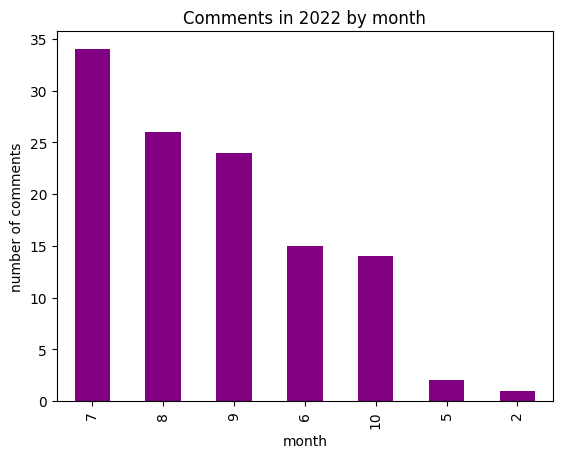

In [508]:
df3 = df2[df2["year"] == 2022]
df4 = df3[df3["comments"] > 0]
#comm = df4["comments"].tolist()
#yr = df4["month"].tolist()

df4 = df4.sort_values('month')
df4['month'].value_counts().plot.bar(color='purple'); # барплот сразу из датафрейма
plt.title('Comments in 2022 by month')
plt.xlabel('month')
plt.ylabel('number of comments');

#X =
#Y =
#plt.plot(X, Y) # drawing the plot -- connecting one by one the X and the Y coordinates
#plt.title('Frequency of some random word') # the title
#plt.ylabel('comments') # label for the Y axis
#plt.xlabel('year') # label for the X axis
#plt.show()

It's not very explicit (and for some reason I just couldn't arrange it by month, sorry about that) but we can see how the number of comments was getting larger with the news for July 2022 being the most popular and than there were less comments again (could be that not to many time passsed yet -- but I doubt it).

Let's take a look at these popular news:

In [518]:
df4[df4["month"] == 7]

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
757,Застройщикам разрешат сносить многоэтажки с не...,Власти официально разрешили застройщикам сноси...,"Кризис, вызванный современными экономическими ...",28,87,9,Экономика,20:00,21,7,2022
761,Ростех переделает часть самолетов в дирижабли,Госкорпорация «Ростех» запланировала на 2022-2...,Предварительной разработкой конструкции дирижа...,24,72,6,"Экономика, Политика",10:00,18,7,2022
35,В России разработают проект перевода английско...,Специалисты Института русского языка Российско...,Главный научный сотрудник ИРЯ РАН Дмитрий Авде...,21,130,27,Наука,16:00,19,7,2022
759,Горьковский автозавод разрабатывает грузовичок...,В Горьком разрабатывают принципиально новый не...,"Новинка имеет рабочее название «Песец», которо...",29,210,15,"Сделано у нас, Экономика",10:00,21,7,2022
758,«Холопам на бирже делать нечего»: в сети опубл...,В начале июля 2022 года на сайт Центрального б...,Экономист Михаил Делягин в своем Telegram-кана...,22,188,8,Экономика,16:33,21,7,2022
33,"В Сколково изобрели нано-монокль, надевающийся...","Резидент Сколково, компания «Поп-Тех» представ...",Толщина монокля составляет всего 100-150 тысяч...,25,150,13,"Наука, Сделано у нас",07:55,21,7,2022
29,Российский сегмент МКС активировал протокол са...,Срочная новость поступила с Международной косм...,В «Роскосмосе» ситуацию комментировать отказал...,32,131,17,"Общество, Наука, Сделано у нас",12:00,31,7,2022
756,В Госдуме рассказали о пользе упаковки для мол...,Депутат от «Единой России» Сергей Меньшаков на...,Вопрос о преимуществах такого вида упаковки ос...,26,75,14,Экономика,14:00,23,7,2022
755,Microsoft добавил возможность выбрать язык Укр...,Корпорация Microsoft выпустила обновление язык...,Как заявил директор Microsoft по разнообразию ...,28,244,17,Экономика,10:10,24,7,2022
753,Российские пенсионеры с 1 августа смогут купит...,Из-за резкого подорожания продуктов питания Ми...,"Купить в магазине, к примеру, половину картофе...",28,364,26,"Общество, Экономика",20:00,24,7,2022


Turns out it was not about number of comments but about number of news piecies in each month.

In [520]:
print('Number of comments in July 2022:', len(df4[df4["month"] == 7]))
print('Number of comments in June 2022:', len(df4[df4["month"] == 6]))
print('Number of comments in August 2022:', len(df4[df4["month"] == 8]))

Number of comments in July 2022: 34
Number of comments in June 2022: 15
Number of comments in August 2022: 26


Maybe it tells us authors have more time in July to "invent" the news (since the news on this webcite are not exactly news)? Or maybe there were some kinds of newsbreaks (I am not sure how to say "инфоповоды" in english) that were referred to on Panorama.

Let's finally look into the key words. First let's try to guess a pattern. Since these news are generally about modern Russia I bet there should be lots of bans!

In [530]:
contain_ban = df2[df2['title'].str.contains('запрет')]
print('There are', len(contain_ban), 'news that tell about some kind of ban which is', round(len(contain_ban)/len(df2['title']), 2), 'of all news.')

There are 36 news that tell about some kind of ban which is 0.03 of all news.


In [531]:
contain_ban

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
763,Ремонт «Северного потока» отложен до сентября ...,Руководство ПАО «Газпром» заявило о невозможно...,В определении Еврокомиссии от 14 марта указано...,26,21,9,Экономика,12:00,17,7,2022
877,"“Здравствуйте, это жёлтый банк”: сотрудникам “...",Сотрудникам банка “Тинькофф” запретили произно...,"Пользователи банка в соцсетях рассказали, что ...",20,599,0,"Экономика, Политика",16:27,24,4,2022
879,“Инопланетяне нас уничтожат и будут правы”: уч...,Комиссия NASA по изучению потенциальных контак...,"Представитель органа Тьерри Рессо, комментируя...",27,270,0,"Общество, Экономика",13:46,22,4,2022
95,Людям с отклонениями по зрению запретят учитьс...,Минздрав и Минобрнауки согласовали список меди...,"Из документа следует, что глубокое изучение то...",23,470,0,"Наука, Общество",16:08,30,1,2022
982,В Белоруссии запретили импорт бананов и киви,МИД Белоруссии объявил о скорейшем введении но...,"Как известно из постановления, эмбарго коснётс...",24,224,0,Экономика,20:38,11,1,2022
1002,Россельхознадзор продлил срок запрета на ввоз ...,Запрет на ввоз в Россию лимонов из Турции прод...,В Россельхознадзоре в ходе исследований собрал...,29,60,0,Экономика,08:45,20,12,2021
1005,Центробанк запретил выдавать кредиты на айфоны,Постановлением Центрального банка России вводя...,Как пояснила председатель Центробанка Эльвира ...,22,413,0,"Общество, Экономика",09:57,13,12,2021
1056,Правительство сняло запрет на вывоз леса в КНДР,Правительство отменило запрет на вывоз необраб...,"«Россия не может оставаться в стороне, когда д...",16,110,0,Экономика,14:31,8,9,2021
1097,Центробанк запретил публиковать курс доллара,Руководство Центробанка сообщило о разработке ...,Запрет затронет все российские интернет-ресурс...,27,155,0,Экономика,17:21,2,7,2021
1105,В России запретят выдавать кредиты меньше милл...,"Комитет Государственной думы по труду, социаль...",«Проблема закредитованности населения сегодня ...,27,130,0,Экономика,10:00,8,6,2021


3%, not bad! How about space and Russia?

In [532]:
contain_space = df2[df2['title'].str.contains('косм')]
print('There are', len(contain_space), 'news that tell about something space related (or rather not since it\'s usually about roskosmos)', round(len(contain_space)/len(df2['title']), 2), 'of all news.')

There are 46 news that tell about something space related (or rather not since it's usually about roskosmos) 0.04 of all news.


In [534]:
contain_space

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
696,СМИ: процедура банкротства «Роскосмоса» заверш...,Процедура банкротства бывшей государственной к...,В настоящий момент компания задолжала государс...,20,87,10,"Общество, Экономика",16:59,16,9,2022
879,“Инопланетяне нас уничтожат и будут правы”: уч...,Комиссия NASA по изучению потенциальных контак...,"Представитель органа Тьерри Рессо, комментируя...",27,270,0,"Общество, Экономика",13:46,22,4,2022
75,"""Роскосмос"" разработал ракетный двигатель, раб...",Режимное КБ №28-4 имени Сергея Королёва разраб...,РД-230К показал отличные экономические качеств...,23,211,0,"Сделано у нас, Наука",21:26,12,4,2022
77,Глава Роскосмоса выступит с просветительской м...,Руководство Роскосмоса получит из федерального...,"«В сегодняшнее тяжелое время нужна, как любят ...",24,181,0,Наука,18:18,12,4,2022
83,Илон Маск рекомендовал NASA покупать космическ...,"Американский предприниматель, основатель Space...",«Рубли можно легко приобрести на Московской ме...,29,129,0,"Наука, Экономика",12:55,3,4,2022
108,У «Роскосмоса» украли c орбиты 4 спутника,«Роскосмос» начал внутреннюю проверку по факту...,«Эти спутники были запущены в середине декабря...,22,233,0,Наука,20:51,14,1,2022
113,Юрий Лоза раскритиковал качество снимков с кос...,Российский музыкант и общественный деятель Юри...,"По словам Лозы, NASA превратилось во всемирное...",22,744,0,"Наука, Общество",20:50,28,12,2021
144,«Роскосмос» построит первый в мире орбитальный...,Госкорпорация «Роскосмос» построит первый в ми...,Для сбора и доставки космического мусора на за...,29,115,0,"Сделано у нас, Наука",14:44,21,10,2021
171,Китайский космический зонд «Тянвэнь-1» сфотогр...,Автоматическая межпланетная станция «Тянвэнь-1...,Название станции «Тянвэнь» переводится как «Во...,19,356,0,Наука,21:59,17,7,2021
181,«Роскосмос» анонсировал перестройку космодрома...,Масштабная реорганизация в несколько раз повыс...,Строительная площадка космодрома сможет удовле...,22,329,0,"Общество, Наука, Сделано у нас",21:46,17,6,2021


In [537]:
contain_russia = df1[df1['title'].str.contains('росс', 'руск')]
print('There are', len(contain_russia), 'news that tell something about Russia', round(len(contain_russia)/len(df2['title']), 2), 'of all news.')

There are 110 news that tell something about Russia 0.09 of all news.


In [538]:
contain_russia

,title,short_text,full_text,rating,share,comments,tag_name,time,day,month,year
52,Москва выходит из российско-американского дого...,МИД России заявил о денонсации российско-амери...,"«Договор о неразработке вечного двигателя», ка...",12,149,2,"Наука, Сделано у нас, Политика",17:00,26,6,2022
59,Эксперты Пентагона безуспешно потратили полгод...,Специалисты Пентагона признали провал программ...,Американские хакеры получили доступ к нескольк...,23,512,0,"Политика, Наука",09:16,15,6,2022
81,Intel начал выводить из строя процессоры росси...,Начали поступать первые сообщения о прекращени...,До этого дня не было официально известно о “за...,22,706,0,"Политика, Наука",17:40,6,4,2022
89,"Теоремы, носящие имена российских математиков,...",Исполком Международного математического союза ...,"Исполком представит свои предложения по тому, ...",25,565,0,Наука,17:03,5,3,2022
127,Владимир Мединский представил монографию «Алек...,В Российской государственной библиотеке состоя...,"«Ещё будучи студентом, я увлёкся спором между ...",23,671,0,Наука,09:38,26,11,2021
...,...,...,...,...,...,...,...,...,...,...,...
1688,"Подвиг российского омоновца в Гонконге, новое ...",Неделя выдалась интересной и богатой на событи...,"Информация, в которую почему-то не хотели ве...",22,0,0,Статьи,19:57,24,11,2019
1695,"Отравление Стерлигова, признание Робота Фёдора...","Эта неделя принесла нам много как плохих, так ...",Неприятная новость попала к нам в ленту в пятн...,23,0,0,Статьи,19:58,27,10,2019
1701,"Упразднение Ульяновской области, туалетный ска...",Эта неделя стала урожайной на события в стране...,Дипломатический скандал Начнём обзор недели с ...,19,0,0,Статьи,19:58,6,10,2019
1707,Почему россиянам запретят покидать Дальний Вос...,«Панорама» осваивает новые рубежи и теперь каж...,Россия В самой крупной по площади стране мира ...,23,0,0,Статьи,20:20,22,9,2019


With "Russia" we guessed nearly 10% of all news -- and that's too much which is exactly why it's a bad key_word. It's not accurate enough. So now let's use something more suiting for the task.

In [539]:
from pymystem3 import Mystem

import pymorphy2
from pymorphy2 import MorphAnalyzer

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

import collections
from collections import Counter

import string

[nltk_data] Downloading package punkt to /home/anya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/anya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Let's figure out the most common bigrams and trigrams in the texts of the news pieces:

In [543]:
m = Mystem()

pattern = r'[0-9«»—]'
nltk.download("stopwords")
sw = nltk.corpus.stopwords.words('russian')

j = 0    
for i in df2['full_text']:
    i1 = i.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(pattern, '', i1)
    lemmas = m.lemmatize(text)
    text = ''.join(lemmas)
    tokens = nltk.word_tokenize(text)
    
    pymorphy_lemmas = [token.replace('ё', 'е') for token in tokens]
    filtered = [w for w in pymorphy_lemmas if w not in sw]

    bigrm = list(nltk.bigrams(filtered))
    frequency = nltk.FreqDist(bigrm)
    for key,value in frequency.items():
        if value >= 5:
            print('Potential key words for\n', df2.iloc[j, 0], '\nare', key, 'with frequency rate', value, '\nVS key words suggested by Panorama:\n', df2.iloc[j, 6], end = '\n\n')
    trigrm = list(nltk.trigrams(filtered))
    frequency = nltk.FreqDist(trigrm)
    for key,value in frequency.items():
        if value >= 2:
            print('Potential key words for\n', df2.iloc[j, 0], '\nare', key, 'with frequency rate', value, '\nVS key words suggested by Panorama:\n', df2.iloc[j, 6], end = '\n\n')
    j += 1

[nltk_data] Downloading package stopwords to /home/anya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Potential key words for
 В связи с санкциями китовое семя в йогуртах Danone заменят пальмовым маслом  
are ('заменитель', 'молочный', 'жир') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potential key words for
 СМИ: процедура банкротства «Роскосмоса» завершится не ранее января  
are ('зарегистрировать', 'товарный', 'знак') with frequency rate 2 
VS key words suggested by Panorama:
 Общество, Экономика

Potential key words for
 Правительство готовится ввести статус квалифицированного собственника  
are ('статус', 'квалифицированный', 'собственник') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика, Общество

Potential key words for
 Страны Таможенного союза введут потолок цен на продукцию компании Apple  
are ('министерство', 'торговля', 'киргизия') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potential key words for
 Советник главы МВФ: «С точки зрения закона после введения санкций все долги России переходят к США 

Potential key words for
 Петербургские учёные создали таблетку, нейтрализующую действие вакцины  
are ('антивак', '–') with frequency rate 5 
VS key words suggested by Panorama:
 Наука, Сделано у нас

Potential key words for
 Apple представила эко-версию iPhone 13, распространяемую без упаковки  
are ('“', 'зеленый', '”') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Финская компания добилась исключительного права на продажу «вологодского» масла на территории РФ  
are ('настоящий', 'вологодский', 'масло') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potential key words for
 NASA: из-за глобального потепления уже через 10 лет может погибнуть один из китов, на которых стоит Земля  
are ('выброс', 'углекислый', 'газ') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 NASA: из-за глобального потепления уже через 10 лет может погибнуть один из китов, на которых стоит Земля  
are

Potential key words for
 Во льдах Антарктиды нашли замороженного человека в форме ефрейтора Третьего рейха  
are ('время', 'второй', 'мировой') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Новые квартиры для ветеранов, туманные перспективы «Аэрофлота» в Европе, путешествие из КНДР на дрезине и новый посол Белоруссии в России в нашей еженедельной рубрике «Панорама недели»  
are ('депутат', 'петр', 'толстой') with frequency rate 2 
VS key words suggested by Panorama:
 Статьи

Potential key words for
 У первого президента России обнаружен тайный сын  
are ('сын', 'ельцин') with frequency rate 5 
VS key words suggested by Panorama:
 Политика, Статьи

Potential key words for
 У первого президента России обнаружен тайный сын  
are ('внебрачный', 'сын', 'ельцин') with frequency rate 2 
VS key words suggested by Panorama:
 Политика, Статьи

Potential key words for
 Минпросвещения предложило пороть розгами участвующих в митингах школьников и студен

Potential key words for
 Ученые выяснили, почему мухи не садятся на поляков  
are ('адыгейский', 'абхазский', 'язык') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Кого отнесут в разряд простолюдинов, кого заставят сбрить бороды и кого ожидают морские купания в медицинской маске и разговор со школьным психологом в нашей еженедельной рубрике «Панорама недели»  
are ('день', 'победа', 'наш') with frequency rate 2 
VS key words suggested by Panorama:
 Статьи

Potential key words for
 «Я его освободил, я и отстрою»: 97-летний ветеран пожертвовал пенсионные накопления на восстановление Воронежа  
are ('иван', 'павлович') with frequency rate 5 
VS key words suggested by Panorama:
 Общество, Статьи

Potential key words for
 Автомобили стоимостью выше 3 млн рублей будут продаваться только в пакете с "Ладой"  
are ('желающий', 'приобретать', 'автомобиль') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potential key words for


Potential key words for
 Работник Нижнетагильского тракторного завода представил публике логарифмического кузнечика  
are ('точка', 'x', 'либо') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Работник Нижнетагильского тракторного завода представил публике логарифмического кузнечика  
are ('x', 'либо', 'точка') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Работник Нижнетагильского тракторного завода представил публике логарифмического кузнечика  
are ('либо', 'точка', 'x') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Марсоход Curiosity мог по ошибке отправлять данные "Роскосмосу"  
are ('рлс', 'год', 'выпуск') with frequency rate 2 
VS key words suggested by Panorama:
 Наука

Potential key words for
 Huawei выпустит смартфон под LineageOS  
are ('Google', 'Play', 'Market') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика

Potenti

Potential key words for
 "Я попросил одного из лидеров сделать глаза пошире, а он ни в какую, оказалось – это президент Китая Си". Откровенное интервью премьер-министра Канады Джастина Трюдо  
are ('передача', 'власть', 'наследство') with frequency rate 2 
VS key words suggested by Panorama:
 Статьи

Potential key words for
 Дуров предложил движению "Цифрового сопротивления" добавить к аватаркам с собаками бумажные самолетики  
are ('собака', 'сопротивление', 'бумажный') with frequency rate 2 
VS key words suggested by Panorama:
 Статьи

Potential key words for
 Почему Владимир лучше Парижа  
are ('кстати', 'париж', 'видеть') with frequency rate 2 
VS key words suggested by Panorama:
 Мнение, Статьи



This way is not perfect at all but if you look through the list of suggestions you can see that some of them make a lot of sence:

Potential key words for
 Американский вуз не смог собрать команду для участия в олимпиаде по физике после отъезда китайских студентов  
are ('массачусетский', 'технологический', 'институт') with frequency rate 2 
VS key words suggested by Panorama:
 Наука, Политика
 
Potential key words for
 Топ-менеджеры АВТОВАЗ выписали себе многомиллионные премии за значительное снижение случаев брака  
are ('отдел', 'контроль', 'качество') with frequency rate 2 
VS key words suggested by Panorama:
 Экономика, Сделано у нас

Potential key words for
 Итоги года. Наука  
are ('итог', 'год') with frequency rate 10 
VS key words suggested by Panorama:
 Наука, Статьи
 
Potential key words for
 Не так страшен ядерный чёрт, как его малюют!  
are ('ядерный', 'война') with frequency rate 6 
VS key words suggested by Panorama:
 Статьи
 
Potential key words for
 Набиуллина: «Мы постоянно читаем мантры о стабильности рубля». Эксклюзивное интервью с главой Центробанка  
are ('российский', 'экономика') with frequency rate 5 
VS key words suggested by Panorama:
 Статьи

Now let's use syntax.

In [544]:
!pip install -U pip setuptools wheel
!pip install -U spacy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [306]:
#!python -m spacy download ru_core_news_sm

/bin/bash: python: command not found


In [545]:
import spacy.cli
nlp = spacy.cli.download("ru_core_news_sm")

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 5.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [546]:
nlp = spacy.load("ru_core_news_sm")

In [547]:
from spacy.lang.ru.examples import sentences 
doc = nlp(sentences[0])
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)

Apple рассматривает возможность покупки стартапа из Соединённого Королевства за $1 млрд
Apple PROPN nsubj
рассматривает VERB ROOT
возможность NOUN obj
покупки NOUN nmod
стартапа NOUN nmod
из ADP case
Соединённого ADJ amod
Королевства PROPN nmod
за ADP case
$ SYM nmod
1 NUM appos
млрд NOUN punct


In [548]:
from spacy import displacy

r = nlp(df2.iloc[1, 0])

displacy.render(r, style='dep')

Let's take another look at the tags suggested by Panorama and see if there was any correlation between their popularity and number of news in the respective section.

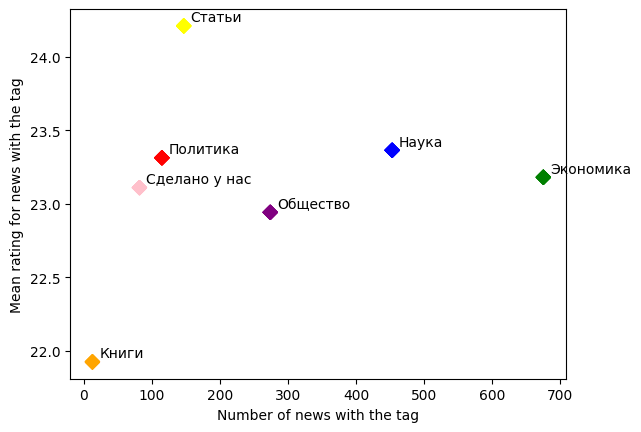

In [562]:
import statistics
dots = ["Наука", "Экономика", "Статьи", "Книги", "Политика", "Общество", "Сделано у нас"]

contain_sc = df2[df2['tag_name'].str.contains(dots[0])]
contain_ec = df2[df2['tag_name'].str.contains(dots[1])]
contain_ar = df2[df2['tag_name'].str.contains(dots[2])]
contain_bo = df2[df2['tag_name'].str.contains(dots[3])]
contain_po = df2[df2['tag_name'].str.contains(dots[4])]
contain_so = df2[df2['tag_name'].str.contains(dots[5])]
contain_ma = df2[df2['tag_name'].str.contains(dots[6])]

sum_sc = []
sum_ec = []
sum_ar = []
sum_bo = []
sum_po = []
sum_so = []
sum_ma = []

j=0
for i in df2['rating']:
    if dots[0] in df2.iloc[j, 6]:
        sum_sc.append(i)
    if dots[1] in df2.iloc[j, 6]:
        sum_ec.append(i)
    if dots[2] in df2.iloc[j, 6]:
        sum_ar.append(i)
    if dots[3] in df2.iloc[j, 6]:
        sum_bo.append(i)
    if dots[4] in df2.iloc[j, 6]:
        sum_po.append(i)
    if dots[5] in df2.iloc[j, 6]:
        sum_so.append(i)
    if dots[6] in df2.iloc[j, 6]:
        sum_ma.append(i)
    j+=1

X = [len(contain_sc), len(contain_ec), len(contain_ar), len(contain_bo), len(contain_po), len(contain_so), len(contain_ma)]
Y = [statistics.mean(sum_sc), statistics.mean(sum_ec), statistics.mean(sum_ar), statistics.mean(sum_bo), statistics.mean(sum_po), statistics.mean(sum_so), statistics.mean(sum_ma)]

for x, y, m, d in zip(X, Y, markers, dots):
    colors = ['blue', 'green', 'yellow', 'orange', 'red', 'purple', 'pink']
    plt.scatter(X, Y, s=50, c=colors, marker='D')
    plt.text(x+10, y+0.03, d)
    plt.ylabel('Mean rating for news with the tag')
    plt.xlabel('Number of news with the tag')
plt.show()

In this plot we see that tags __books__, __society__ and __science__ are as popular among writers as among the readers, while __economics__ gets a lower rating with more news and the rest tags (__made in Russia__, __politics__ and __articles__) are generally loved by audience -- possibly for humor reasons :)

As we remember though tags are usually used not by one:

In [556]:
df5 = df2['tag_name'].value_counts()
df5

Экономика                                 420
Наука                                     254
Общество, Экономика                       134
Статьи                                    107
Наука, Общество                            71
Политика, Экономика                        63
Наука, Сделано у нас                       48
Общество, Наука                            26
Экономика, Общество                        18
Экономика, Политика                        16
Книги                                      13
Политика, Статьи                           12
Сделано у нас, Наука                       11
Наука, Статьи                              11
Наука, Политика                            11
Общество, Статьи                            8
Сделано у нас, Экономика                    5
Наука, Экономика                            4
Политика, Наука                             4
Общество, Политика, Экономика               4
Статьи, Политика                            3
Экономика, Сделано у нас          

Не успела доделать:
+ 2 графика (1/2 интерактивный)!!
+ синтаксический анализ!!